# Introduction to Macrosynergy package

This notebook shows how to download, process, describe, and analyze macro quantamental data through the **Macrosynergy package**.

Macro quantamental indicators are mostly time series of information states of economic trends, balance sheets, and conditions. They are particularly suitable for backtesting and operating financial market trading strategies. The primary source of macro quantamental indicators is the J.P. Morgan - Macrosynergy Quantamental System ("JPMaQS"). The format has a few specifics that make it easy to discover investment values:

* All values are point-in-time, meaning they represent the latest value of a concept at the end of the date for which they have been recorded.
* The point-in-time format means that they can be related easily to time series of financial returns; many types of financial returns are also included in the system.
* Data are organized in panels, i.e., one type of quantamental indicator ("category") time series is available over a range of tradable markets or countries.
* Each observation of an indicator does not just contain a value but also information on the time that has elapsed since the recorded activity has taken place and the quantity of the replication of the historic information state.

The Macrosynergy package contains convenience functions to handle this specific format and arrive quickly at conclusions for the investment process. It is not designed to compete with general statistics and graphics packages but merely serves as a shortcut to quick results and a guide to the type of operations and analyses that one can swiftly conduct on JPMaQS data. 

The notebook covers the following main parts:

- __Get Packages and JPMaQS Data:__ This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis, including `macrosynergy` package. 

- __Describing:__ In this part, the notebook shows how to check data availability, detect missing categories, visualize panel distributions with the help of standard bar and box plots, and analyze data with the help of time series and heatmaps.

- __Pre-processing:__ this part shows examples of simple data transformation, such as creating a new category, excluding series, computing relative values, normalizing data, etc.  

- __Relating:__ the functions in this part look into visualization and analysis of relationships between two categories: it is based on standard `seaborn` functions scatterplot, but allows for additional customization for trading signal creation.  

- __Learning:__ the `macrosynergy.learning` subpackage contains functions and classes to assist the creation of statistical learning solutions with macro quantamental data. The functionality is built around integrating the `macrosynergy` package and associated JPMaQS data with the popular `scikit-learn` library, which provides a simple interface for fitting common statistical learning models, as well as feature selection methods, cross-validation classes, and performance metrics.

- __Signaling:__ this part is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

- __Backtesting:__ the functions here are designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label `naive` because its methods do not take into account transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

For examples of standard packages used with JPMaQS,  please have a look at the notebooks ["JPMaQS with Seaborn"](https://academy.macrosynergy.com/academy/Data%20science/JPMaQS%20for%20Seaborn/_build/html/JPMaQS%20for%20Seaborn.php), ["JPMaQS with Statsmodels"](https://academy.macrosynergy.com/academy/Data%20science/JPMaQS%20with%20Statsmodels/_build/html/JPMaQS%20with%20Statsmodels.php), and ["Panel regression with JPMaQS"](https://academy.macrosynergy.com/academy/Data%20science/Panel%20regression%20with%20JPMaQS/_build/html/Panel%20regression%20with%20JPMaQS.php).

# Get packages and JPMaQS data

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
print(str(Path.cwd().parent))

c:\finance\macrosynergy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm 
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import macrosynergy.visuals as msv
import macrosynergy.learning as msl

from macrosynergy.download import JPMaQSDownload

# machine learning modules
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import (
    make_scorer,
    balanced_accuracy_score,
    r2_score,
)


import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md) or use the free dataset on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends)

To ensure reproducibility, only samples between January 2000 (inclusive) and May 2023 (exclusive) are considered.

In [3]:
cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = ["CLP","COP", "CZK", "HUF", "IDR", "ILS", "INR", "KRW", "MXN", "PLN", "THB", "TRY", "TWD", "ZAR",]
cids = cids_dm + cids_em

cids_dux = list(set(cids) - set(["IDR", "NZD"]))

In [4]:
ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [5]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "2000-01-01"
end_date = "2023-05-01"

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}") 


# Download series from J.P. Morgan DataQuery by tickers

# client_id: str = os.getenv("DQ_CLIENT_ID")
# client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
#     df = dq.download(
#         tickers=tickers,
#         start_date="2000-01-01",
#         suppress_warning=True,
#         metrics=["all"],
#         show_progress=True,
#     )


Maximum number of tickers is 600


The `Macrosynergy` package works with data frames of a standard JPMaQS format, i.e., long data frames with at least four columns containing cross-section (`cid`), extended category (`xcat`), real-time dates (`real_date`), and `value`. Other potentially useful columns contain grades of observations (`grading`), lags to the end of the observation period (`eop_lag`), and lags to the median of the observation period (`mop_lag`).

In [ ]:
import kagglehub
import os
#os.environ['KAGGLEHUB_CACHE'] = './kaggle'
#macrosynergy_fixed_income_returns_and_macro_trends_path = kagglehub.dataset_download('macrosynergy/fixed-income-returns-and-macro-trends')
macrosynergy_fixed_income_returns_and_macro_trends_path = './kaggle'
print('Data source import complete.')
print('Data source path:', macrosynergy_fixed_income_returns_and_macro_trends_path)

Data source import complete.
Data source path: ./kaggle\datasets\macrosynergy\fixed-income-returns-and-macro-trends\versions\17


In [7]:
df = pd.read_csv(macrosynergy_fixed_income_returns_and_macro_trends_path + '\JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])
display (df.head(3))

real_date  cid              xcat     value  grading  eop_lag  mop_lag
0 2000-01-03  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     95.0    292.0
1 2000-01-04  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     96.0    293.0
2 2000-01-05  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     97.0    294.0

The description of each JPMaQS category is available either under [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/), [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected), or on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) (just for the tickers used in this notebook). In particular, the set used for this notebook is using [Consumer price inflation trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consumer%20price%20inflation%20trends.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), [Intuitive growth estimates](https://macrosynergy.com/academy/notebooks/intuitive-gdp-growth-estimates/), [Domestic credit ratios](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Domestic%20credit%20ratios.php), [Long-term GDP growth](https://macrosynergy.com/academy/notebooks/gdp-growth/), [Real interest rates](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Real%20interest%20rates.php), [Private credit expansion](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Private%20credit%20expansion.php), [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php), [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php), [FX forward returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php), [FX forward carry](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20forward%20carry.php), and [FX tradeability and flexibility](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20tradeability%20and%20flexibility.php)


In [8]:
df['ticker'] = df['cid'] + "_" + df["xcat"]

In [9]:
dfx = df.copy()
dfx.info() 
dfx.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
 7   ticker     object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 232.8+ MB


real_date  cid              xcat     value  grading  eop_lag  mop_lag  \
0 2000-01-03  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     95.0    292.0   
1 2000-01-04  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     96.0    293.0   
2 2000-01-05  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     97.0    294.0   

                 ticker  
0  AUD_CPIC_SA_P1M1ML12  
1  AUD_CPIC_SA_P1M1ML12  
2  AUD_CPIC_SA_P1M1ML12

# Describing

## View available data history with `check_availability`

The convenience function `check_availability()` visualizes start years and the number of missing values at or before the end date of all selected cross-sections and across a list of categories. It also displays unavailable indicators as gray fields and color codes the starting year of each series with darker colors indicating more recent starting years. If we are interested only in availability starting with a particular date, we pass this option as "start". 

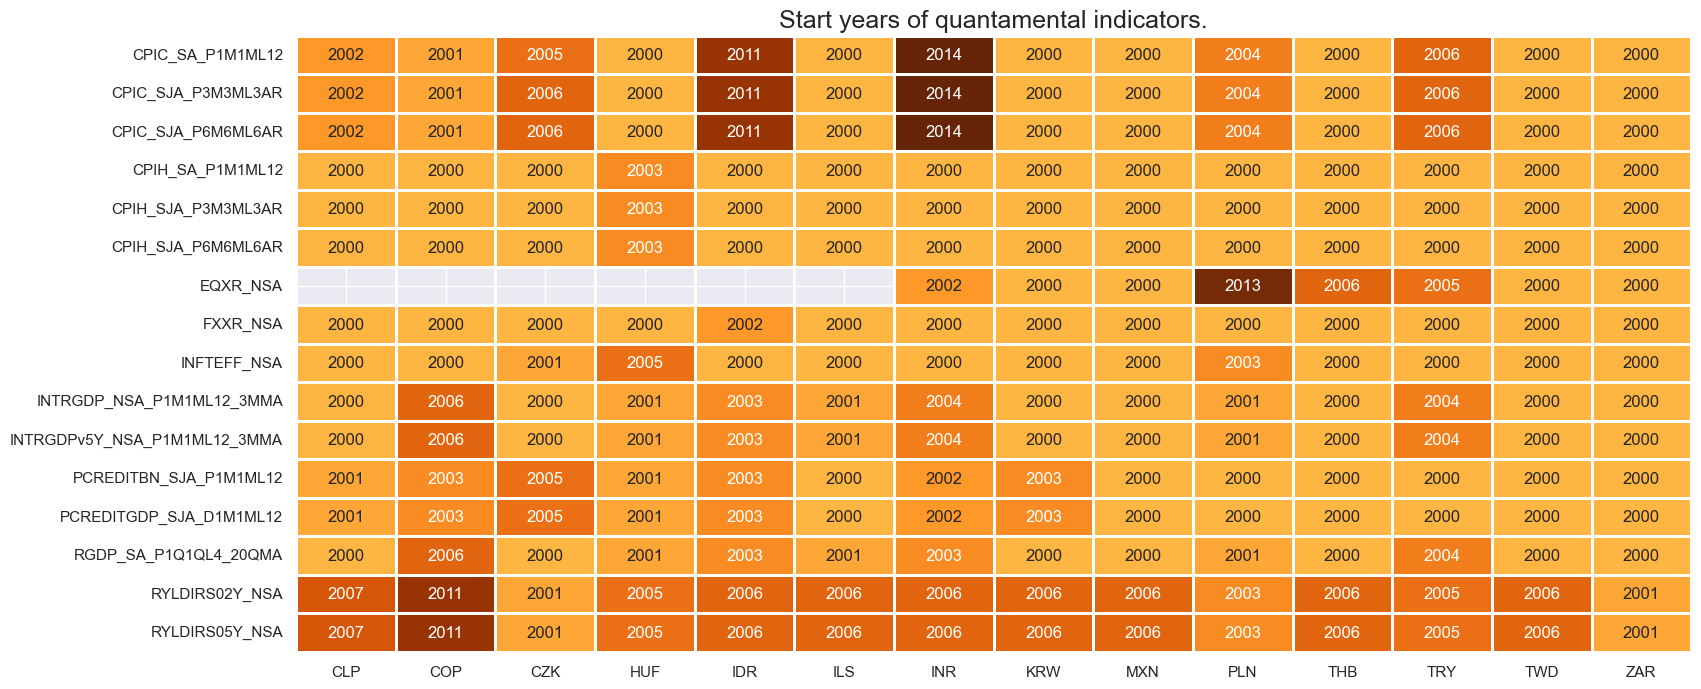

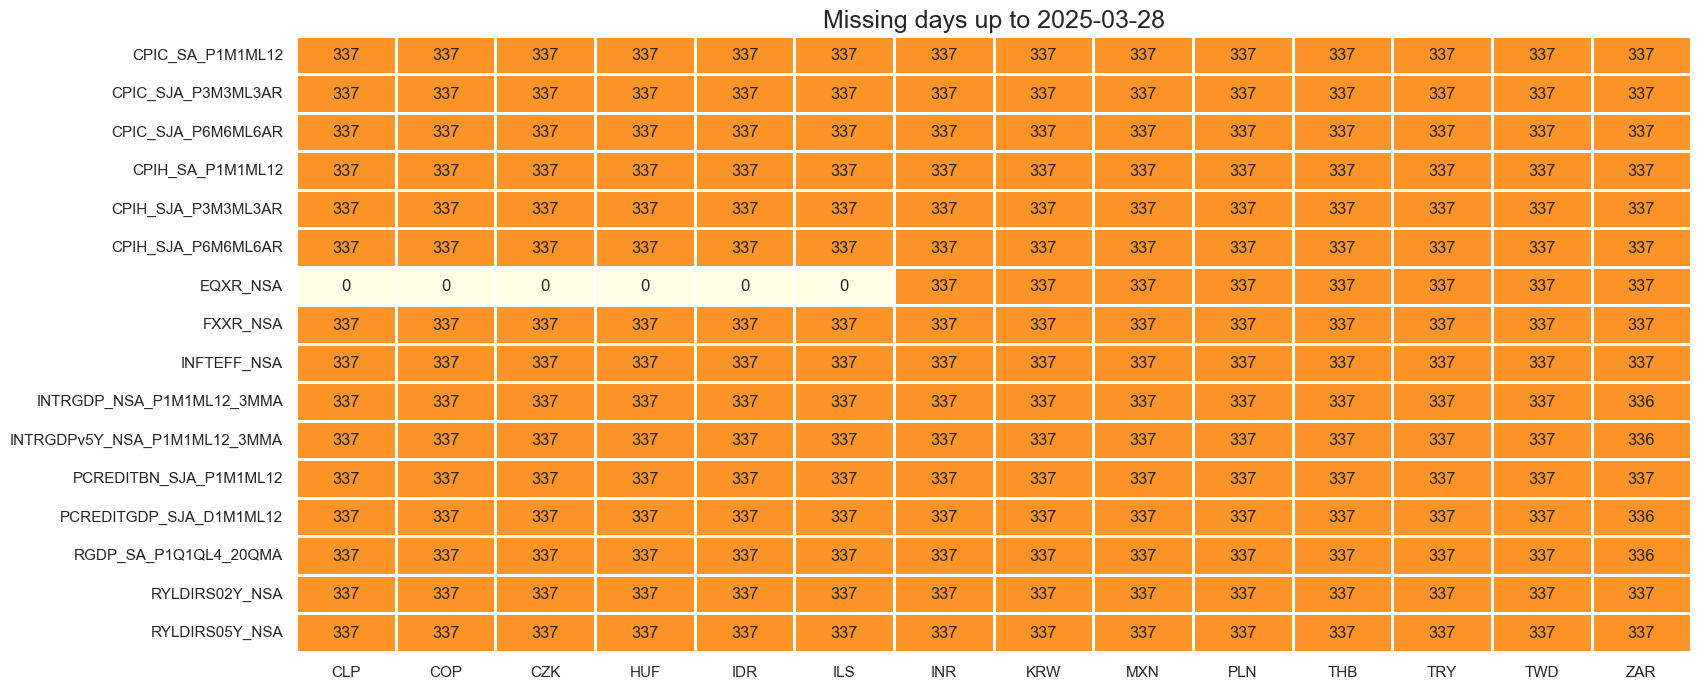

In [10]:
msm.check_availability(
    dfx,
    xcats=ecos + ["EQXR_NSA"]+ ["FXXR_NSA"],
    cids=cids_em,
    start="2000-01-01",
)

## Detect missing categories or cross-sections with `missing_in_df`

The function `missing_in_df()` is complimentary to `check_availability` and simply displays (1) categories that are missing across all expected cross-sections for a given category name list and (2) cross-sections that are missing within a category. 

In [11]:
cats_exp = ["EQCRR_NSA", "FXCRR_NSA", "INTRGDP_NSA_P1M1ML12_3MMA", "RUBBISH"]
msm.missing_in_df(dfx, xcats=cats_exp, cids=cids)

Missing XCATs across DataFrame:  ['RUBBISH', 'EQCRR_NSA']
Missing cids for FXCRR_NSA:                  ['USD']
Missing cids for INTRGDP_NSA_P1M1ML12_3MMA:  []


## Visualize panel distributions with `view_ranges`

For an overview of long-term series distributions in a panel, the convenience function `view_ranges()` uses standard bar plots and box plots of the `Seaborn` package to quickly and conveniently fit the JPMaQS format. 

For example, choosing `kind='bar'` displays a  barplot that focuses on means and standard deviations of one or more categories across sections for a given sample period. One can define the start and the end date of the time series. The default would be the earliest available date as the start and the latest available as the end date.

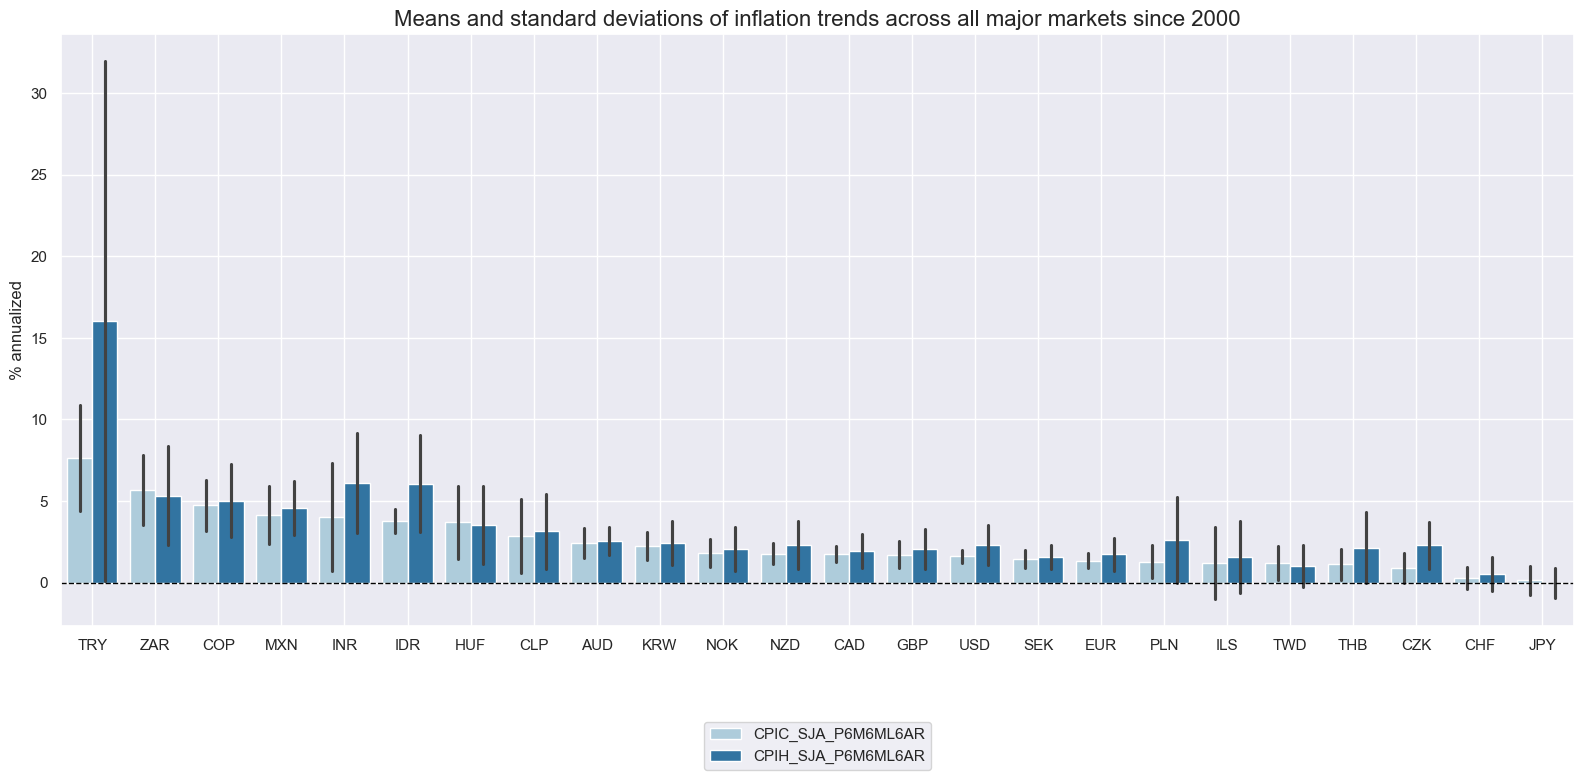

In [12]:
xcats_sel = ["CPIC_SJA_P6M6ML6AR", "CPIH_SJA_P6M6ML6AR"]
msp.view_ranges(
    dfx,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",  # countries sorted by mean of the first category
    title="Means and standard deviations of inflation trends across all major markets since 2000",
    ylab="% annualized",
    start="2000-01-01",
    end="2020-01-01",
)

Choosing `kind='box'` gives a barplot that visualizes 25%, 50% (median), and 75% quantiles and outliers beyond a normal range. Chart title, y-axis label, size, and category labels can be customized as shown below:

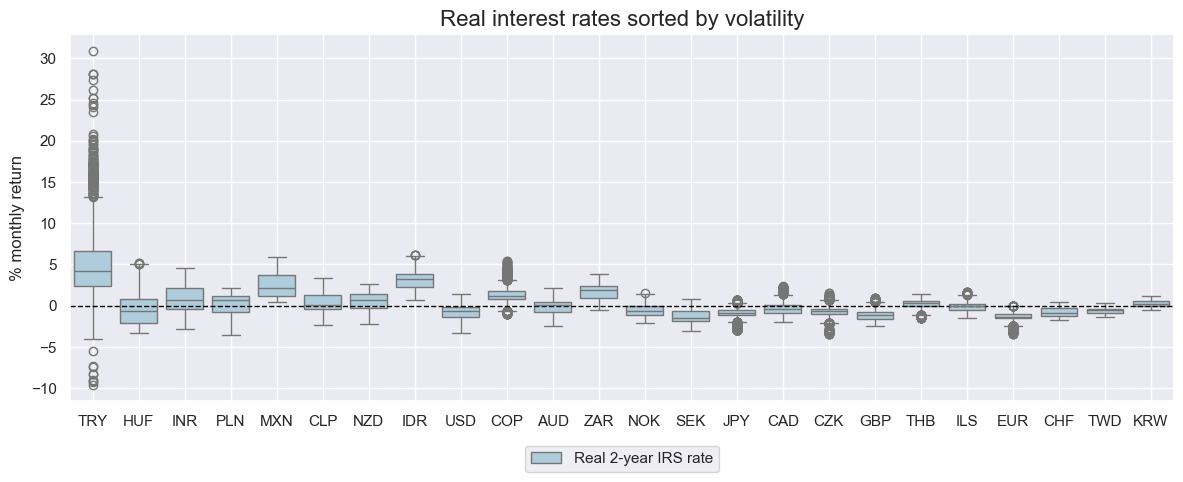

In [13]:
xcats_sel = ["RYLDIRS02Y_NSA"]
msp.view_ranges(
    dfx,
    xcats=xcats_sel,
    kind="box",
    start="2012-01-01",
    sort_cids_by="std",  # here sorted by standard deviations
    title="Real interest rates sorted by volatility",
    ylab="% monthly return",
    xcat_labels=["Real 2-year IRS rate"],
    size=(12, 5),
)

## Visualize panel time series with `view_timelines`

The convenience function `view_timelines()` displays a facet grid of timeline charts of one or more categories.

The `cs_mean=True` option adds a timeline of the cross-sectional average of a single category to each plot in the facet, emphasizing cross-sectional deviations.

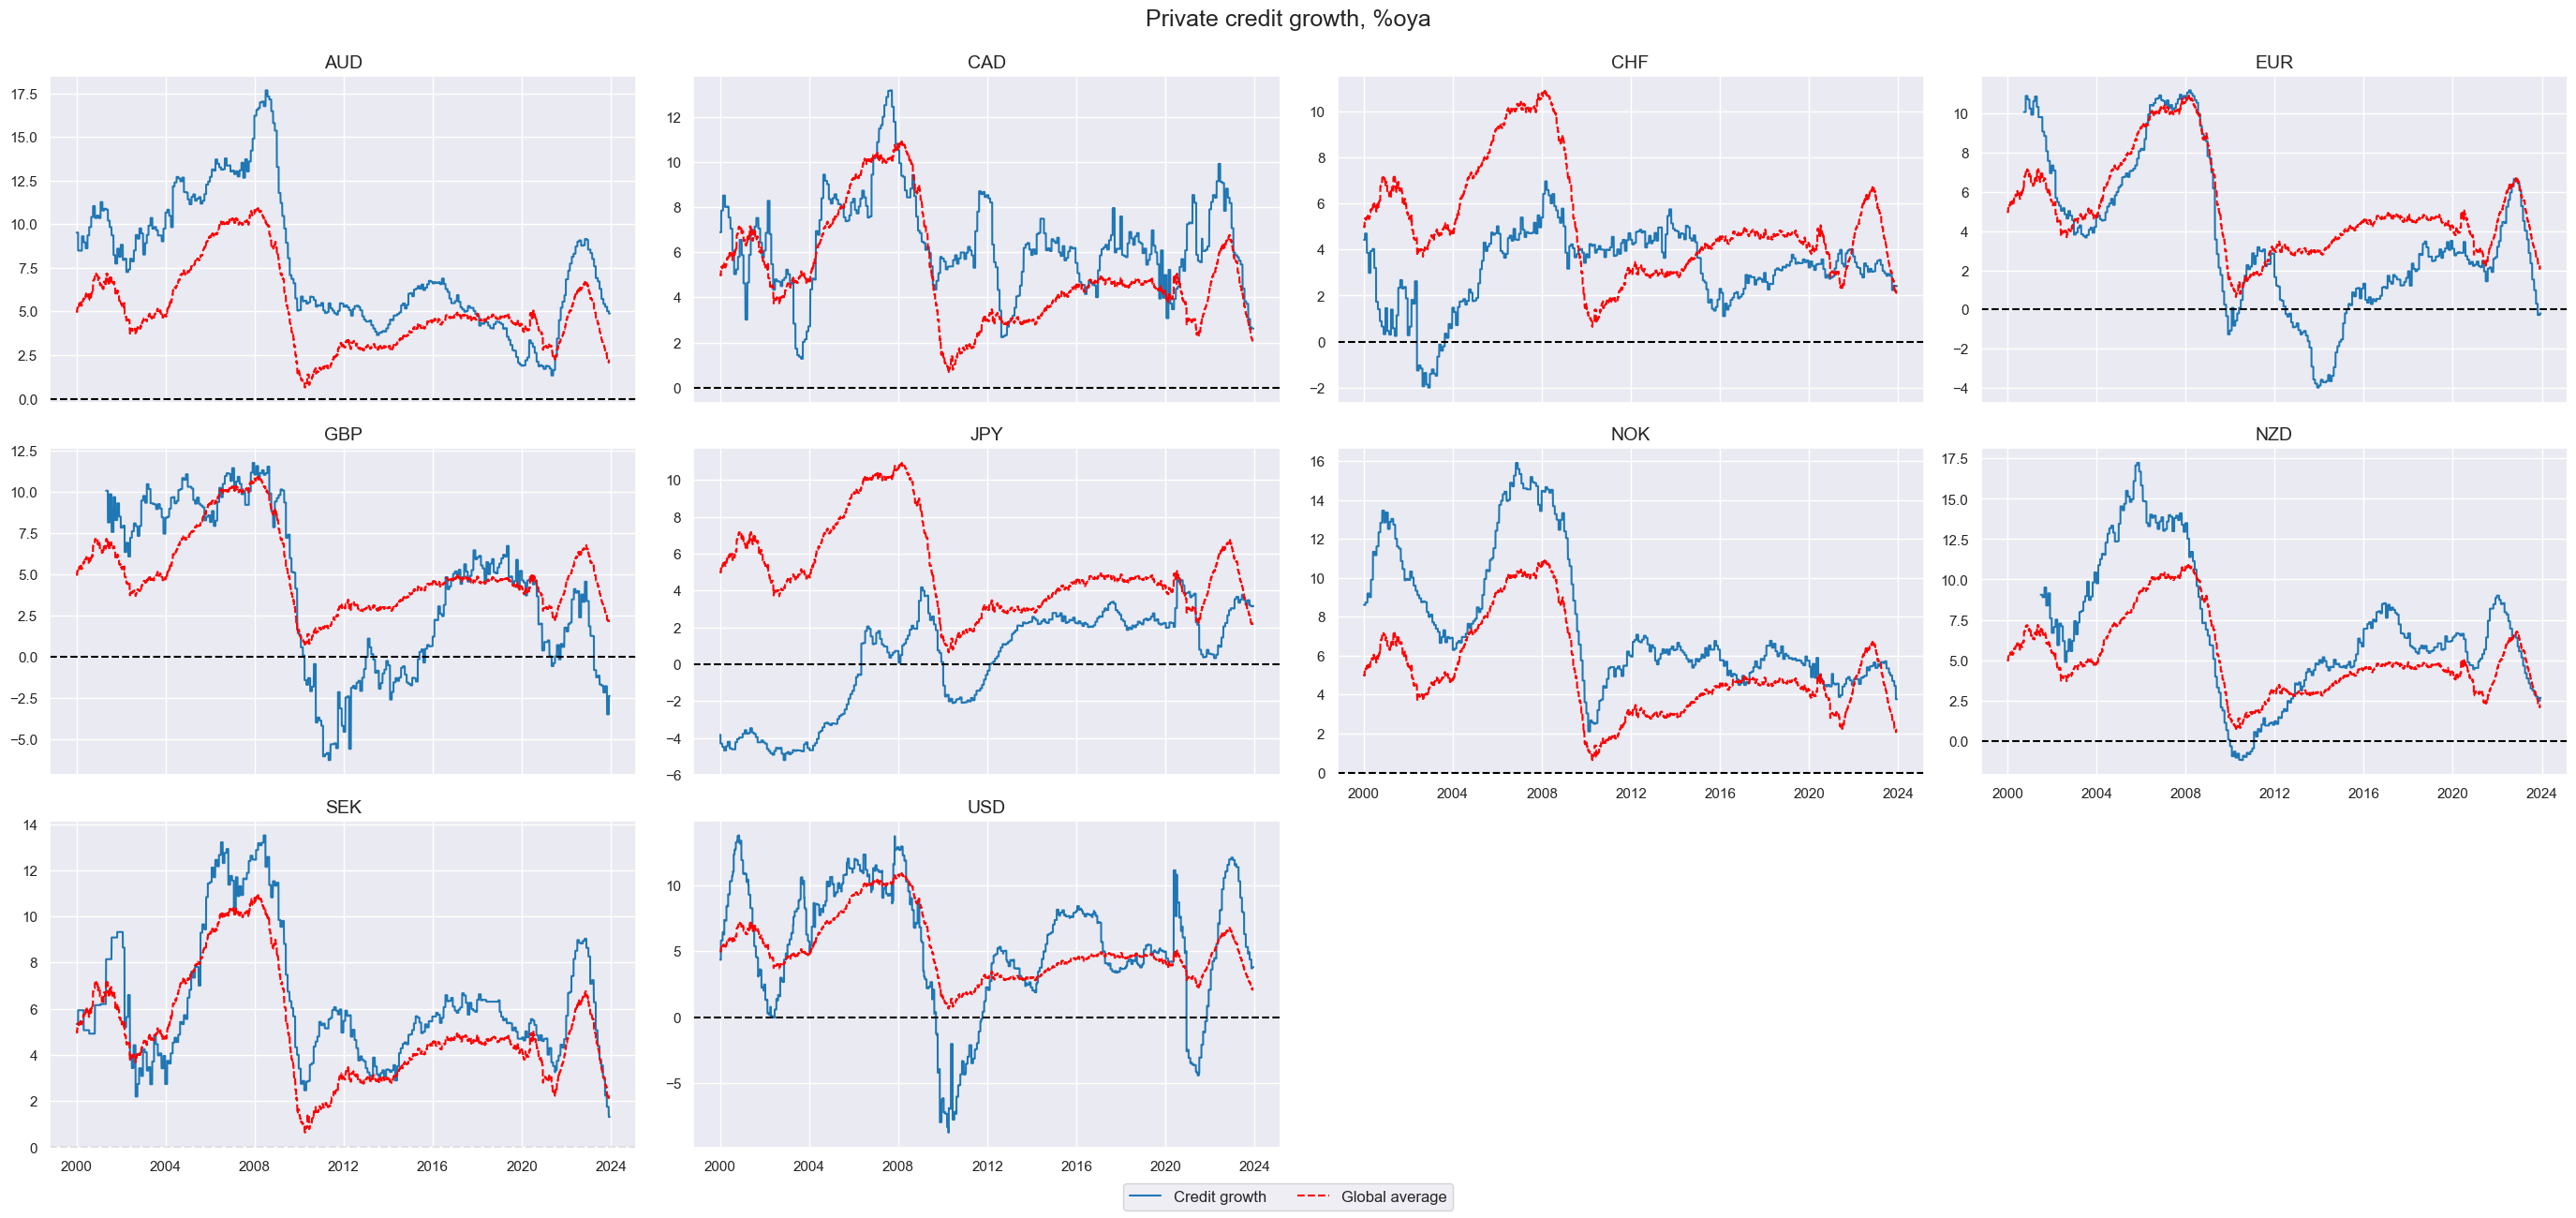

In [14]:
msp.view_timelines(
    dfx,
    xcats=["PCREDITBN_SJA_P1M1ML12"],
    cids=cids_dm,
    ncol=4,
    start="1995-01-01",
    title="Private credit growth, %oya",
    same_y=False,
    cs_mean=True,
    xcat_labels=["Credit growth", "Global average"],
)

Arguments can be set according to the data's nature and the plot's intention. The following are important choices:

* For asset returns and similarly volatile series, displaying cumulative sums with `cumsum=True` is often desirable.
* The default setting `same_y=True` shows all lines on the same scale for comparability of size.
* For large facets `xticks=True`, the time (x-) axis is printed under each chart, not just the bottom row.
* The `xcat_labels` argument customizes the category labels (the default is just category tickers).

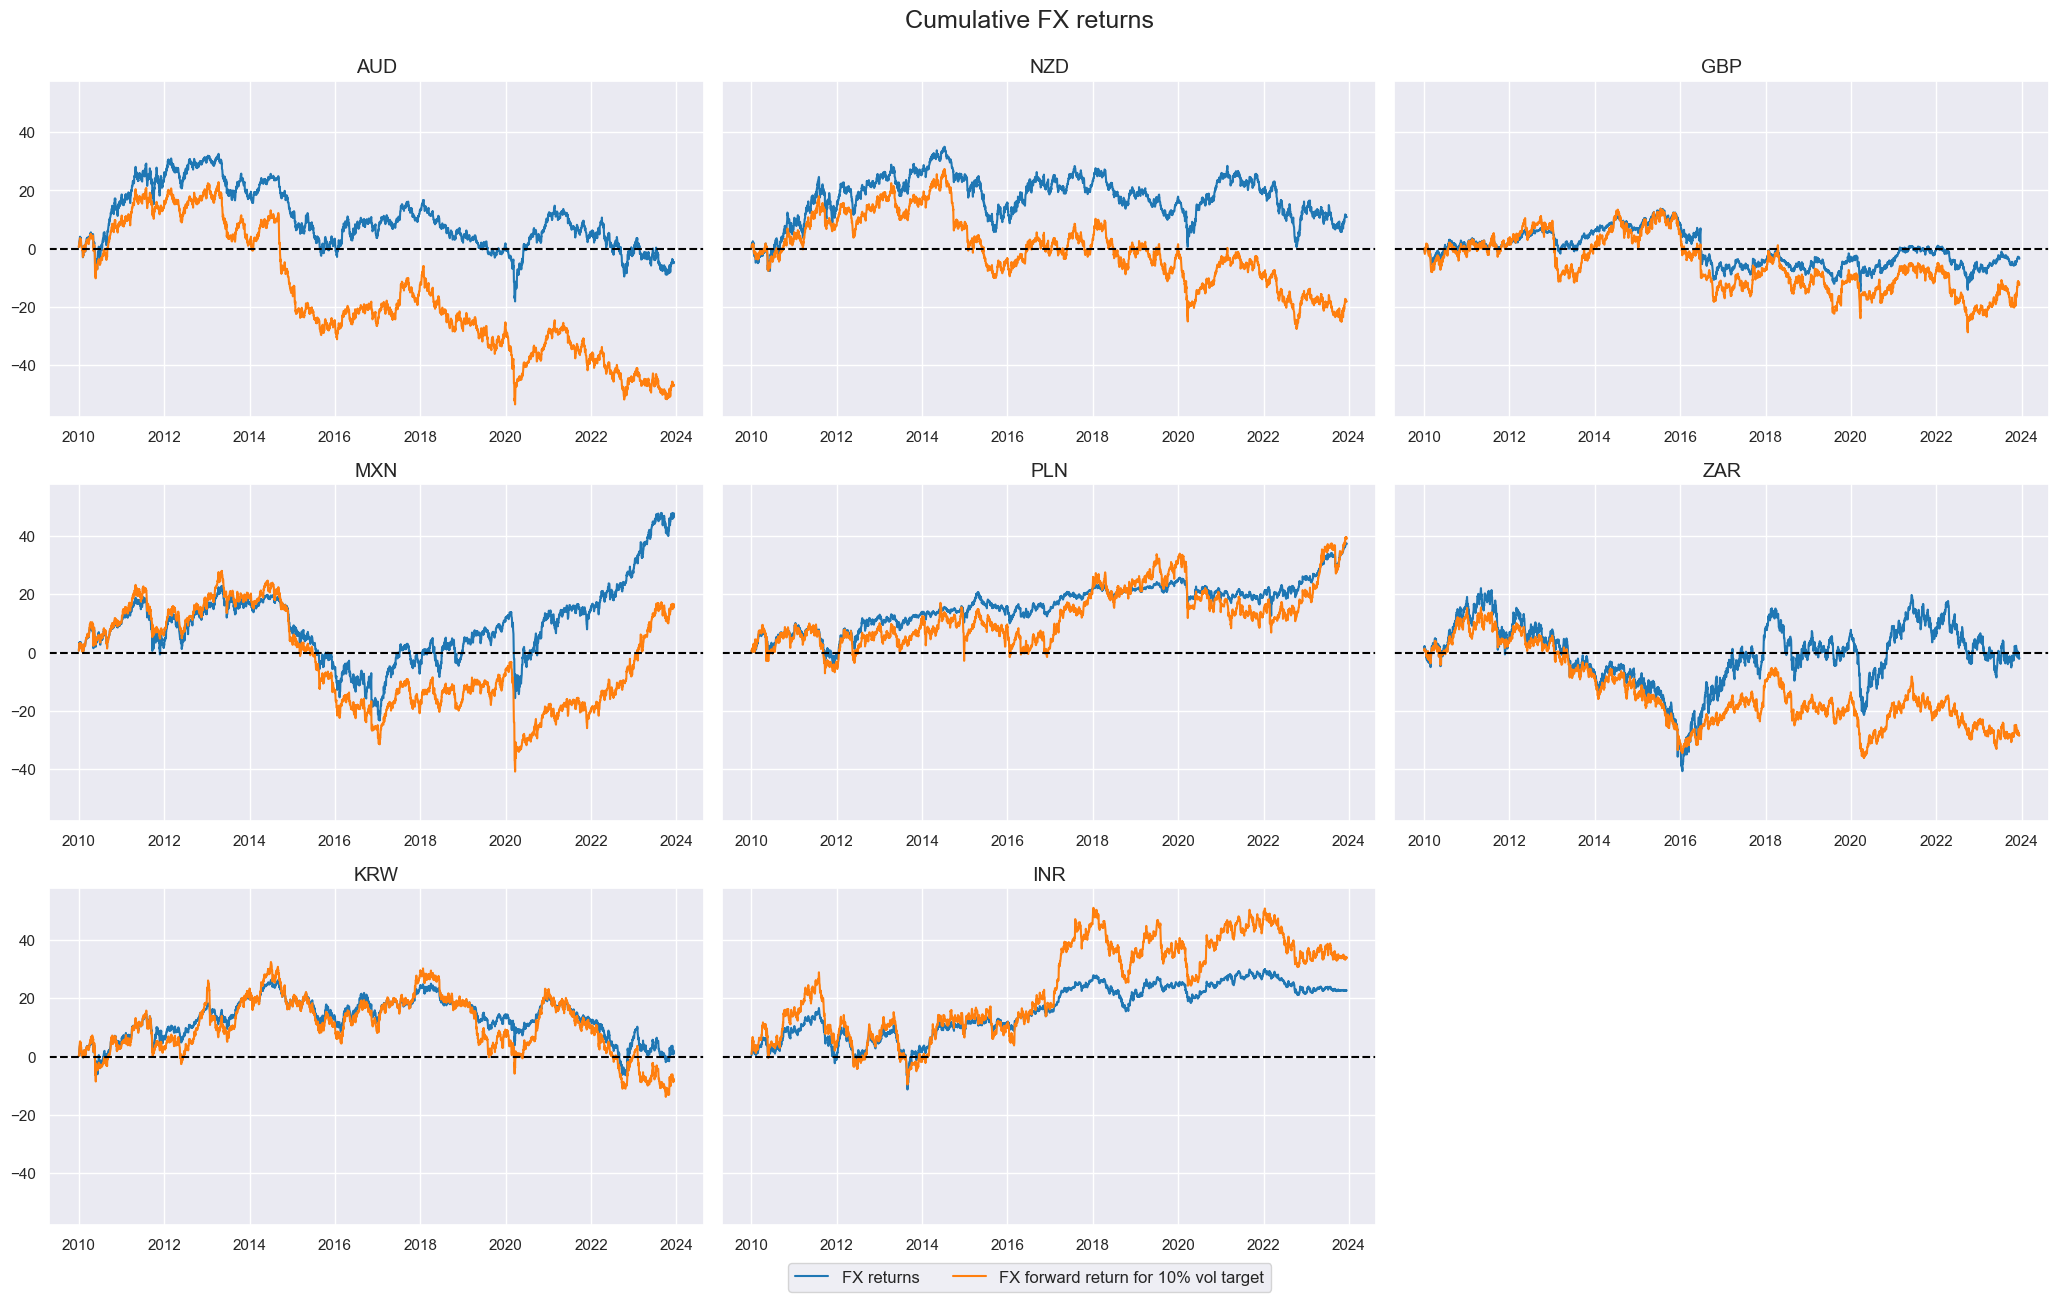

In [15]:
cids_sel = ["AUD", "NZD", "GBP", "MXN", "PLN", "ZAR", "KRW", "INR"]
msp.view_timelines(
    dfx,
    xcats=["FXXR_NSA", "FXXR_VT10"],
    cids=cids_sel,
    ncol=3,
    cumsum=True,
    start="2010-01-01",
    same_y=True,
    all_xticks=True,
    title="Cumulative FX returns",
    xcat_labels=["FX returns", "FX forward return for 10% vol target"],
    
)

One can display a single chart, displaying several categories for a single cross-section by passing a single-string list to `xcats` and specifying a cross-section as a list with single element, such as `cids=["USD"]`

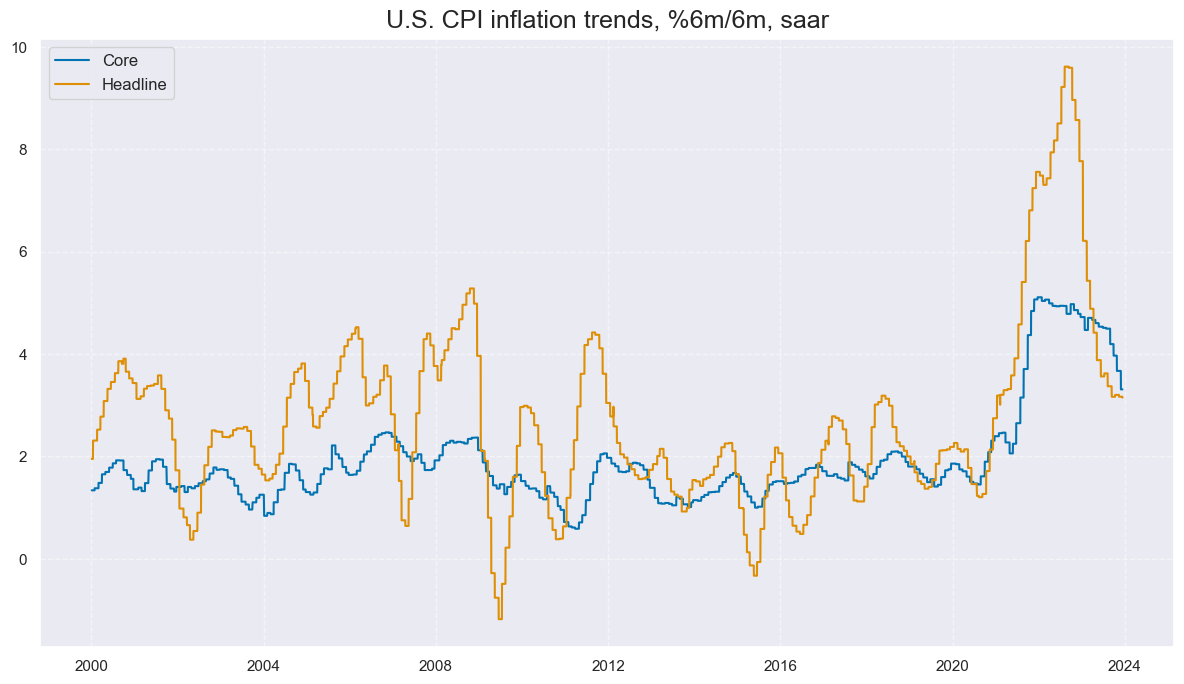

In [16]:
msp.view_timelines(
    dfx,
    xcats=["CPIC_SJA_P6M6ML6AR", "CPIH_SJA_P6M6ML6AR"],
    cids=["USD"],
    start="2000-01-01",
    title="U.S. CPI inflation trends, %6m/6m, saar",
    xcat_labels=["Core", "Headline"],
)  

Setting `single_chart=True` allows plotting a single category for various cross-sections in one plot. Per default, full tickers are used as labels. 

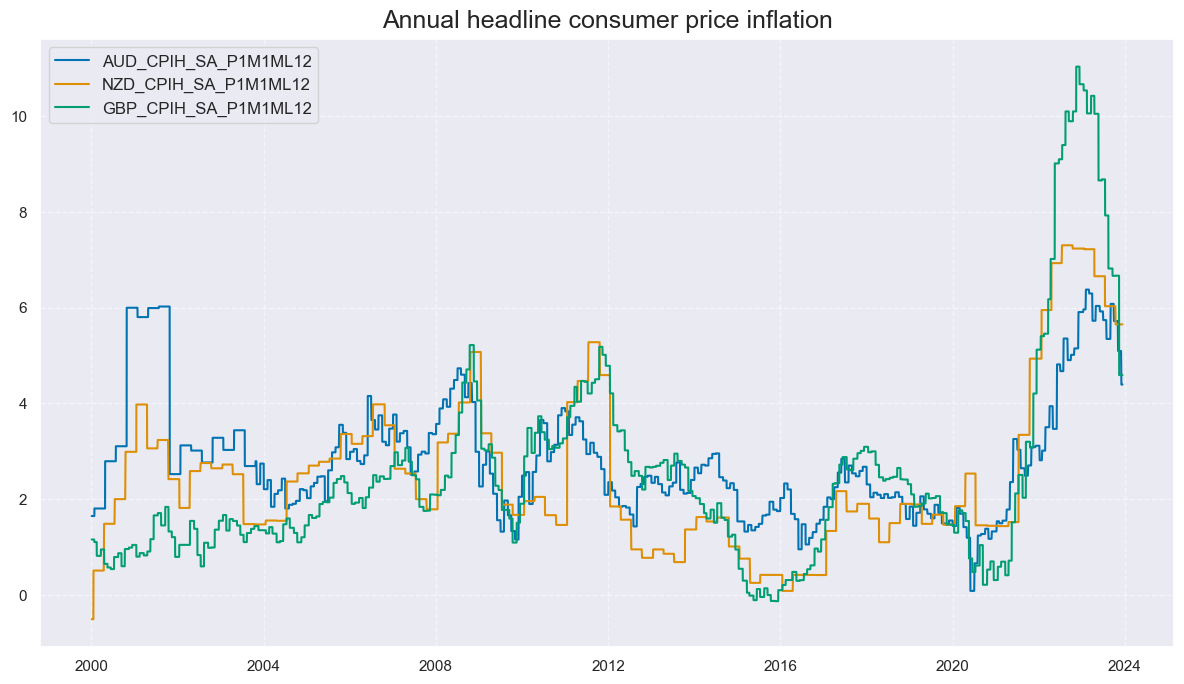

In [17]:
cids_sel = ["AUD", "NZD", "GBP"]

msp.view_timelines(
    dfx,
    xcats=["CPIH_SA_P1M1ML12"],
    cids=cids_sel,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    title="Annual headline consumer price inflation",
    single_chart=True,
)

## Visualize vintage qualities with `heatmap_grades`

The visualization function `heatmap_grades()` displays a colored table of grading quality of indicators by categories and cross-sections as an average for a given start date. Darker colors represent lower grading. 

This function visualizes the grades of the vintages based on which quantamental series have been calculated. JPMaQS uses vintages, i.e., time sequences of time series, to replicate the information of the market in the past. Vintages arise from data revisions, extension, and re-estimation of parameters of any underlying model. JPMaQS grades vintage time series from 1 (highest quality, either original record of the time series available on that date or a series that is marginally different from the original for storage reasons or publication conventions) to grade 3 (rough estimate of the information status). More details on vintages and grades are [here](https://markets.jpmorgan.com/jpmcp-cm/content/jpm-cp/research/jpmaqs/index/home/data-format.html)

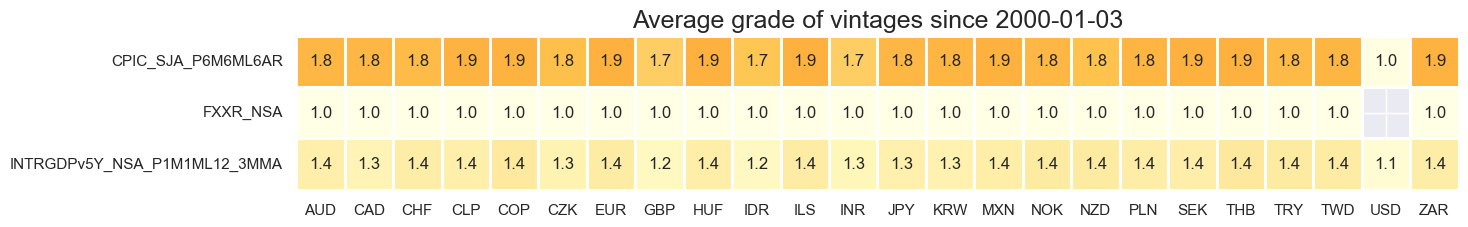

In [18]:
xcats_sel = ["INTRGDPv5Y_NSA_P1M1ML12_3MMA", "CPIC_SJA_P6M6ML6AR", "FXXR_NSA"]
msp.heatmap_grades(
    dfx,
    xcats=xcats_sel,
    cids=cids_em + cids_dm,
    start="2000-01-01",
    size=(15, 2),
)

# Pre-processing

## Create new category panels with `panel_calculator`

The `panel_calculator()` function in the `macrosynergy.panel` module simplifies applying transformations to each panel cross-section using a string-based formula. This function is very flexible and saves a lot of code when creating trading signals across multiple countries. To use the function, consider the category ticker as a panel dataframe and use standard Python and pandas expressions.

Panel category names not at the beginning or end of the string must always have a space before and after the name. Calculated category and panel operations must be separated by '='. Examples: "NEWCAT = ( OLDCAT1 + 0.5) * OLDCAT2" "NEWCAT = np.log( OLDCAT1 ) - np.abs( OLDCAT2 ) ** 1/2"

Note that the argument `cids` contains the cross-sections for which the new categories are to be calculated. If a cross-section is missing for any of the categories used, none of the new categories will be produced. This means if a specific calculation should be made for a smaller or larger set of cross-sections one must make a separate call to the function.

Below, we calculate plausible metrics of indicators or signals which can be used for analysis:
* intuitive growth trend 
* excess inflation versus a country's effective inflation target
* excess private credit growth
* excess real interest rate
* combination of the newly created indicators

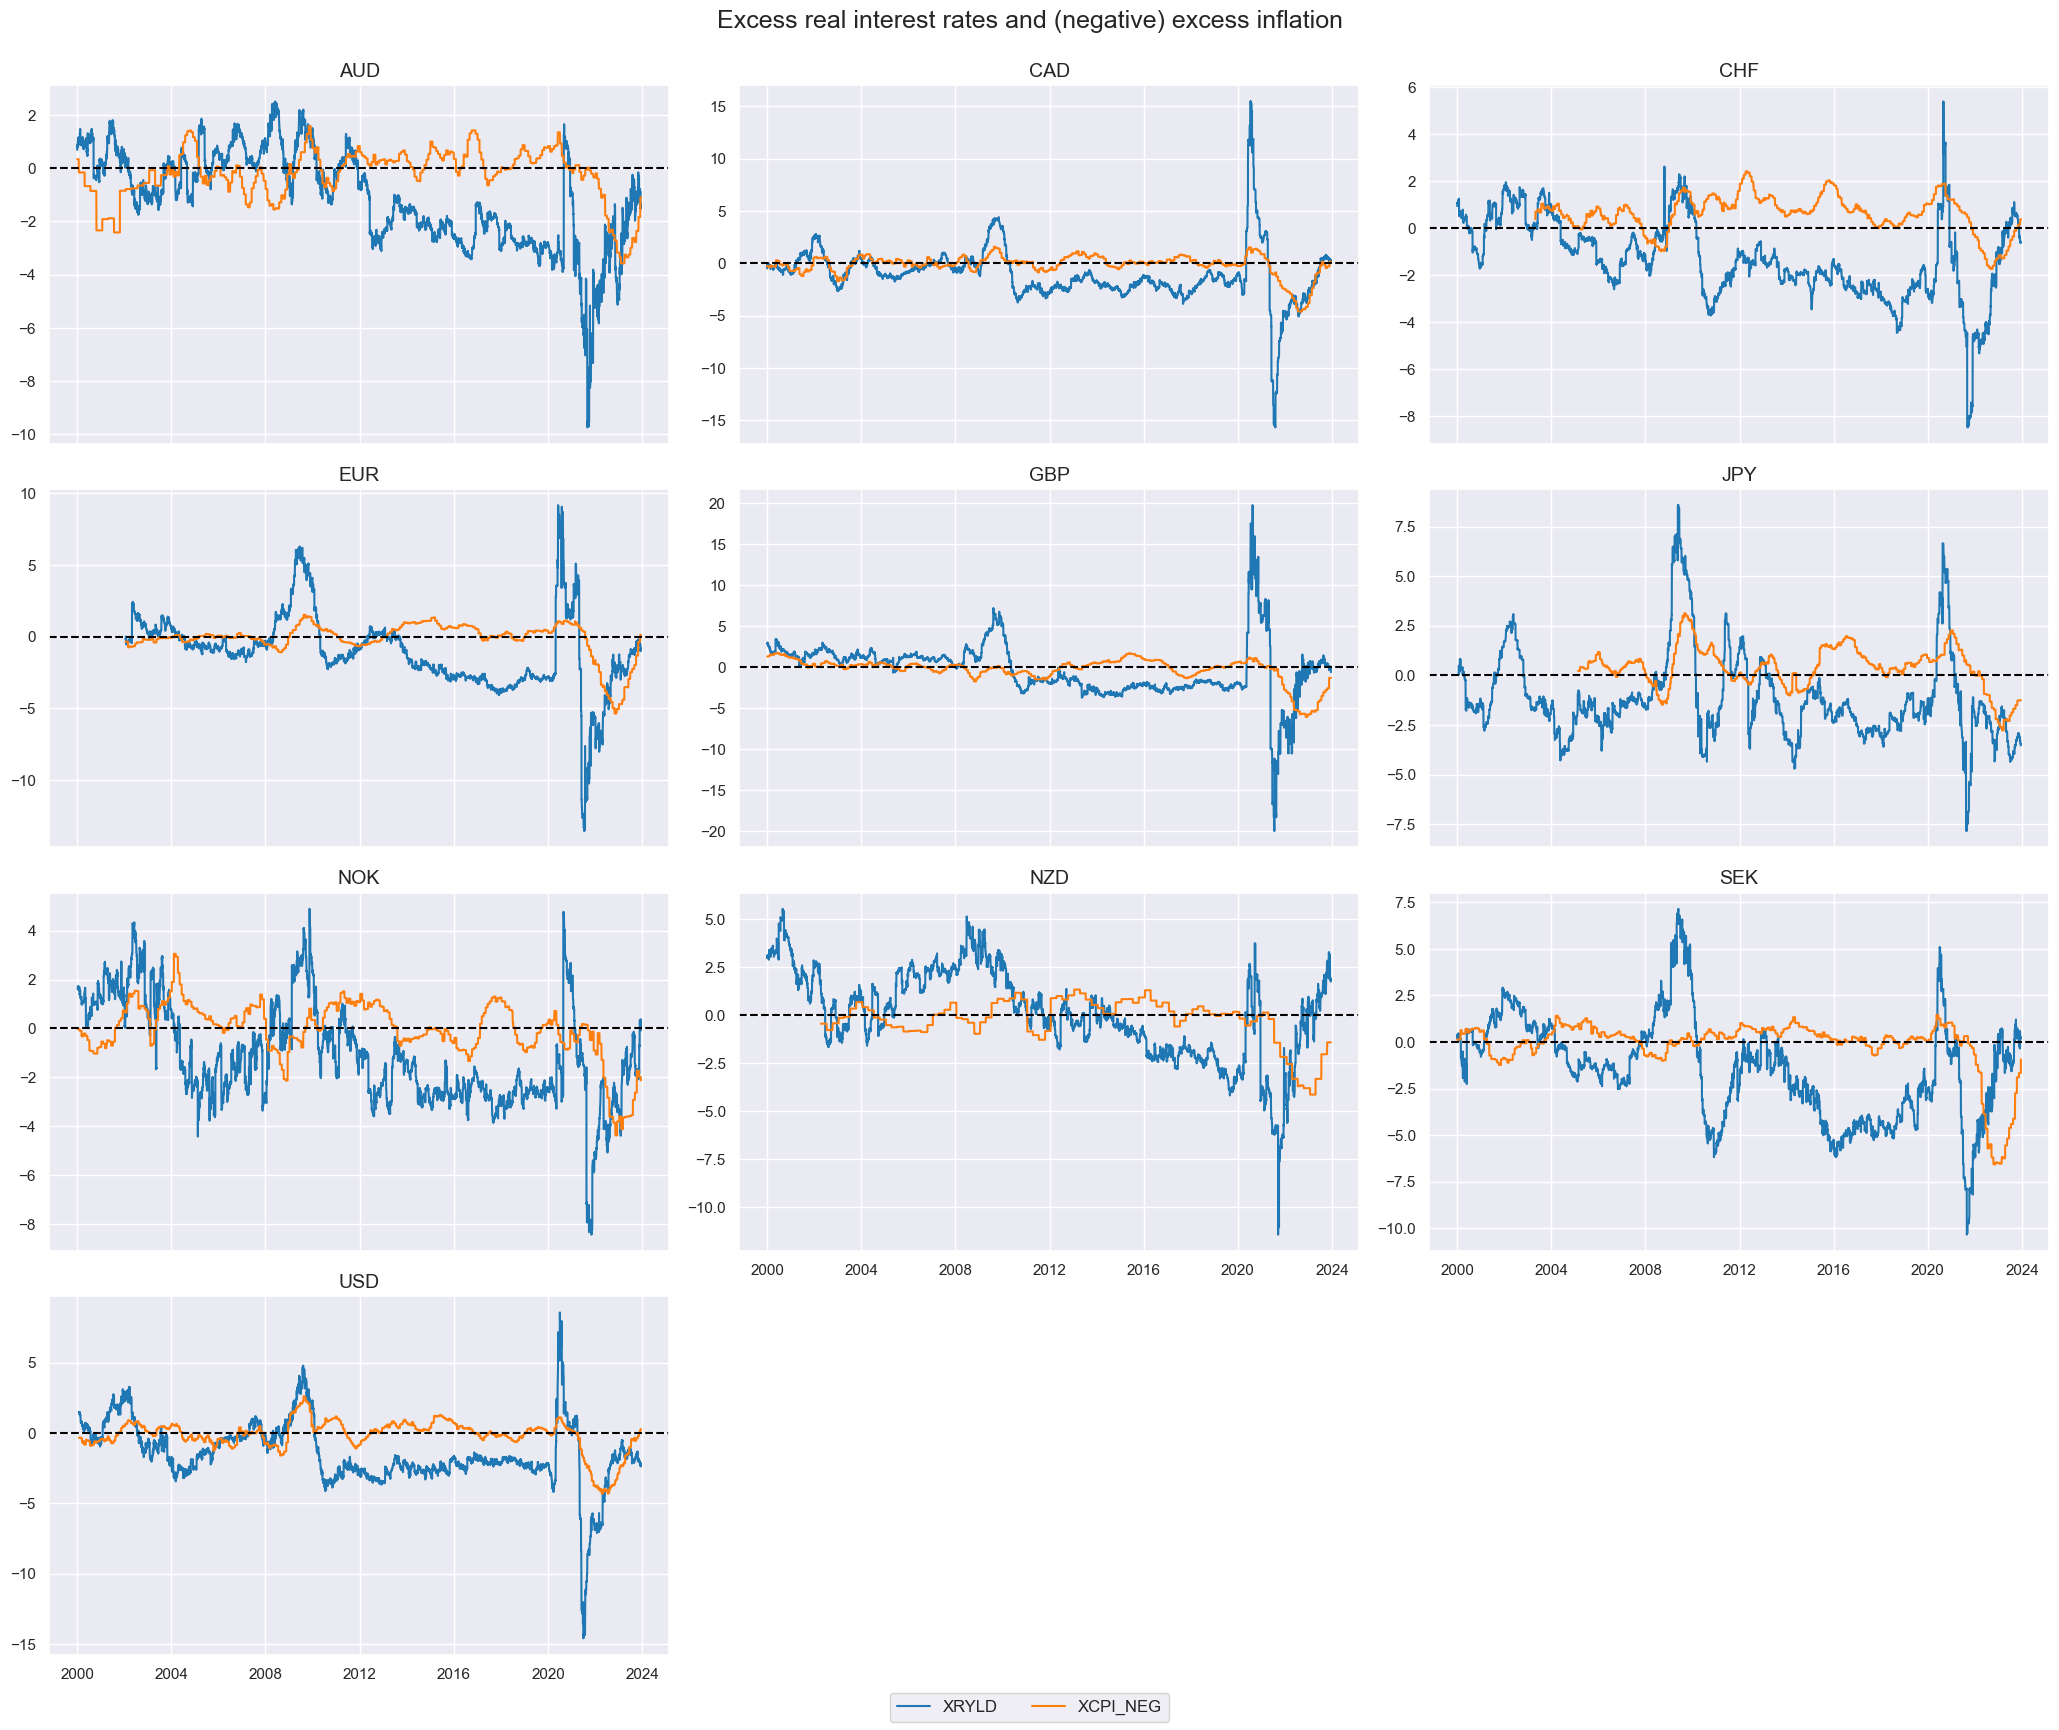

In [19]:
calcs = [
    "XGDP_NEG = - INTRGDPv5Y_NSA_P1M1ML12_3MMA", # intuitive growth trend
    "XCPI_NEG =  - ( CPIC_SJA_P6M6ML6AR + CPIH_SA_P1M1ML12 ) / 2 + INFTEFF_NSA", # excess inflation measure
  #  "XINF = CPIH_SA_P1M1ML12 - INFTEFF_NSA",  # excess inflation
    "XPCG_NEG = - PCREDITBN_SJA_P1M1ML12 + INFTEFF_NSA + RGDP_SA_P1Q1QL4_20QMA", # excess private credit growth
    "XRYLD = RYLDIRS05Y_NSA -  INTRGDP_NSA_P1M1ML12_3MMA",  # excess real interest rate
    "XXRYLD = XRYLD + XCPI_NEG",  # newly created panels can be used subsequently
]


dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)


xcats_sel = ["XRYLD", "XCPI_NEG"]


msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_dm,
    ncol=3,
    title="Excess real interest rates and (negative) excess inflation",
    start="2000-01-01",
    same_y=False,
   )

The `panel_calculator` function is also suitable for computing cross-section-specific relative economic performance by using a loop and f-strings. For example, here, we calculate absolute target deviations for a range of CPI inflation metrics for all markets.

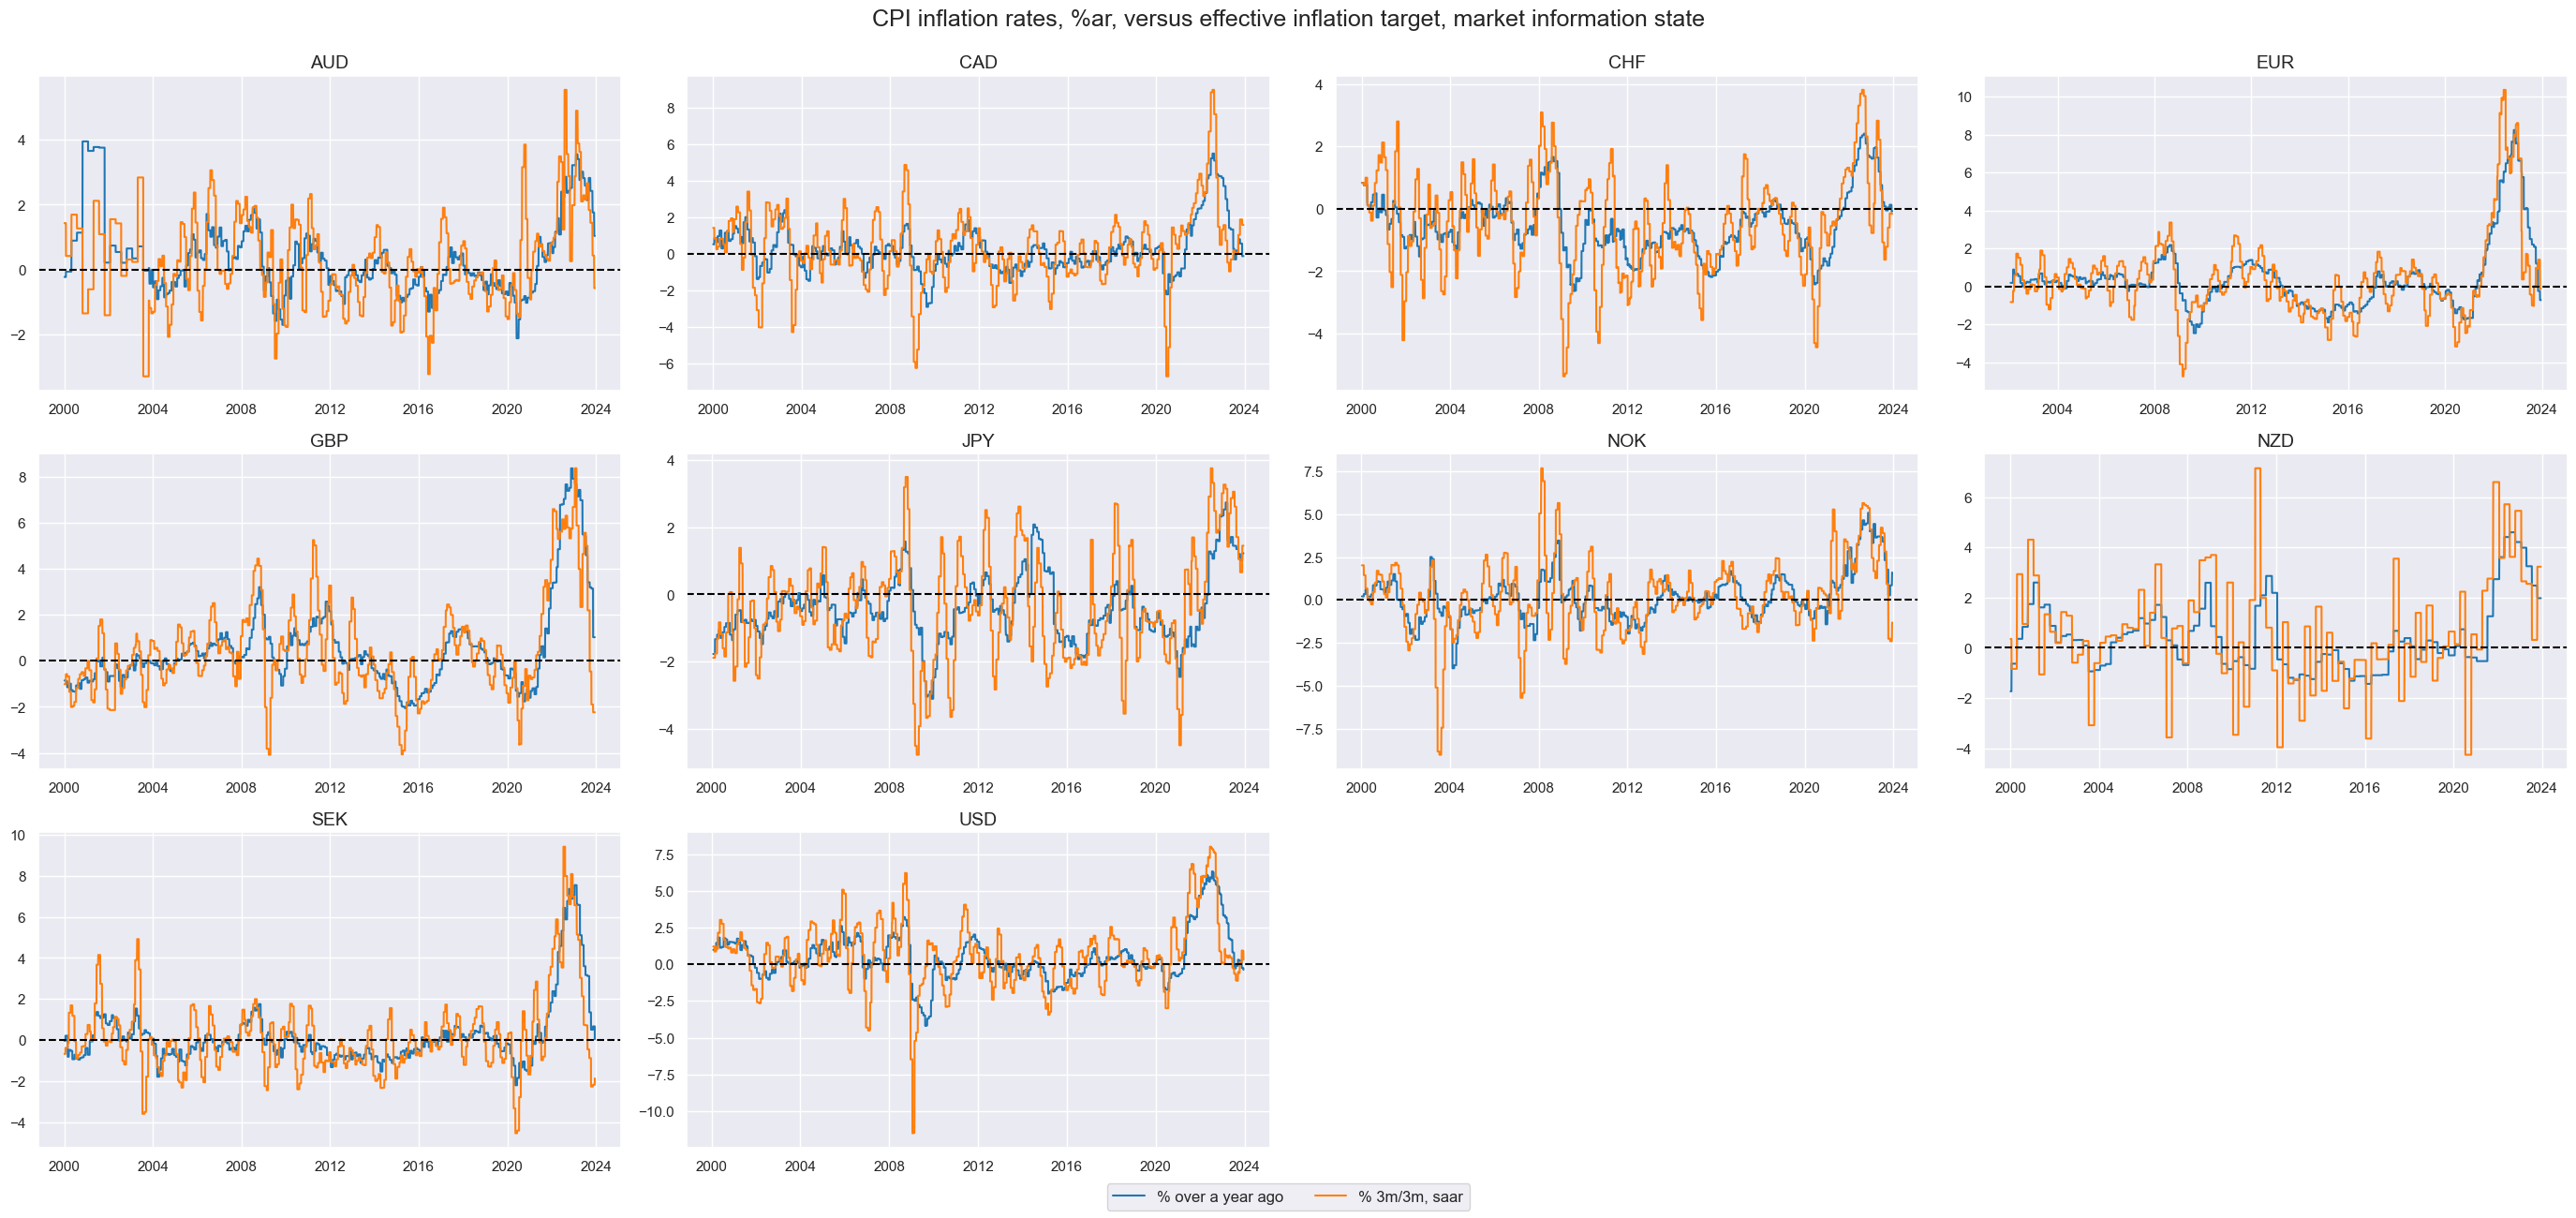

In [20]:
infs = ["CPIH_SA_P1M1ML12", "CPIH_SJA_P6M6ML6AR", "CPIH_SJA_P3M3ML3AR"]

for inf in infs:
    calcs = [
        f"{inf}vIET = ( {inf} - INFTEFF_NSA )",
    ]

    dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
    dfx = msm.update_df(dfx, dfa)


xcats_sel = ["CPIH_SA_P1M1ML12vIET", "CPIH_SJA_P3M3ML3ARvIET"]

msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_dm,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    all_xticks=True,
    title="CPI inflation rates, %ar, versus effective inflation target, market information state",
    xcat_labels=["% over a year ago", "% 3m/3m, saar"],
)

Panel calculation can use individual series by prepending an `i` to the ticker name. This ticker can have a cross-sections identifier that is not in the selection defined by `cids`

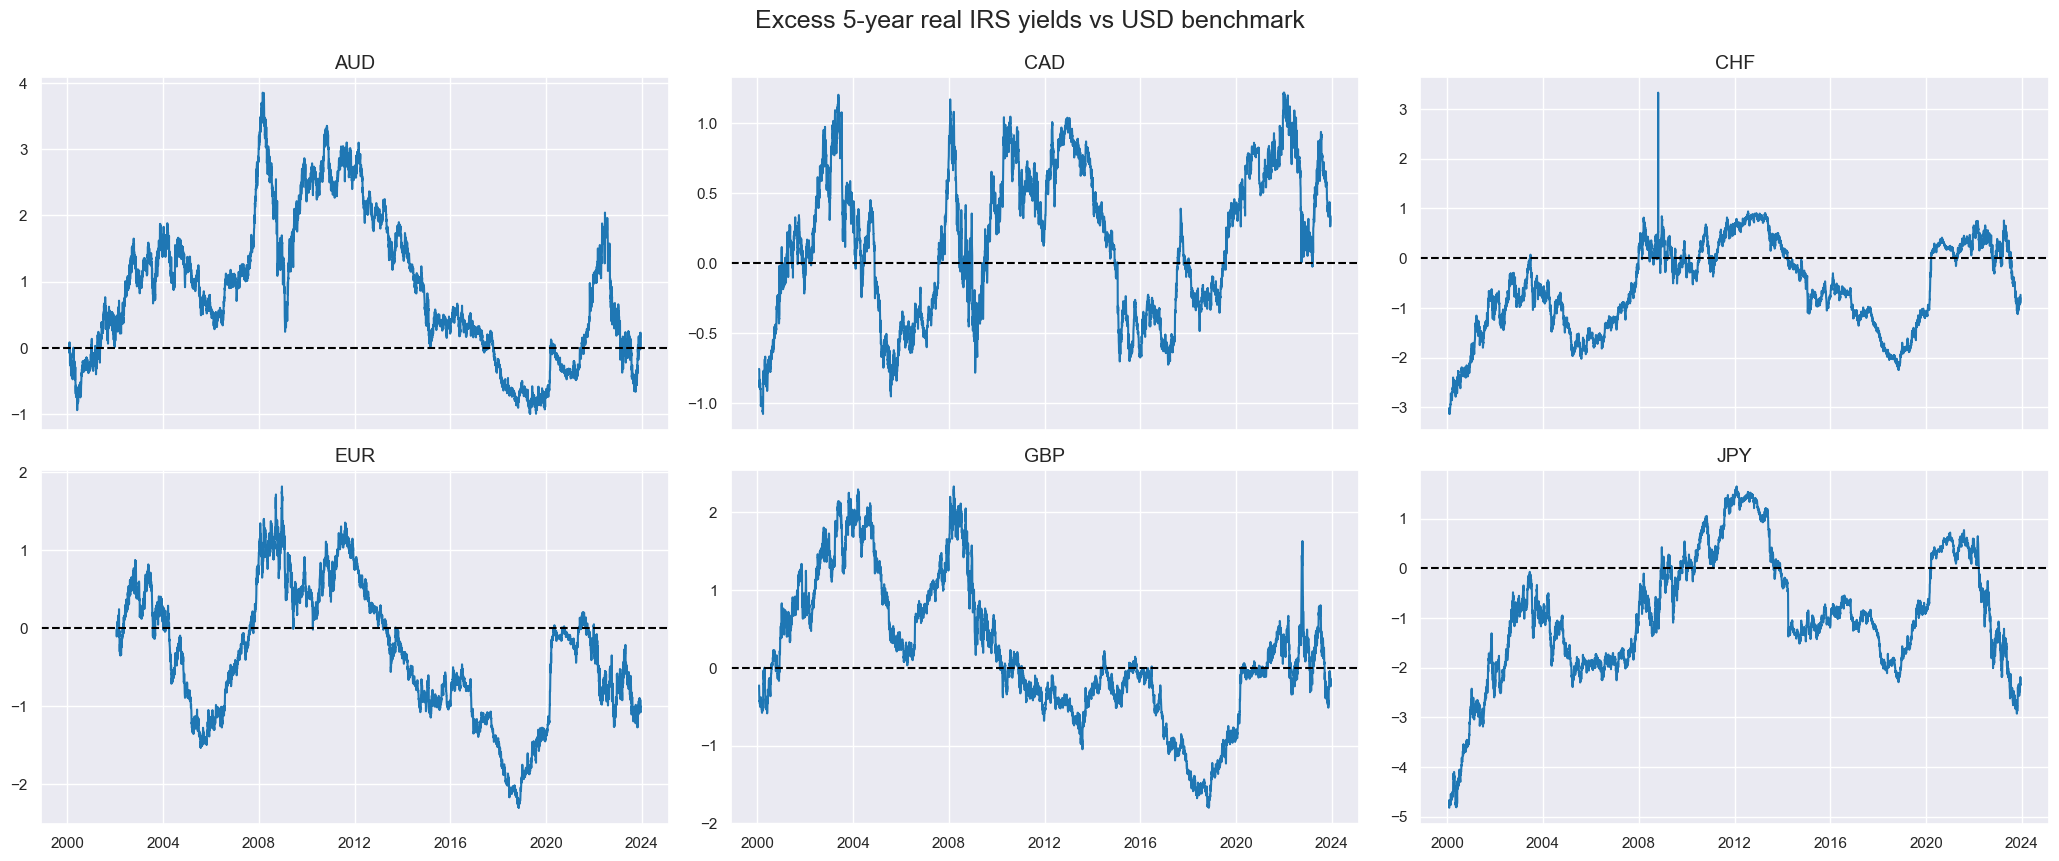

In [21]:
cids_sel = cids_dm[:6]
calcs = ["RYLDvUSD = RYLDIRS05Y_NSA -  iUSD_RYLDIRS05Y_NSA"]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_sel)
dfx = msm.update_df(dfx, dfa)

msp.view_timelines(
    dfx,
    xcats=["RYLDvUSD"],
    cids=cids_sel,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title = "Excess 5-year real IRS yields vs USD benchmark"

)

## Exclude series sections with `make_blacklist`

The `make_blacklist()` helper function creates a standardized dictionary of blacklist periods, i.e., periods that affect the validity of an indicator, based on standardized panels of binary categories, where values of 1 indicate a cause for blacklisting.

Put simply, this function allows converting category variables into blacklist dictionaries that can then be passed to other functions. Below, we picked two indicators for FX tradability and flexibility. `FXTARGETED_NSA` is an exchange rate target dummy, which takes a value of 1 if the exchange rate is targeted through a peg or any regime that significantly reduces exchange rate flexibility and 0 otherwise. `FXUNTRADABLE_NSA` is also a dummy variable that takes the value 1 if liquidity in the main FX forward market is limited or there is a distortion between tradable offshore and untradable onshore contracts.

Details on both categories are [here](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20tradeability%20and%20flexibility.php)

In [22]:
dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'CHF': (Timestamp('2011-10-03 00:00:00'), Timestamp('2015-01-30 00:00:00')),
 'CZK': (Timestamp('2014-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 'ILS': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-12-30 00:00:00')),
 'INR': (Timestamp('2000-01-03 00:00:00'), Timestamp('2004-12-31 00:00:00')),
 'THB': (Timestamp('2007-01-01 00:00:00'), Timestamp('2008-11-28 00:00:00')),
 'TRY_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2003-09-30 00:00:00')),
 'TRY_2': (Timestamp('2020-01-01 00:00:00'), Timestamp('2023-12-13 00:00:00'))}

Since 2000, roughly a third of the currencies covered by JPMaQS have seen their FX forward market affected either by an official exchange rate target, illiquidity, or convertibility-related distortions. The above output shows periods of disruptions for (primarily) emerging currencies. A notable developed market exception here is CHF, which was pegged between 2011 and 2016. 
A standard blacklist dictionary can be passed to several package functions that exclude the blacklisted periods from related analyses.
If one wishes to just exclude the blacklisted periods from a dataframe independent of specific applications, one can use the `reduce_df()` helper function.

In [23]:
dffx = df[df["xcat"] == "FXXR_NSA"]
print("Original shape: ", dffx.shape)
dffxx = msm.reduce_df(dffx, blacklist=fxblack)
print("Reduced shape: ", dffxx.shape)

Original shape:  (143067, 8)
Reduced shape:  (135885, 8)


## Concatenate dataframes with `update_df`

The `update_df` function in the `management` module concatenates two JPMaQS data frames and offers two conveniences. 
* It replaces duplicated tickers in the base data frame with those in the added data frame and re-indexes the output data frame.
* Additionally, you can replace categories in the base data frame by setting xcat_replace=True. This is useful when re-calculating the data panel of a category but not including all cross-sections of the original panel and wanting to avoid confusion by having two different calculation methods under the same category name.

In [24]:
dfa = msp.panel_calculator(
    dfx, calcs=["RYLD52 = RYLDIRS05Y_NSA - RYLDIRS02Y_NSA"], cids=cids_dm
)

dfx = msm.update_df(df=dfx, df_add=dfa)  # composite extended data frame
msm.missing_in_df(dfx, xcats=["RYLD52"], cids=cids_dm)  #quick check of missing values. Empty list means no missing values


No missing XCATs across DataFrame.
Missing cids for RYLD52:  []


## Compute panels versus basket with `make_relative_value`

The `make_relative_value()` function generates a data frame of relative values for a given list of categories. In this case, "relative" means that the original value is compared to a basket average. By default, the basket consists of all available cross-sections, and the relative value is calculated by subtracting the basket average from individual cross-section values.

By default, the function assumes that `complete_cross=False`, meaning that basket averages do not require the full set of cross-sections to be calculated for a specific date but are always based on the ones available at the time.

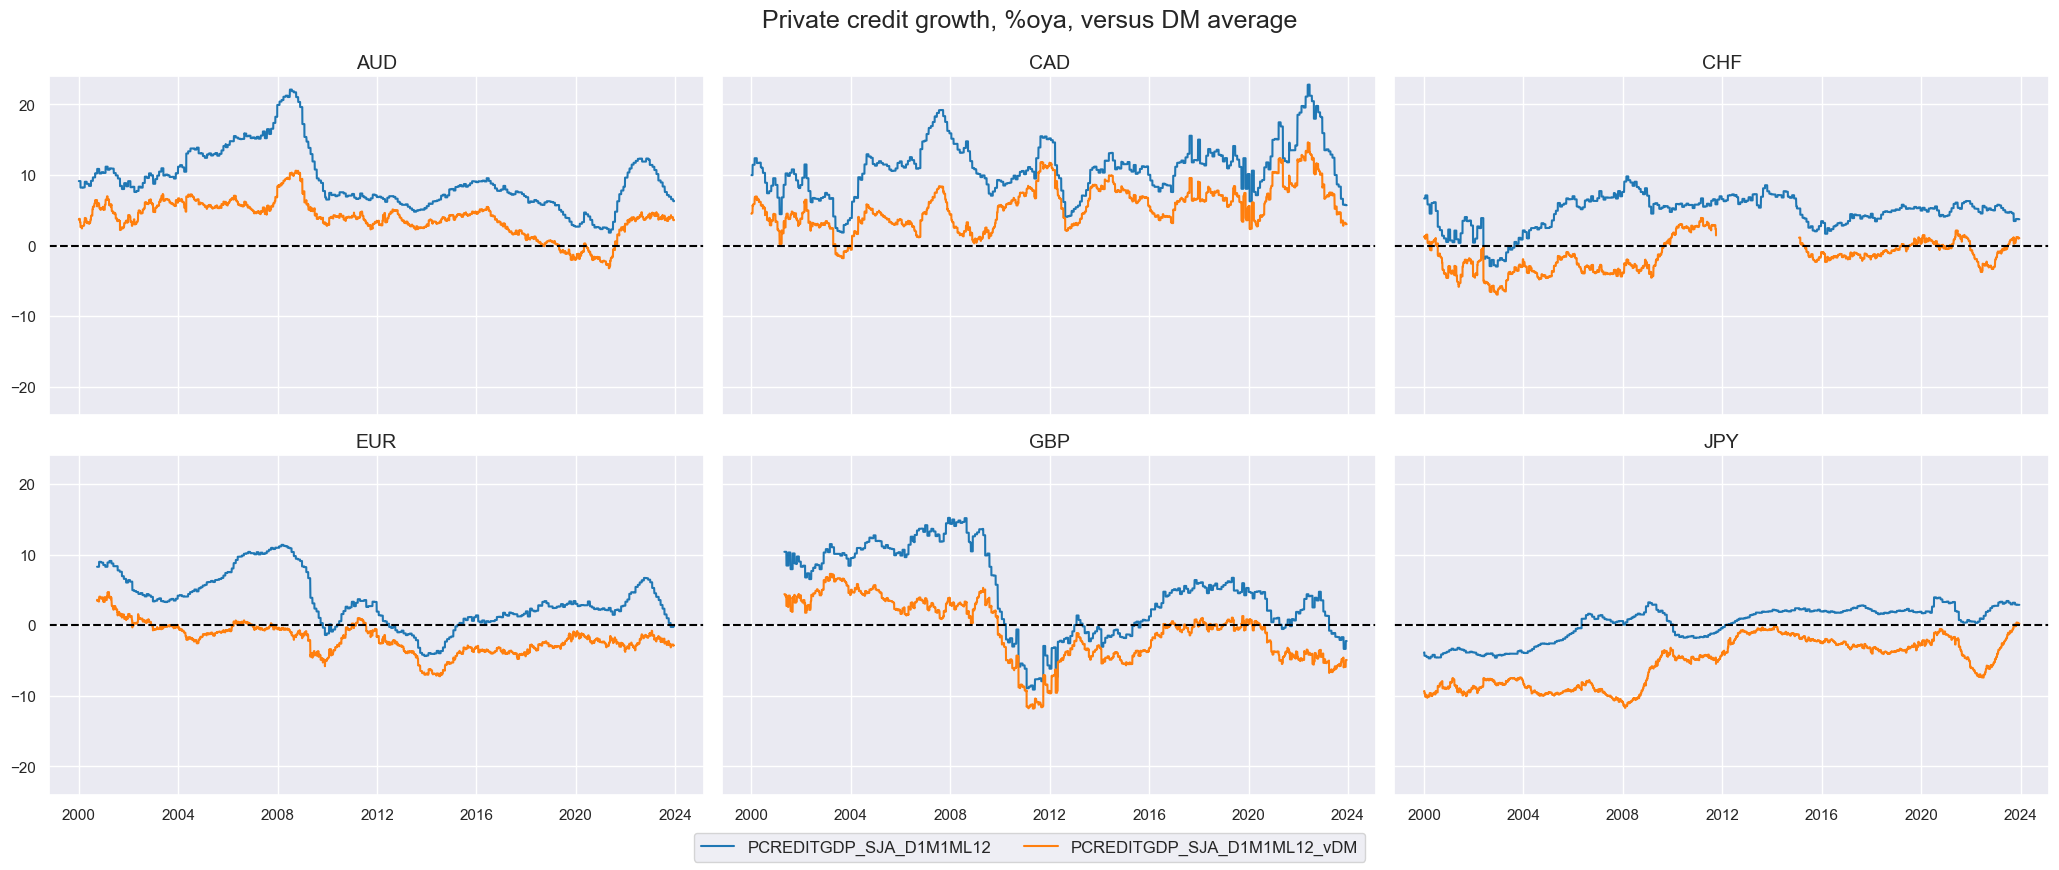

In [25]:
cids_sel = cids_dm[:6]
xcats_sel = ["PCREDITGDP_SJA_D1M1ML12"]
dfy = msp.make_relative_value(
    dfx,
    xcats=["PCREDITGDP_SJA_D1M1ML12"],
    cids=cids_sel,
    start="2000-01-01",
    blacklist=fxblack,  # cross-sections can be blacklisted for calculation and basket use
    rel_meth="subtract",
    complete_cross=False,  # cross-sections do not have to be complete for basket calculation
    postfix="_vDM",
)

dfx = msm.update_df(df=dfx, df_add=dfy)  # composite extended data frame

dfj = pd.concat([dfx[dfx["xcat"].isin(xcats_sel)], dfy])

xcats_sel = ["PCREDITGDP_SJA_D1M1ML12", "PCREDITGDP_SJA_D1M1ML12_vDM"]
msp.view_timelines(
    dfj,
    xcats=xcats_sel,
    cids=cids_sel,
    ncol=3,
    start="2000-01-01",
    same_y=True,
    title = "Private credit growth, %oya, versus DM average"
)

By default, the basket comprises all available cross-sections for every period, as defined by the `cids` argument. However, it is possible to limit the basket to a subset or a single cross-section by using the `basket=[...]` argument.

In the `make_relative_value()` function, an important decision is the use of the blacklist argument. This argument takes a dictionary of cross-sections and date ranges that should be excluded from the output created by the `make_blacklist()` function. Excluding invalid or distorted data is crucial when calculating relative values because a single cross-section's distortion can invalidate all cross-sectional relative values.

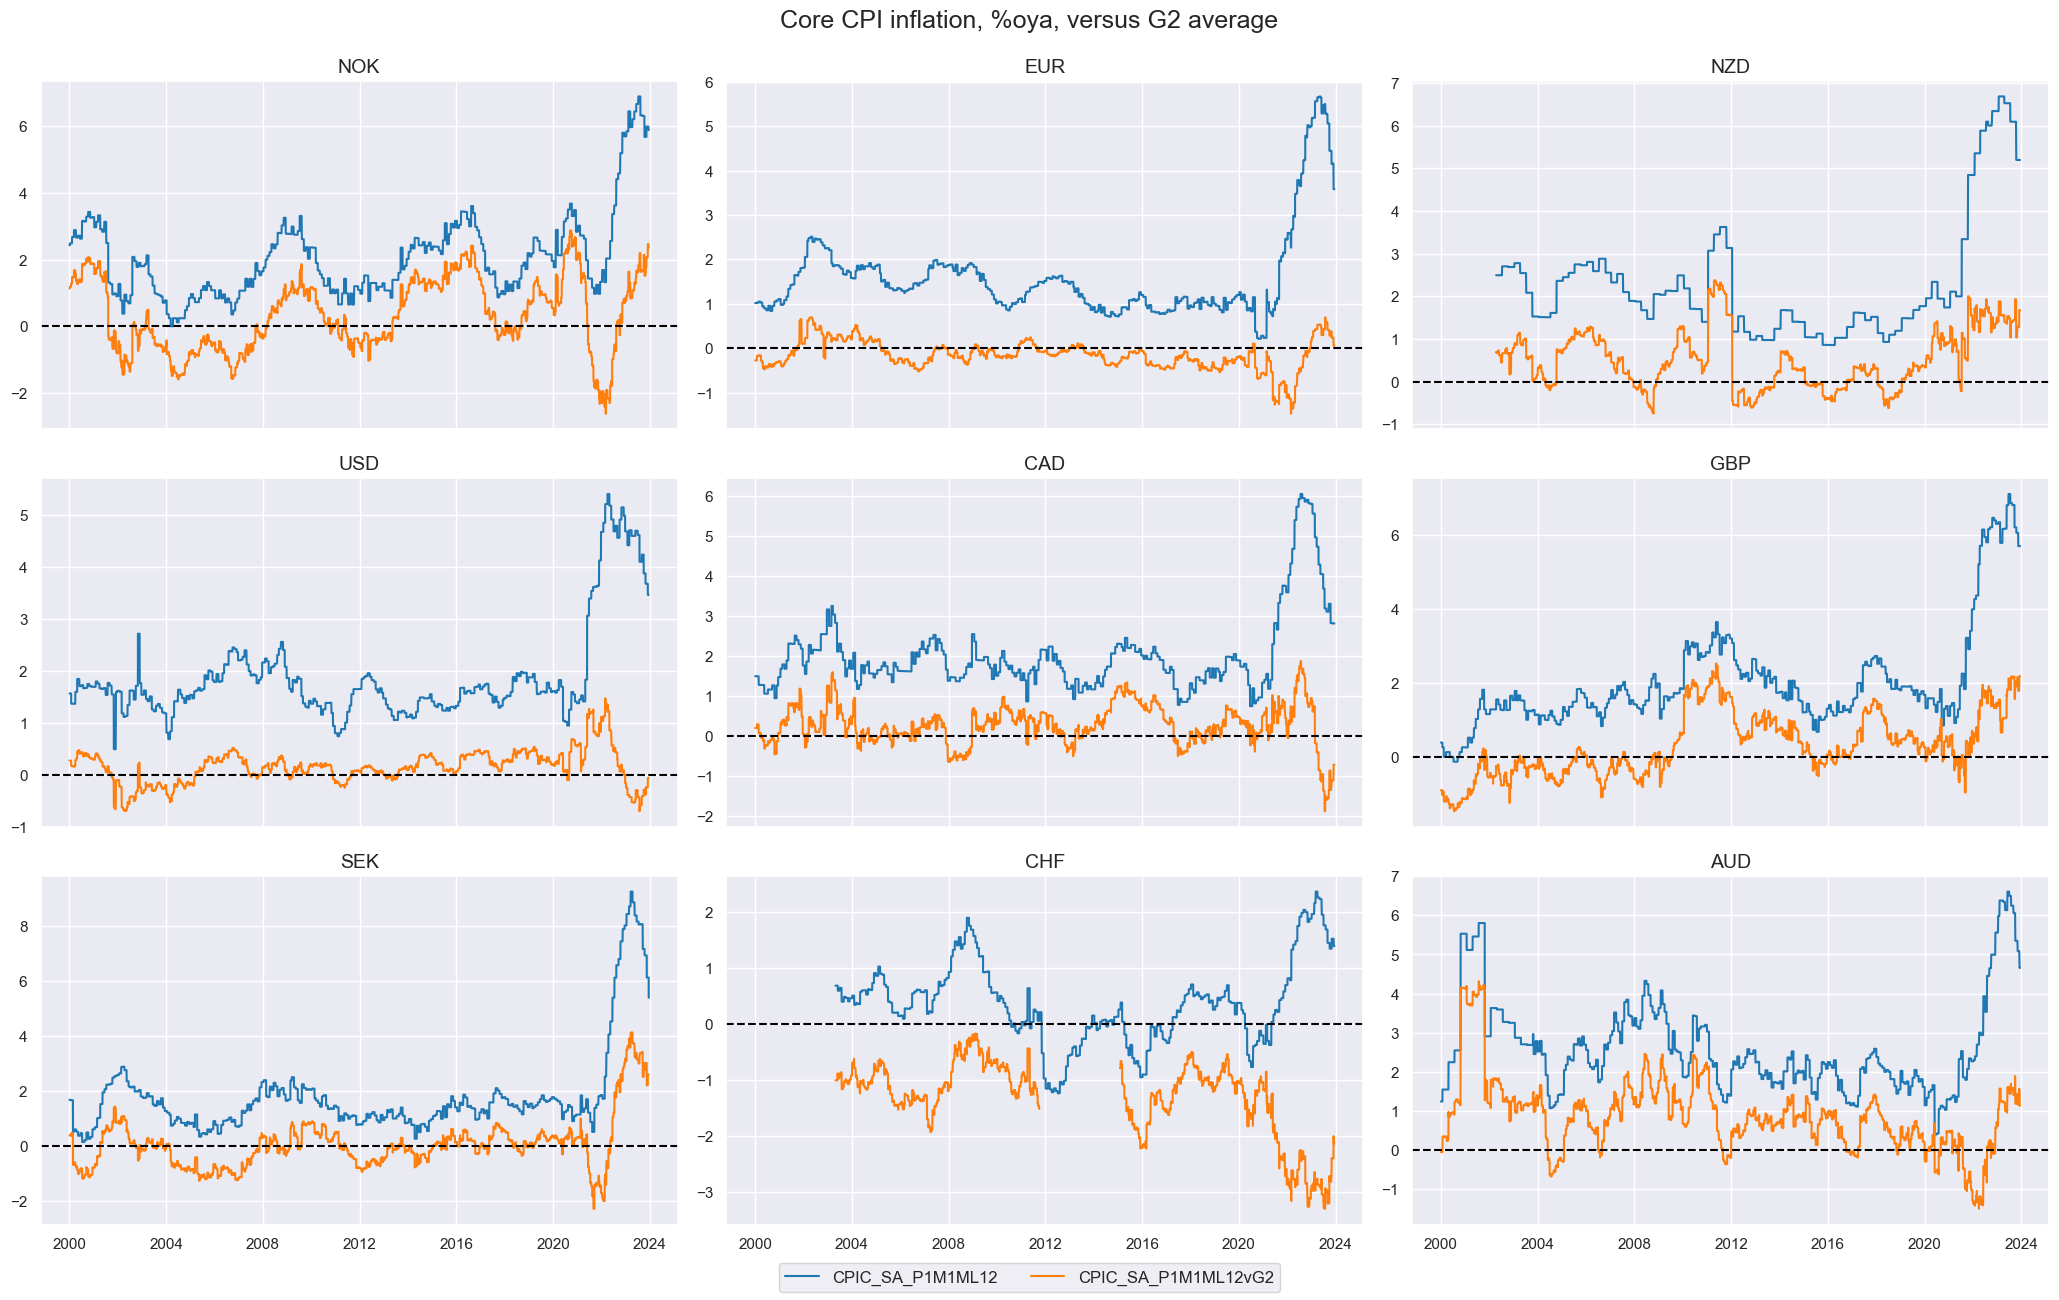

In [26]:
cids_sel = (list(set(cids_dm) - set(["JPY"])))

xcats_sel = ["CPIC_SA_P1M1ML12"]
dfy = msp.make_relative_value(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    start="2000-01-01",
    blacklist=fxblack,  # remove invalid observations
    basket=["EUR", "USD"],  # basket does not use all cross-sections
    rel_meth="subtract",
    postfix="vG2",
)
dfx = msm.update_df(df=dfx, df_add=dfy)  # composite extended data frame

#dfj = pd.concat([dfx[dfx["xcat"].isin(xcats_sel)], dfy])

msp.view_timelines(
    dfx,
    xcats=["CPIC_SA_P1M1ML12", "CPIC_SA_P1M1ML12vG2"],
    cids=cids_sel,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title="Core CPI inflation, %oya, versus G2 average",
    
 )

## Normalize panels with `make_zn_scores`

The `make_zn_scores()` function is a method for normalizing values across different categories. This is particularly important when summing or averaging categories with different units and time series properties. The function computes z-scores for a category panel around a specified neutral level that may be different from the mean. The term "zn-score" refers to the normalized distance from the neutral value.

The default mode of the function calculates scores based on sequential estimates of means and standard deviations, using only past information. This is controlled by the `sequential=True` argument, and the minimum number of observations required for meaningful estimates is set with the `min_obs` argument. By default, the function calculates zn-scores for the initial sample period defined by `min_obs` on an in-sample basis to avoid losing history.

The means and standard deviations are re-estimated daily by default, but the frequency of re-estimation can be controlled with the `est_freq` argument, which can be set to weekly, monthly, or quarterly.


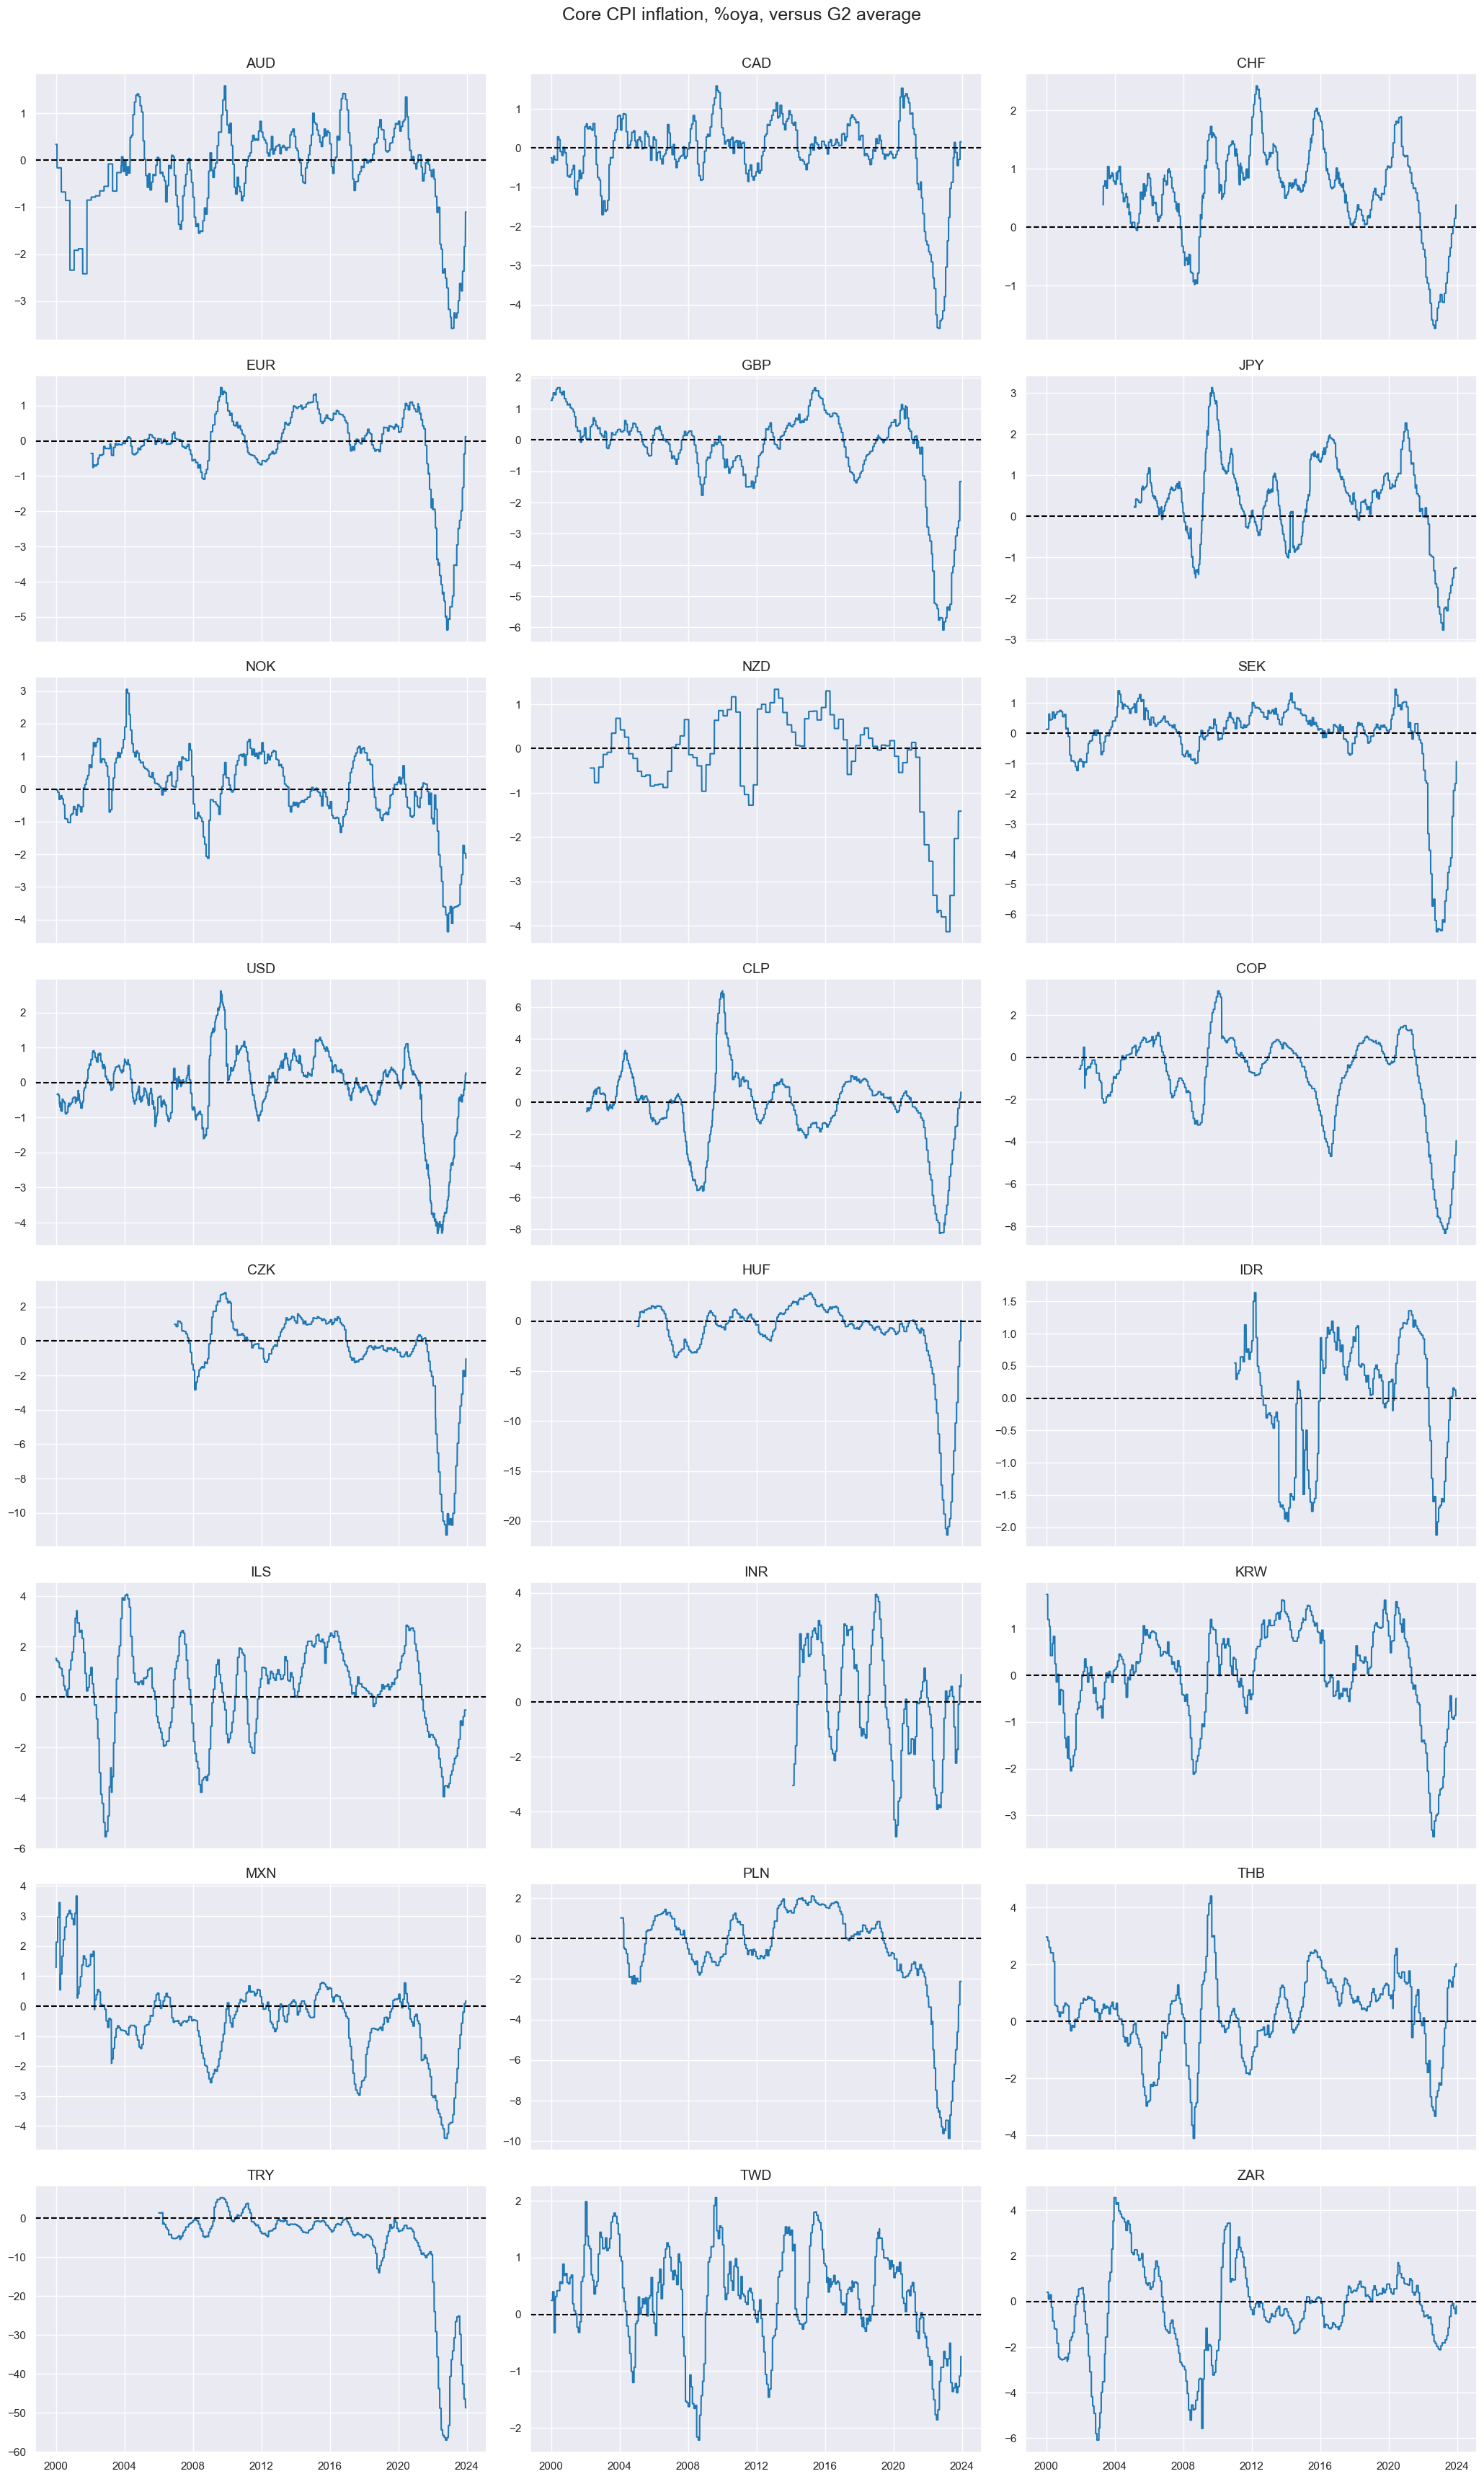

In [27]:
msp.view_timelines(
    dfx,
    xcats=["XCPI_NEG"],
    cids=cids,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title="Core CPI inflation, %oya, versus G2 average",
    
 )


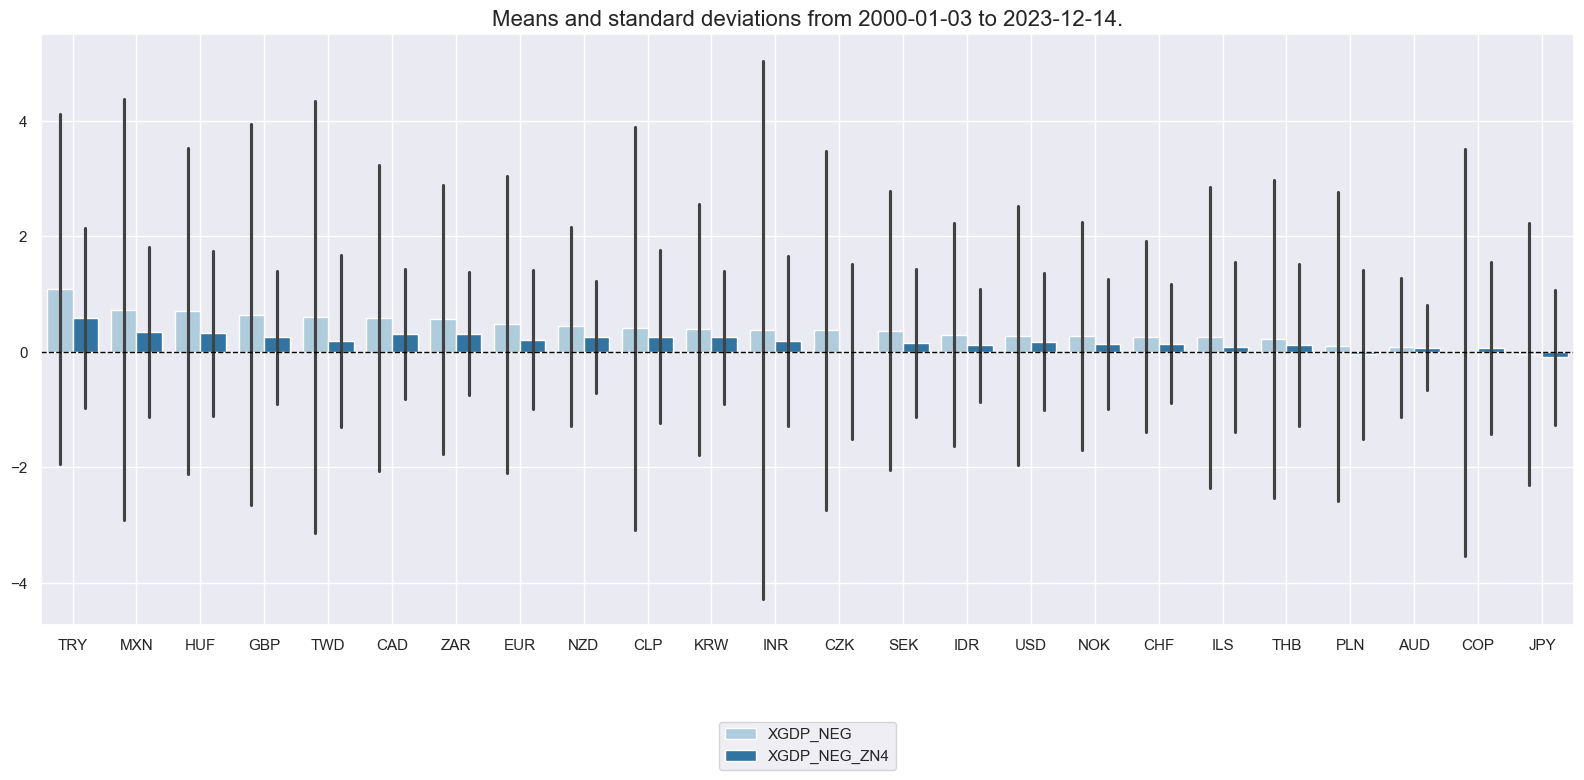

In [28]:
macros = ["XGDP_NEG", "XCPI_NEG", "XPCG_NEG", "RYLDIRS05Y_NSA"]
xcatx = macros

for xc in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cids,
        neutral="zero",
        thresh=3,
        est_freq="M",
        pan_weight=1,
        postfix="_ZN4",
    )
    dfx = msm.update_df(dfx, dfa)

msp.view_ranges(
    dfx,
    xcats=["XGDP_NEG", "XGDP_NEG_ZN4"],
    kind="bar",
    sort_cids_by="mean",
    start="2000-01-01",
   
)

Important parameters that shape the nature of the zn-scores are:
* `neutral` sets the level dividing positive and negative scores. The choices are `'zero'`, `'mean'`, or `'median'`.
* `pan_weight` sets the panel's importance versus the individual cross-sections for scaling the zn-scores. If the category is assumed to be homogeneous across countries regarding its signal, the weight can be close to 1 (whole panel data are the basis for the parameters). If countries are not comparable regarding category means and/or standard deviation and panel weight close to zero is preferable (parameters are all specific to cross-section). The default value is 1.
* `thresh` sets the cutoff value (threshold) for winsorization in terms of standard deviations. The minimum value is 1. Setting thresh to values close to 1 will exclude particular high volatility periods from the sample. For the example above, only TRY will be affected by applying the threshold of 2.

(1, 2)


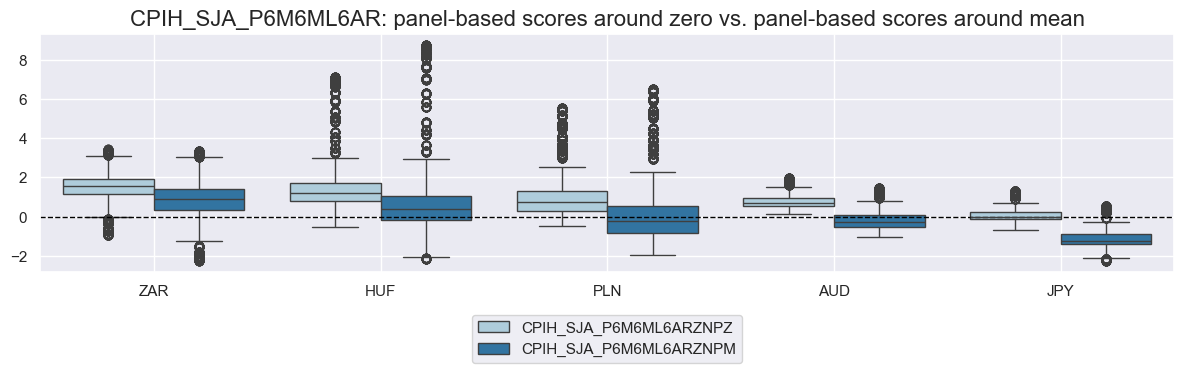

(2, 3)


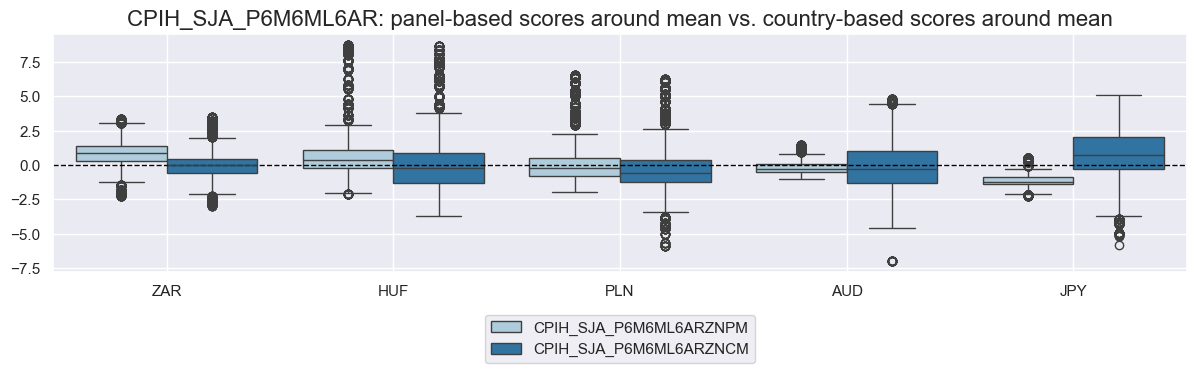

(1, 4)


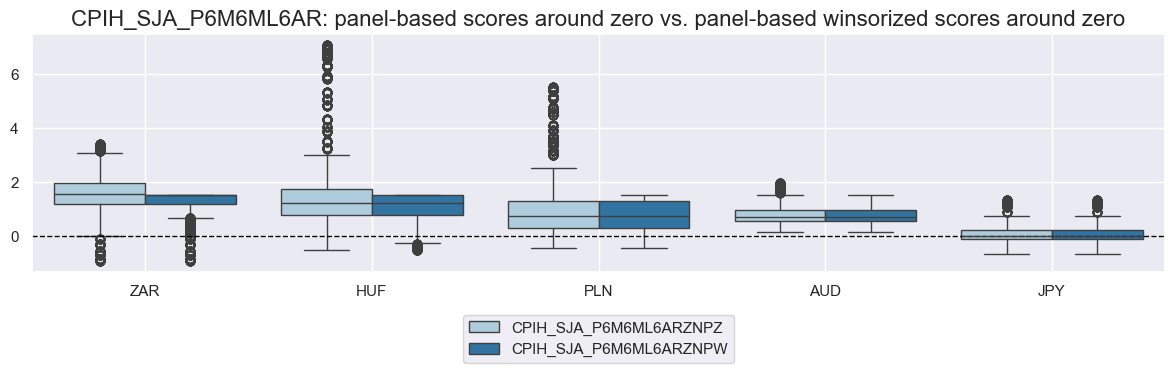

In [29]:
xcat = "CPIH_SJA_P6M6ML6AR"
cids_sel = ["ZAR", "HUF", "PLN", "AUD", "JPY"]
dict_ps = {  # dictionary of zn-score specs
    1: {
        "neutral": "zero",
        "pan_weight": 1,
        "thresh": None,
        "postfix": "ZNPZ",
        "label": "panel-based scores around zero",
    },
    2: {
        "neutral": "mean",
        "pan_weight": 1,
        "thresh": None,
        "postfix": "ZNPM",
        "label": "panel-based scores around mean",
    },
    3: {
        "neutral": "mean",
        "pan_weight": 0,
        "thresh": None,
        "postfix": "ZNCM",
        "label": "country-based scores around mean",
    },
    4: {
        "neutral": "zero",
        "pan_weight": 1,
        "thresh": 1.5,
        "postfix": "ZNPW",
        "label": "panel-based winsorized scores around zero",
    },
}

dfy = pd.DataFrame(columns=df.columns)

for dvs in dict_ps.values():
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xcat,
        cids=cids_sel,
        sequential=True,
        neutral=dvs["neutral"],
        pan_weight=dvs["pan_weight"],
        thresh=dvs["thresh"],
        postfix=dvs["postfix"],
        est_freq="m",
    )
    dfy = msm.update_df(dfy, dfa)

#dfy = msm.update_df(dfy, dfa)

compares = [(1, 2), (2, 3), (1, 4)]

for comps in compares:
    print(comps)
    dv1 = dict_ps[comps[0]]
    dv2 = dict_ps[comps[1]]

    msp.view_ranges(
        dfy,
        xcats=[f"{xcat}{dv1['postfix']}", f"{xcat}{dv2['postfix']}"],
        kind="box",
        sort_cids_by="mean",
        start="2000-01-01",
        size=(12, 4),
        title=f"{xcat}: {dv1['label']} vs. {dv2['label']}",
    )

## Estimate asset return elasticities with `return_beta`

The function `return_beta()` estimates betas (elasticities) of a return category to a benchmark. It returns either just the betas or hedged returns of the cross-sections. Hedged returns are returns on a composite position on the principal contract and the benchmark to offset the elasticity of the former with respect to the latter. At present, the only method used to calculate the beta is a simple OLS regression. If `oos` is set to True (default), the function calculates hedge ratios out of sample, i.e., for each period based on estimates up to the previous period. The related re-estimation frequency is set with `refreq` (default monthly). The re-estimation is conducted at the end of the period and used as a hedge ratio for all days in the following period. The argument `min_obs` sets the minimum number of observations, after which the hedging ratio is initially calculated. If the betas are estimated out of sample, calculations are only done for periods after the minimum number of periods are available.

In [30]:
dfx = dfx[["cid", "xcat", "real_date", "value"]]
cids_sel = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK"]
dfh = msp.return_beta(
    dfx,
    xcat="FXXR_NSA",
    cids=cids_sel,
    benchmark_return="USD_EQXR_NSA",
    oos=False,
    hedged_returns=True,
    start="2002-01-01",
    refreq="m",
)
dfh

dfx = msm.update_df(df=dfx, df_add=dfh)
#dfx["xcat"].unique()

The auxiliary function `hedge_ratio_display()` visualizes the hedge ratios estimated by the `hedge_ratio()` function. 

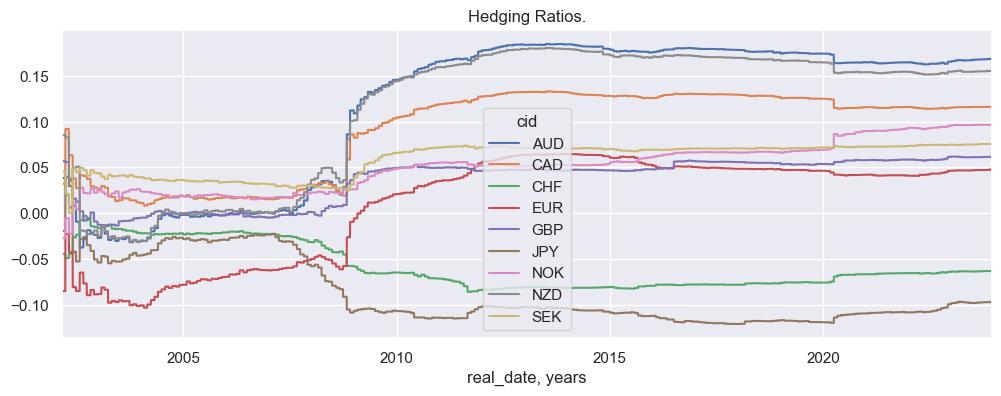

In [31]:
sns.set(rc={"figure.figsize": (12, 4)})
msp.beta_display(dfh)

Hedged returns vs un-hedged returns can be displayed using `view_timelines()` function:

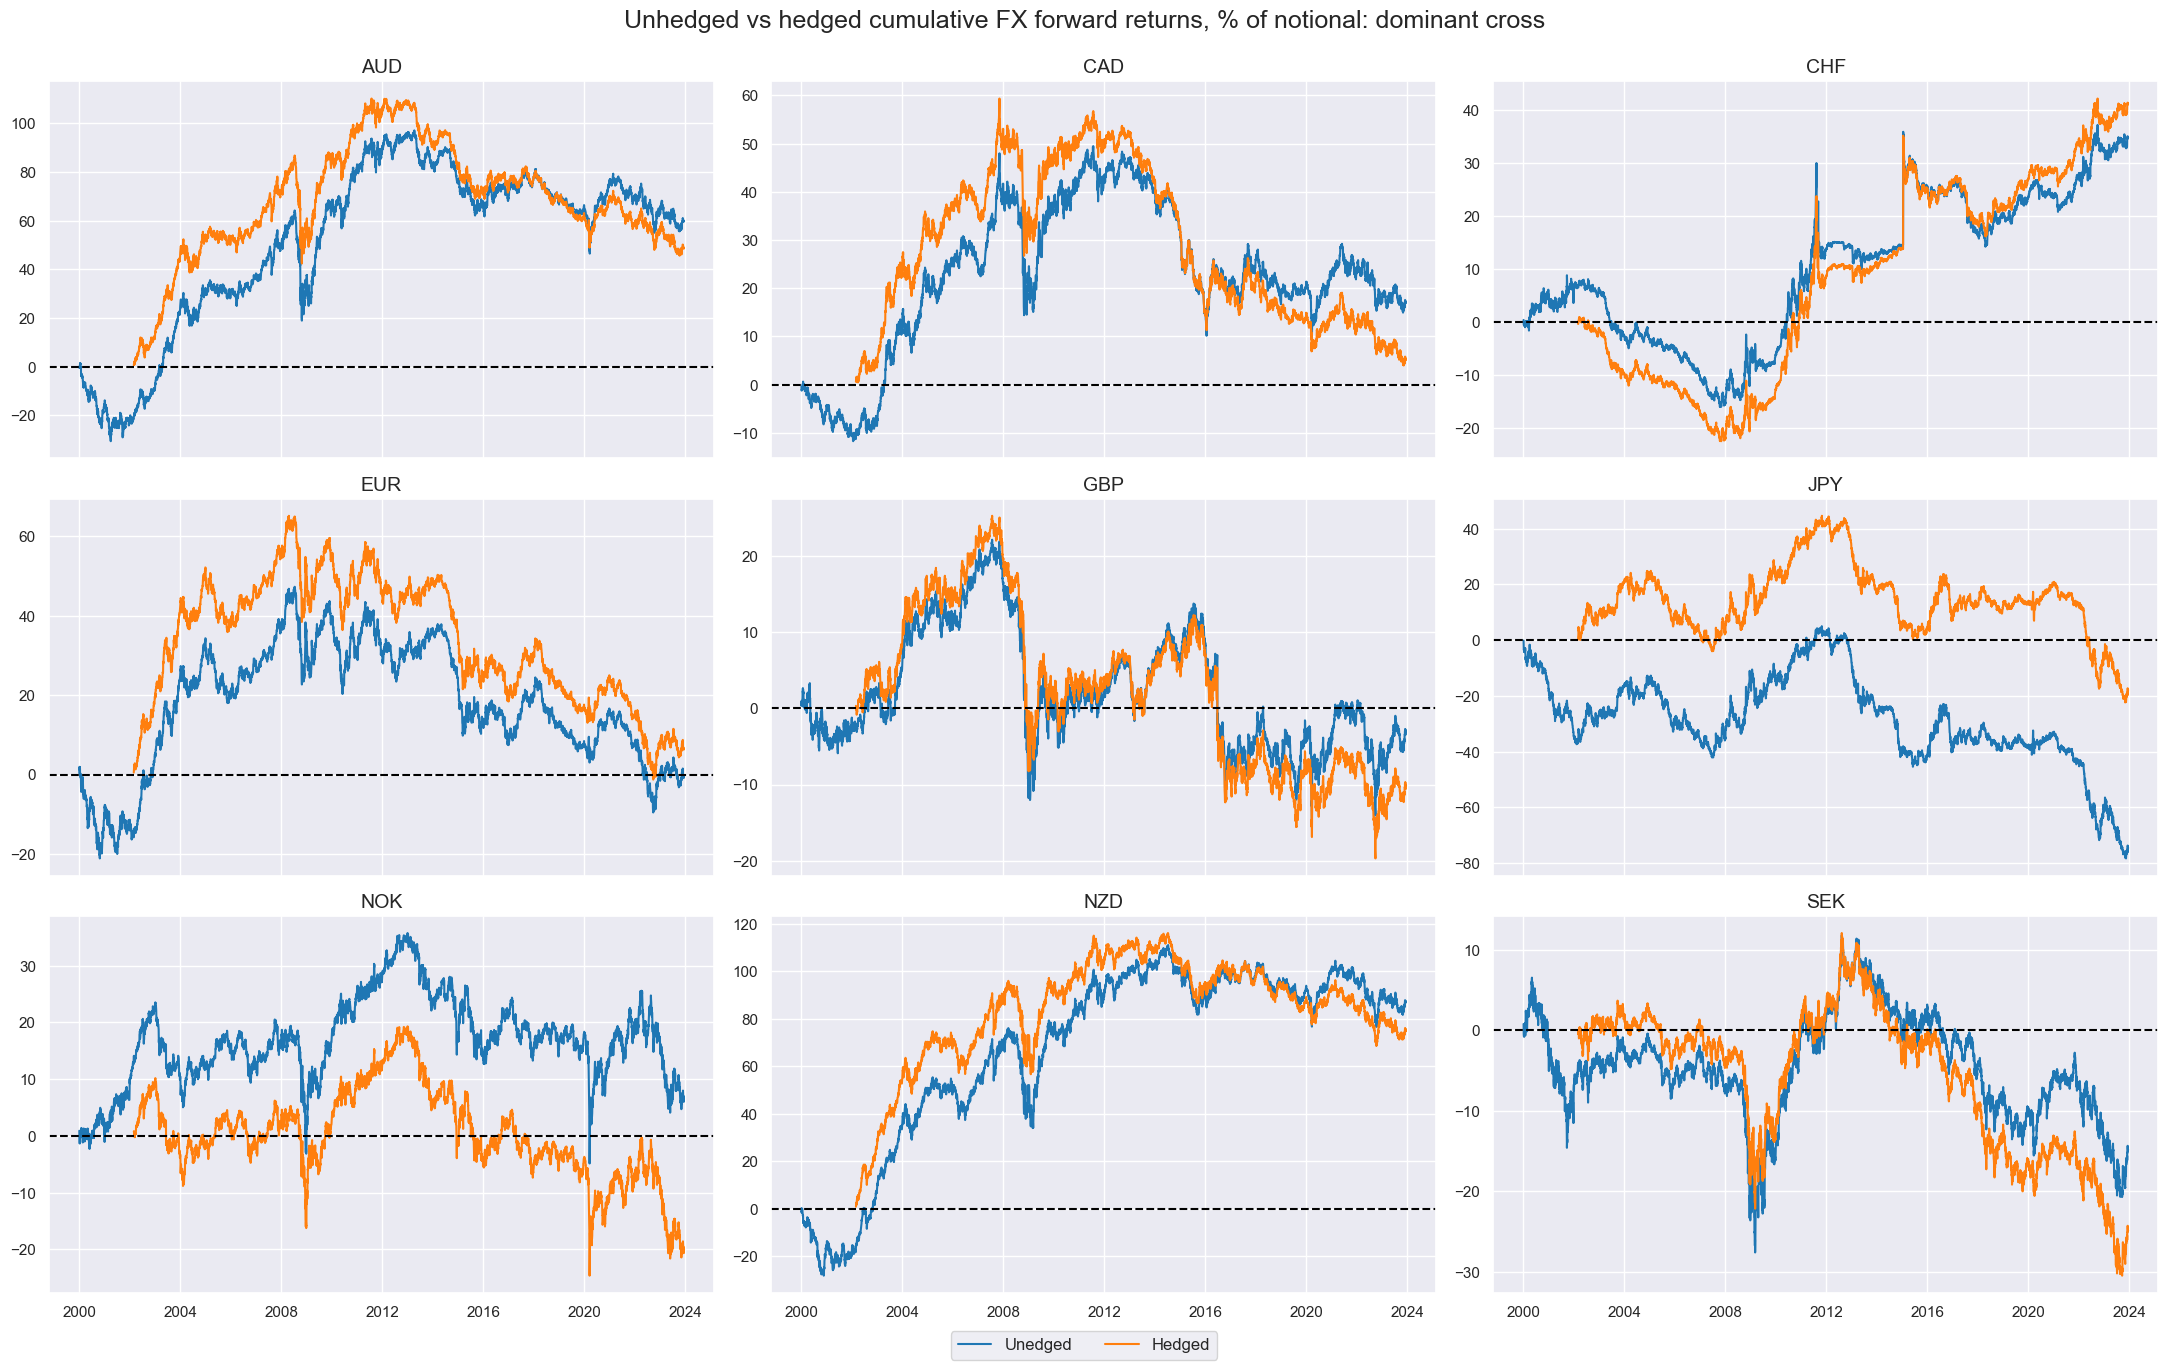

In [32]:
xcats_sel = ["FXXR_NSA", "FXXR_NSA_H"]

msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    ncol=3,
    cumsum=True,
    start="2000-01-01",
    same_y=False,
    all_xticks=False,
    title="Unhedged vs hedged cumulative FX forward returns, % of notional: dominant cross",
    xcat_labels=["Unedged", "Hedged"],
    height=3,
)

## Generate returns (and carry) of a group of contracts with `Basket`

The `Basket` class supports the calculation of returns and carry of groups of financial contracts using
various weighting methods. The main argument is a list of contracts. It is very important to specify any invalid blacklisted periods associated with any of the cross-sections, as these invalid numbers would contaminate the whole basket.

In the below example, we instantiate a `Basket` object for a group of FX forward returns.

In [33]:
cids_fxcry = ["AUD", "INR", "NZD", "PLN", "TWD", "ZAR"]

ctrs_fxcry = [cid + "_FX" for cid in cids_fxcry]
basket_fxcry = msp.Basket(
    dfx,
    contracts=ctrs_fxcry,
    ret="XR_NSA",
    cry="CRR_NSA",
    start="2010-01-01",
    end="2023-01-01",
    blacklist=fxblack,
)
for attribute, value in basket_fxcry.__dict__.items():
    if not isinstance(
        value, (pd.DataFrame, dict)
    ):  # print all non-df and non-dictionary attributes
        print(attribute, " = ", value)

_as_categorical  =  False
contracts  =  ['AUD_FX', 'INR_FX', 'NZD_FX', 'PLN_FX', 'TWD_FX', 'ZAR_FX']
ret  =  XR_NSA
ticks_ret  =  ['AUD_FXXR_NSA', 'INR_FXXR_NSA', 'NZD_FXXR_NSA', 'PLN_FXXR_NSA', 'TWD_FXXR_NSA', 'ZAR_FXXR_NSA']
cry_flag  =  True
ticks_cry  =  ['AUD_FXCRR_NSA', 'INR_FXCRR_NSA', 'NZD_FXCRR_NSA', 'PLN_FXCRR_NSA', 'TWD_FXCRR_NSA', 'ZAR_FXCRR_NSA']
cry  =  ['CRR_NSA']
wgt_flag  =  False
ticks_wgt  =  []
dfws_wgt  =  None
tickers  =  ['AUD_FXXR_NSA', 'INR_FXXR_NSA', 'NZD_FXXR_NSA', 'PLN_FXXR_NSA', 'TWD_FXXR_NSA', 'ZAR_FXXR_NSA', 'AUD_FXCRR_NSA', 'INR_FXCRR_NSA', 'NZD_FXCRR_NSA', 'PLN_FXCRR_NSA', 'TWD_FXCRR_NSA', 'ZAR_FXCRR_NSA']
start  =  2010-01-01
end  =  2023-01-01


The `make_basket` method calculates and stores all performance metrics, i.e., returns and carry, for a specific weighting method of the basket. The different weighting options available provide flexibility in constructing a composite measure that meets specific needs or objectives:

`equal`: all contracts with non-NA returns have the same weight (default value)\
`fixed`: the weights are proportionate to a single list of values provided. This allows for more customization in the weighting of each contract based on specific preferences or criteria\
`invsd`: the weights based on inverse to standard deviations of recent returns. This can be useful for creating a measure that gives more weight to contracts with [more stable returns over time](https://en.wikipedia.org/wiki/Inverse-variance_weighting). The lookback period is per default 21 observations, but can be changed with `lback_periods`. The default method is Exponential MA, it can be changed to a simple moving average, "ma" under `lback_meth`\
`values`: the weights proportionate to a panel of values of exogenous weight category. This allows for weighting based on external factors that may be relevant to the specific contracts in the basket\
`inv_values`: weights are inversely proportionate to the values of an exogenous weight category. This can be useful for creating a measure that gives less weight to contracts with high values in the external factor, which may indicate greater risk or volatility.

In [34]:
basket_fxcry.make_basket(weight_meth="equal", basket_name="GLB_FXCRY")
basket_fxcry.make_basket(weight_meth="invsd", basket_name="GLB_FXCRYVW")
basket_fxcry.make_basket(
    weight_meth="fixed",
    weights=[1 / 3, 1 / 6, 1 / 12, 1 / 6, 1 / 3, 1 / 12],
    basket_name="GLB_FXCRYFW",
)

The `return_basket` method returns basket performance data in a standardized format. The basket names for which the performance data are calculated can be limited by using the `basket_names` argument.

In [35]:
dfb = basket_fxcry.return_basket()
print(dfb.tail())
utiks = list((dfb["cid"] + "_" + dfb["xcat"]).unique())
f"Unique basket tickers: {utiks}"

       real_date  cid             xcat     value
20341 2022-12-26  GLB  FXCRYFW_CRR_NSA -0.397739
20342 2022-12-27  GLB  FXCRYFW_CRR_NSA -0.417887
20343 2022-12-28  GLB  FXCRYFW_CRR_NSA -0.307874
20344 2022-12-29  GLB  FXCRYFW_CRR_NSA -0.261005
20345 2022-12-30  GLB  FXCRYFW_CRR_NSA  0.088855


"Unique basket tickers: ['GLB_FXCRY_XR_NSA', 'GLB_FXCRY_CRR_NSA', 'GLB_FXCRYVW_XR_NSA', 'GLB_FXCRYVW_CRR_NSA', 'GLB_FXCRYFW_XR_NSA', 'GLB_FXCRYFW_CRR_NSA']"

The `return_weights` method returns the effective weights used in a basket for all contracts. This can be useful if the same weights are to be used for a basket of predictive features.

In [36]:
dfb = basket_fxcry.return_weights()
print(dfb.head())
print(dfb["cid"].unique())
print(dfb["xcat"].unique())
dfbw = dfb.pivot_table(
    index="real_date", columns=["xcat", "cid"], values="value"
).replace(0, np.nan)
dfbw.tail(3).round(2)

   real_date  cid              xcat     value
0 2010-01-01  AUD  FX_GLB_FXCRY_WGT  0.166667
1 2010-01-04  AUD  FX_GLB_FXCRY_WGT  0.166667
2 2010-01-05  AUD  FX_GLB_FXCRY_WGT  0.166667
3 2010-01-06  AUD  FX_GLB_FXCRY_WGT  0.166667
4 2010-01-07  AUD  FX_GLB_FXCRY_WGT  0.166667
['AUD' 'INR' 'NZD' 'PLN' 'TWD' 'ZAR']
['FX_GLB_FXCRY_WGT' 'FX_GLB_FXCRYVW_WGT' 'FX_GLB_FXCRYFW_WGT']


xcat       FX_GLB_FXCRYFW_WGT                                \
cid                       AUD   INR   NZD   PLN   TWD   ZAR   
real_date                                                     
2022-12-28               0.29  0.14  0.07  0.14  0.29  0.07   
2022-12-29               0.29  0.14  0.07  0.14  0.29  0.07   
2022-12-30               0.29  0.14  0.07  0.14  0.29  0.07   

xcat       FX_GLB_FXCRYVW_WGT                               FX_GLB_FXCRY_WGT  \
cid                       AUD   INR   NZD   PLN   TWD   ZAR              AUD   
real_date                                                                      
2022-12-28               0.09  0.25  0.09  0.23  0.26  0.07             0.17   
2022-12-29               0.09  0.26  0.09  0.23  0.26  0.07             0.17   
2022-12-30               0.09  0.26  0.09  0.23  0.27  0.07             0.17   

xcat                                      
cid          INR   NZD   PLN   TWD   ZAR  
real_date                                 
2022-12-28  0.17  0.17  0.17  0.17  0.17  
2022-12-29  0.17  0.17  0.17  0.17  0.17  
2022-12-30  0.17  0.17  0.17  0.17  0.17

The weights used in a basket for the contracts can be plotted using the `weight_visualizer` method:

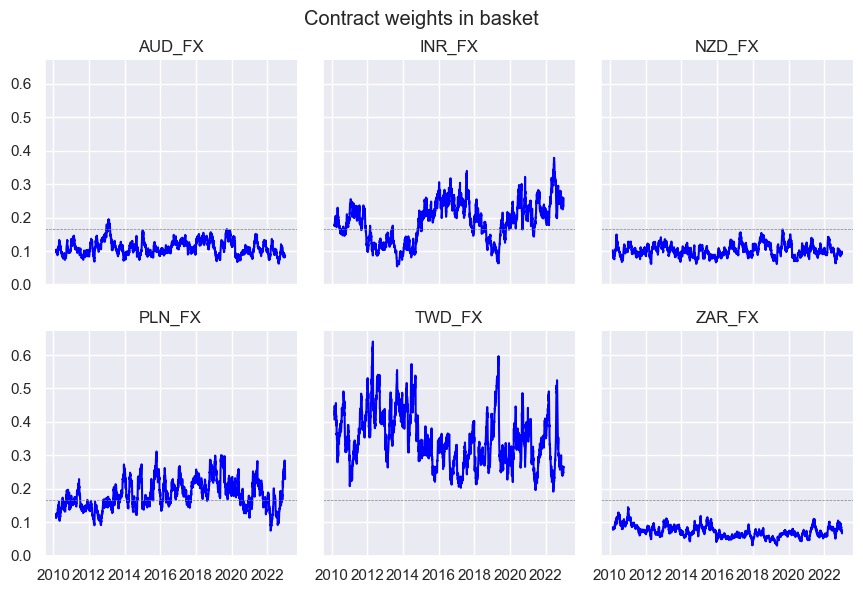

In [37]:
basket_fxcry.weight_visualiser(basket_name="GLB_FXCRYVW", facet_grid=True)

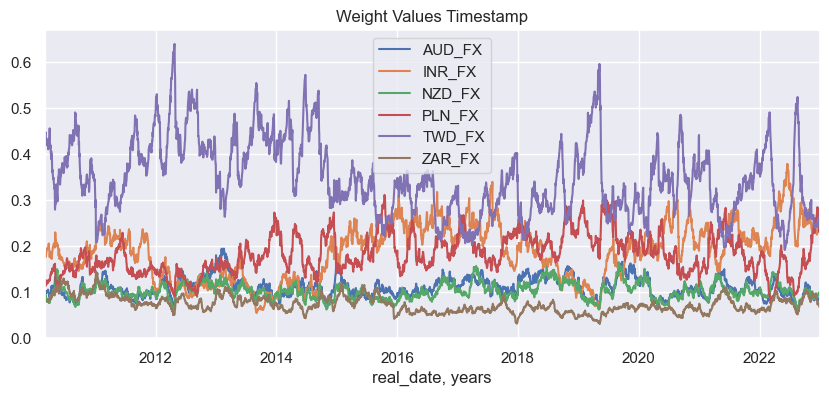

In [38]:
basket_fxcry.weight_visualiser(basket_name="GLB_FXCRYVW", subplots=False, size=(10, 4))

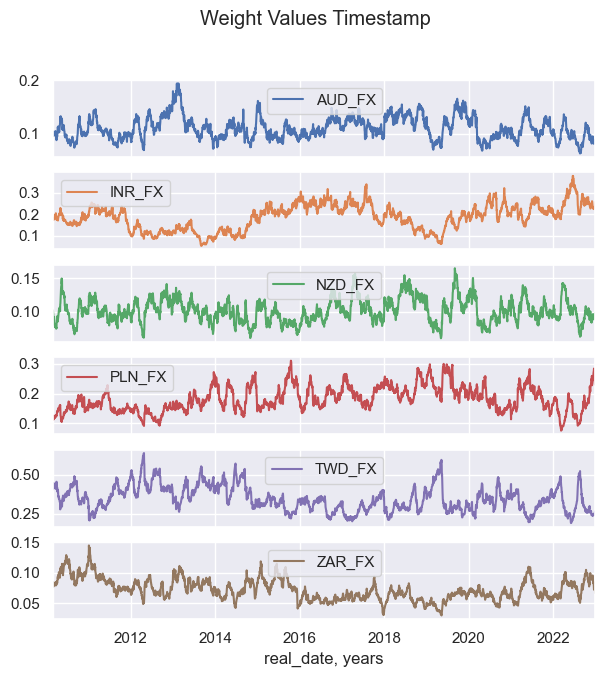

In [39]:
basket_fxcry.weight_visualiser(
    basket_name="GLB_FXCRYVW", subplots=True, 
)

## Calculate linear combinations of panels with `linear_composite`

The `linear_composite()` function is designed to calculate linear combinations of different categories. It can produce a composite even if some of the component data are missing. This flexibility is valuable because it enables to work with the available information rather than discarding it entirely. This behavior is desirable if one works with a composite of a set of categories that capture a similar underlying factor.


In the three examples below, the `linear_composite()` function is used to calculate the average of two inflation trend metrics by cross-section, the average of two cross-sections for one category (inflation trend) using fixed weights, and the same average using another category as weights. If one of the two constituents or cross-sections is missing, the composite is equal to the remaining.

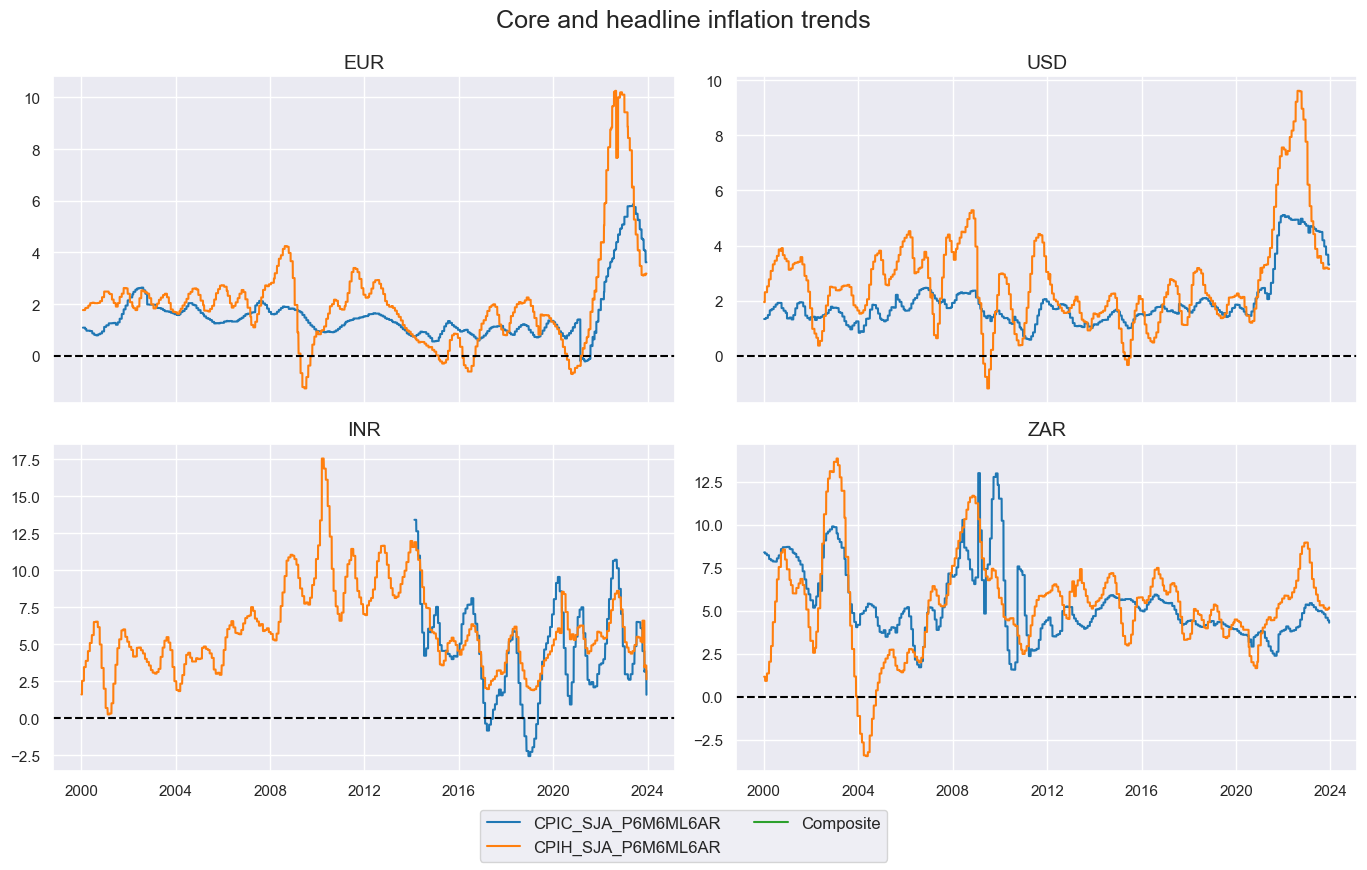

In [40]:
# Calculation of the simple average of two inflation trend metrics by cross-section

weights = [1, 1]
signs = [1, 1]
cids_sel = ["EUR", "USD", "INR", "ZAR"]
xcats_sel = ["CPIC_SJA_P6M6ML6AR", "CPIH_SJA_P6M6ML6AR"]

dflc = msp.linear_composite(
    df=dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    weights=weights,
    signs=signs,
    complete_xcats=False,
    new_xcat="Composite",
)

df = msm.update_df(df, dflc)

msp.view_timelines(
    dfx,
    xcats=xcats_sel + ["Composite"],
    cids=cids_sel,
    ncol=2,
    start="1995-01-01",
    same_y=False,
    title="Core and headline inflation trends",
    
)

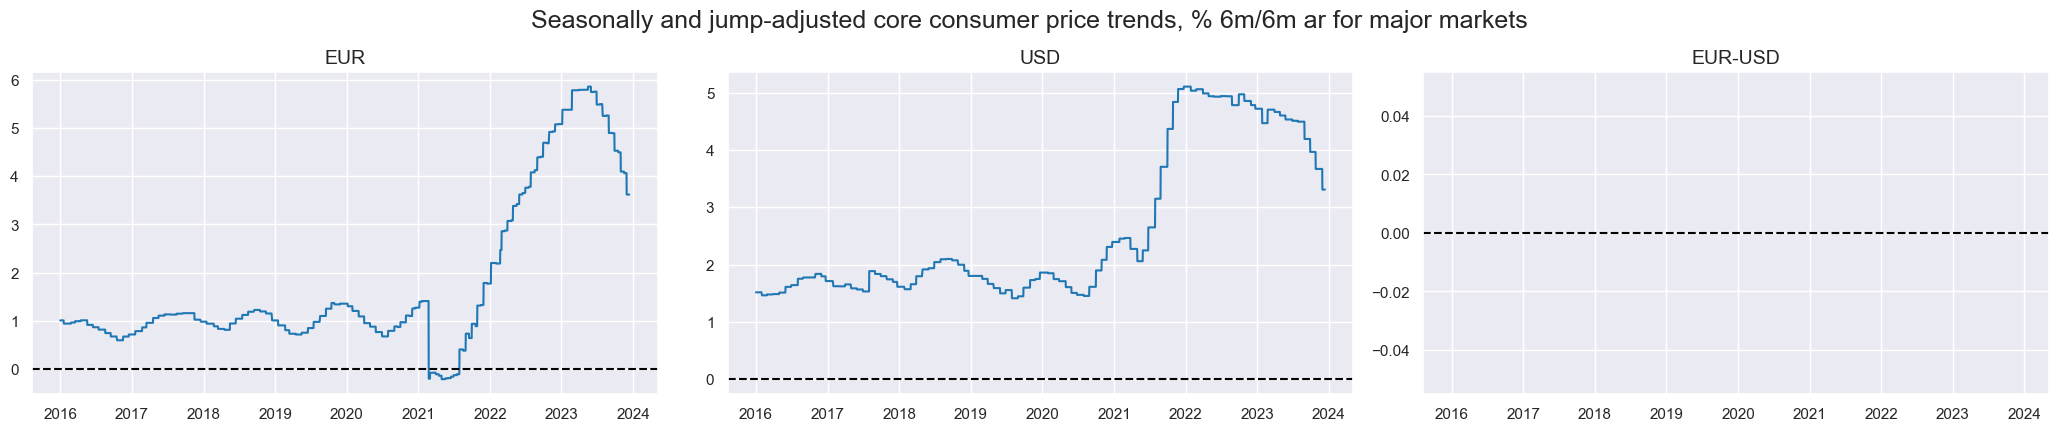

In [41]:
# Create a composite cross-section over one category. Difference between EUR and USD CPI trends

weights = [1,1]
signs = [1, -1] # setting weights to [1,1] and signs = [1, -1] we effectively subtract the "USD" time series from "EUR"
cids_sel = ["EUR", "USD"]

dflc = msp.linear_composite(
    df=dfx,
    start = "2016-01-01",
    xcats="CPIC_SJA_P6M6ML6AR",
    cids=cids_sel,
    weights=weights,
    signs=signs,
    complete_cids=False,
    new_cid="EUR-USD",
)

df = msm.update_df(df, dflc)

msp.view_timelines(
    dfx,
    xcats="CPIC_SJA_P6M6ML6AR",
    cids=cids_sel+["EUR-USD"],
    start = "2016-01-01",
    same_y=False,
    title = "Seasonally and jump-adjusted core consumer price trends, % 6m/6m ar for major markets",
    
)

Another example of the use of `linear_composite()` function is to create a composite category using another category as weights. The example below uses the 5-year real GDP growth as a weight for the EUR-USD inflation trends. The 5-year real GDP growth is taken purely as an example, it would make more sense to take GDP shares as weights as done in the notebook [Business sentiment and commodity future returns](https://academy.macrosynergy.com/academy/Trading%20factors/Business%20sentiment%20and%20commodity%20future%20returns/_build/html/Business%20sentiment%20and%20commodity%20future%20returns.php). However, the GDP shares time series is only available in full JPMaQS data, not available in the KAGGLE version, hence it is not part of this notebook. 

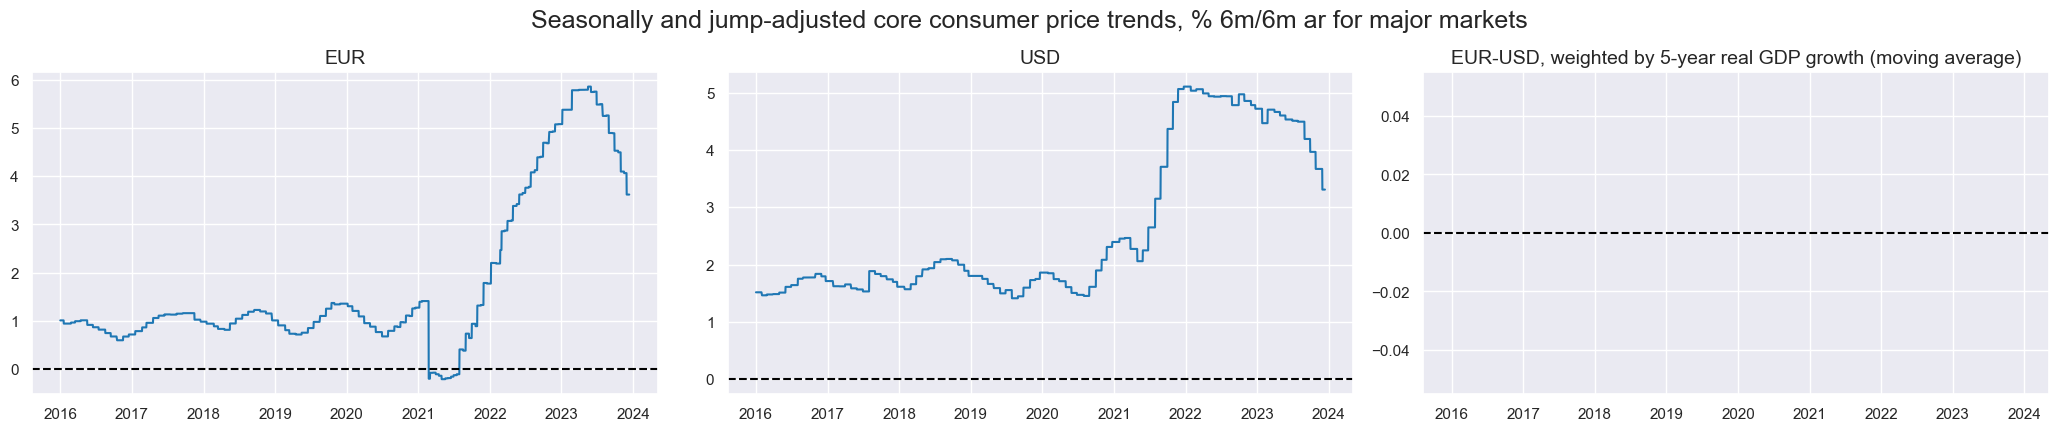

In [42]:
weights = "RGDP_SA_P1Q1QL4_20QMA"
cids_sel = ["EUR", "USD"]
xcat="CPIC_SJA_P6M6ML6AR"
signs = [1, -1]

dflc = msp.linear_composite(
    df=dfx,
    start = "2016-01-01",
    xcats=xcat,
    cids=cids_sel,
    weights=weights,
    signs=signs,
    complete_cids=False,
    new_cid="EUR-USD, weighted by 5-year real GDP growth (moving average)",
)

df = msm.update_df(df, dflc)

msp.view_timelines(
    dfx,
    xcats="CPIC_SJA_P6M6ML6AR",
    cids=cids_sel+["EUR-USD, weighted by 5-year real GDP growth (moving average)"],
    ncol=4,
    start = "2016-01-01",
    same_y=False,
    title = "Seasonally and jump-adjusted core consumer price trends, % 6m/6m ar for major markets",
    
    )

This notebook as well as several other notebooks on Macrosynergy Academy site are using linear composite macro trend pressure indicator. The idea is simple: we add up (negatives of) excess growth, inflation,  credit expansion, and real yield using the most common metrics. This gives a simple first-shot candidate for a trading signal. To start with, this composite indicator is not optimized. Later on, we use machine learning module of the package to optimize this indicator.

In [43]:
macros = ["XGDP_NEG", "XCPI_NEG", "XPCG_NEG", "RYLDIRS05Y_NSA"]
xcatx = macros

dfa = msp.linear_composite(
    dfx,
    xcats=[xc + "_ZN4" for xc in xcatx],
    cids=cids,
    new_xcat="MACRO_AVGZ",
)

dfx = msm.update_df(dfx, dfa)


# Relating

## Investigate relations between panels with `CategoryRelations`

`CategoryRelations` is a tool that allows for quick visualization and analysis of __two **categories**__, i.e., two time-series panels. To use this tool, the user needs to set up certain arguments upfront that determine the period and type of aggregation for which the relation is being analyzed. Here are some of the key arguments:

* The two-element list `xcats` sets the categories to be related. For predictive relation, the first is considered the predictive feature category, and the second is the target.
* The argument `freq` determines the base period of the analysis, typically set as monthly or quarterly. Since JPMaQS data frames are daily, this requires aggregation of both categories. These are set with `xcat_aggs` and can use any of pandas' aggregation methods, such as `sum` or `last`. The default is `mean`.
* The argument `lag` sets the lag (delay of arrival) of the first (feature) category in base periods. A positive value means that the feature is related to subsequent targets and - thus - allows analyzing its predictive power.
* The feature category can be modified by differencing or calculating percentage changes with `xcat1_chg1` argument and the auxiliary `n_periods` argument.
* A useful argument is `xcat_trims`, which removes observations above a maximum for the first and the second category in case the dataset contains invalid outliers. It trims the dataset and does not winsorize. Large values are interpreted as invalid and removed, not set to a limit.
* `fwin` can be used to transform the target category into forward-moving averages of the base period. This is useful for smoothing out volatility, but should not be used for formal inference.
* `blacklist` excludes invalid periods from the analysis.

Based on the above explanation, the following instantiation prepares the analysis of the predictive power of a quarterly change of an inflation metric and the subsequent quarterly 5-year IRS returns while excluding quarterly values above 10:

In [44]:
cr = msp.CategoryRelations(
    dfx,
    xcats=["CPIC_SJA_P6M6ML6AR", "DU05YXR_VT10"],
    cids=cids_dm,
    xcat1_chg="diff",
    n_periods=1,
    freq="Q",
    lag=1,
    fwin=1,  # default forward window is one
    xcat_aggs=[
        "last",
        "sum",
    ],  # the first method refers to the first item in xcats list, the second - to the second
    start="2000-01-01",
    xcat_trims=[10, 10],
)

for attribute, value in cr.__dict__.items():
    print(attribute, " = ", value)

xcats  =  ['CPIC_SJA_P6M6ML6AR', 'DU05YXR_VT10']
cids  =  ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']
val  =  value
freq  =  Q
lag  =  1
years  =  None
aggs  =  ['last', 'sum']
xcat1_chg  =  diff
n_periods  =  1
xcat_trims  =  [10, 10]
slip  =  0
df  =                  CPIC_SJA_P6M6ML6AR  DU05YXR_VT10
real_date  cid                                  
2000-09-29 NOK            0.610662      1.159514
2000-12-29 NOK            0.360919      9.026816
2001-03-30 NOK           -0.023296     -3.668594
2001-06-29 NOK           -0.319711     -8.099728
2001-09-28 NOK           -0.423282      9.067055
...                            ...           ...
2022-12-30 AUD            1.215072     -0.452245
2023-03-31 AUD            1.025197      5.715873
2023-06-30 AUD            0.818365     -6.967458
2023-09-29 AUD            0.146163     -2.442955
2023-12-29 AUD           -0.793494      0.326937

[752 rows x 2 columns]


The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. By default, it includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship.

The `reg_scatter()` method allows to split the analysis by cross-section (`cid`) or `year`, which is useful for examining how the relationship between the two categories varies across different markets or over time. This can be especially interesting in cases where the relationship between the two categories is not constant over time or across different markets.

`multiple_reg_scatter()` method allows comparison of several pairs of two categories relationships side by side, including the strength of the linear association and any potential outliers. By default, it includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship.

The `coef_box` parameter of the `reg_scatter()` method provides details about the relationship, such as correlation coefficient and probability of significance, which can help users assess the strength and statistical significance of the relationship.

The `prob_est` argument in this context is used to specify which type of estimator to use for calculating the probability of a significant relationship between the feature category and the target category.

The default value for `prob_est` is `"pool"`, which means that all cross-sections are pooled together, and the probability is based on that pool. This approach can potentially lead to issues with "pseudo-replication" if there is a correlation between the analyzed markets.

An alternative option for `prob_est` is `"map"`, which stands for "Macrosynergy panel test". Often, cross-sectional experiences are not independent and subject to common factors. Simply stacking data can lead to “pseudo-replication” and overestimated significance of correlation. A better method is to check significance through panel regression models with period-specific random effects. This technique adjusts targets and features of the predictive regression for common (global) influences. The stronger these global effects, the greater the weight of deviations from the period-mean in the regression. In the presence of dominant global effects, the test for the significance of a feature would rely mainly upon its ability to explain cross-sectional target differences. Conveniently, the method automatically accounts for the similarity of experiences across sections when assessing the significance and, hence, can be applied to a wide variety of features and targets. View a related research post [here](https://research.macrosynergy.com/testing-macro-trading-factors) that provides more information on this approach.

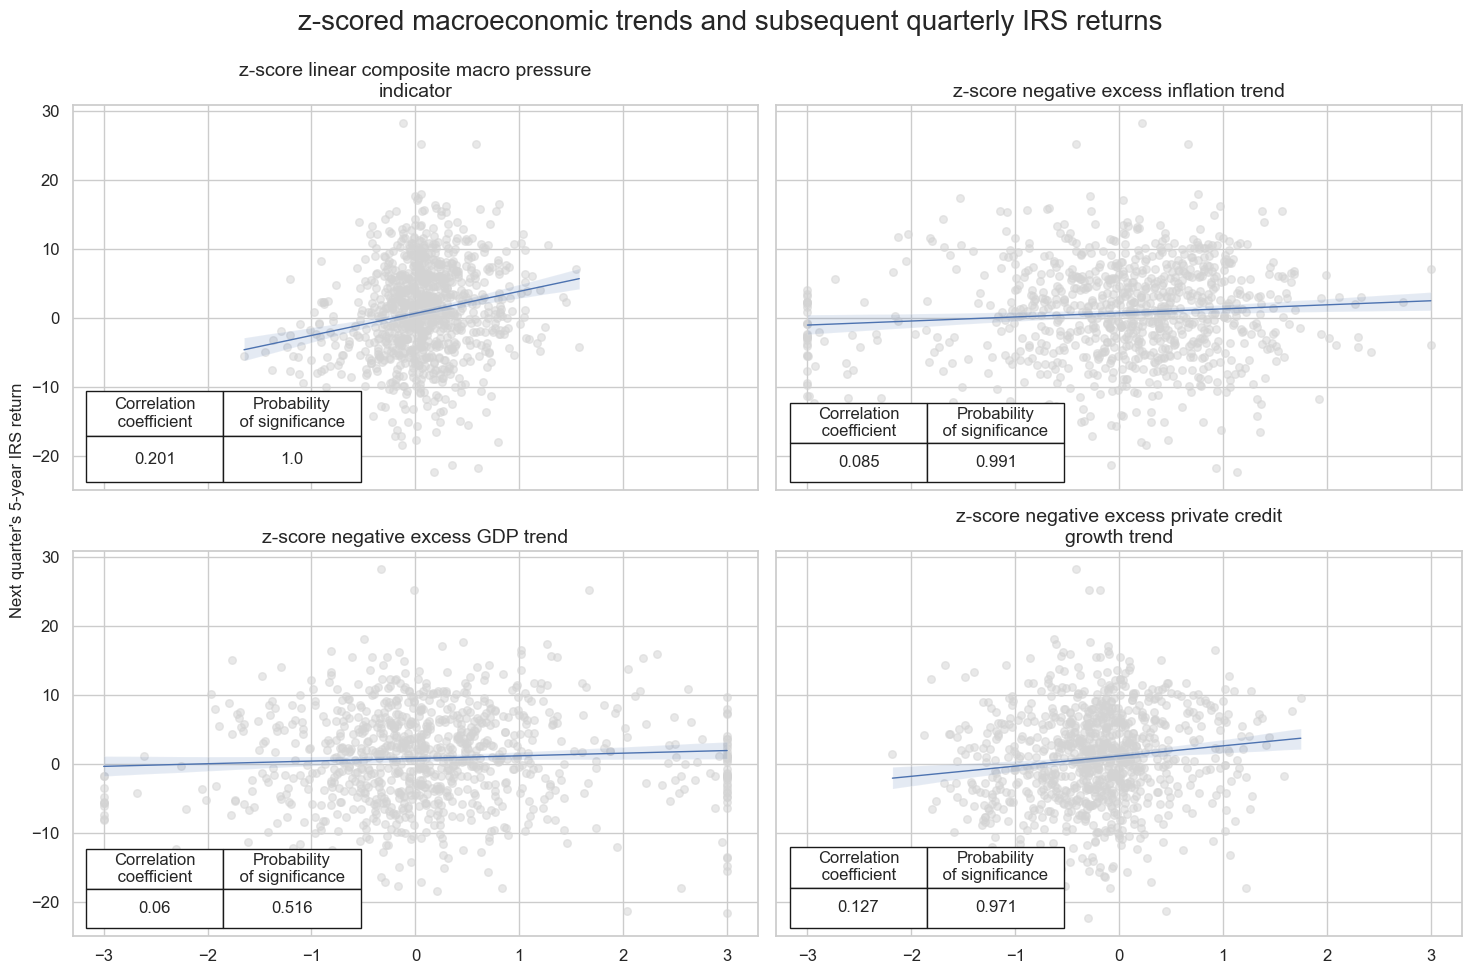

In [45]:

["XGDP_NEG", "XCPI_NEG", "XPCG_NEG", "RYLDIRS05Y_NSA"]


crx = msp.CategoryRelations(
    dfx,
    xcats=["MACRO_AVGZ", "DU05YXR_VT10"],
    cids=cids_dm,
    n_periods=1,
    freq="Q",
    lag=1,  # delay of arrival of first (explanatory) category in periods as set by freq
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
)



crxx = msp.CategoryRelations(
    dfx,
    xcats=["XCPI_NEG_ZN4", "DU05YXR_VT10"],
    cids=cids_dm,
    n_periods=1,
    freq="Q",
    lag=1,  # delay of arrival of first (explanatory) category in periods as set by freq
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
)


crxxx = msp.CategoryRelations(
    dfx,
    xcats=["XGDP_NEG_ZN4", "DU05YXR_VT10"],
    cids=cids_dm,
    n_periods=1,
    freq="Q",
    lag=1,  # delay of arrival of first (explanatory) category in periods as set by freq
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
)

crxxxx = msp.CategoryRelations(
    dfx,
    xcats=["XPCG_NEG_ZN4", "DU05YXR_VT10"],
    cids=cids_dm,
    n_periods=1,
    freq="Q",
    lag=1,  # delay of arrival of first (explanatory) category in periods as set by freq
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
)



msv.multiple_reg_scatter(
        [crx, crxx, crxxx, crxxxx],
        title="z-scored macroeconomic trends and subsequent quarterly IRS returns",
     #   xlab="Core CPI inflation, %oya, versus effective inflation target, relative to all DM, end-of-month",
        ylab="Next quarter's 5-year IRS return",
        ncol=2,
        nrow=2,
        figsize=(15, 10),
        prob_est="map",
        coef_box="lower left", 
        subplot_titles=["z-score linear composite macro pressure indicator", "z-score negative excess inflation trend", "z-score negative excess GDP trend", "z-score negative excess private credit growth trend"],
     )



The `years` parameter specifies the number of years to aggregate the data for the scatterplot, and when combined with `labels=true`, it can be used to visualize medium-term concurrent relations. This parameter overrides the `freq` parameter and doesn't allow lags, meaning that only the 3-year aggregated feature is compared to the 3-year aggregated target. This can be useful for identifying medium-term concurrent relations.

The `separator` argument in the `.reg_scatter()` method supports visualization of the stability of the feature-target relation for different sub-periods and cross-sections. When the `separator` is set to a year integer, it splits the data into two sub-samples, with the second one starting from the separation year. As a result, regression lines and scatter plots are shown separately for each sub-sample, allowing us to visually assess the stability of the feature-target relation before and after the separation year.

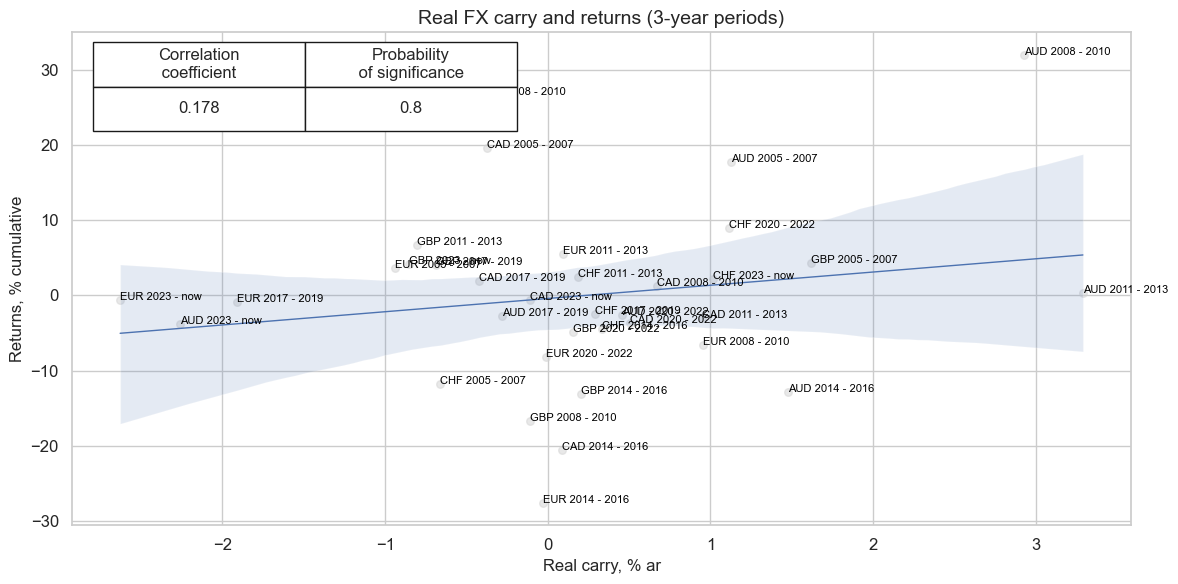

In [46]:
cids_sel = cids_dm[:5]
cr = msp.CategoryRelations(
    df,
    xcats=["FXCRR_NSA", "FXXR_NSA"],
    cids=cids_sel,
    freq="M",
    years=3,
    lag=0,
    xcat_aggs=["mean", "sum"],
    start="2005-01-01",
    blacklist=fxblack,
)
cr.reg_scatter(
    title="Real FX carry and returns (3-year periods)",
    labels=True,
    prob_est="map",
    xlab="Real carry, % ar",
    ylab="Returns, % cumulative",
    coef_box="upper left",
    size=(12, 6),
)

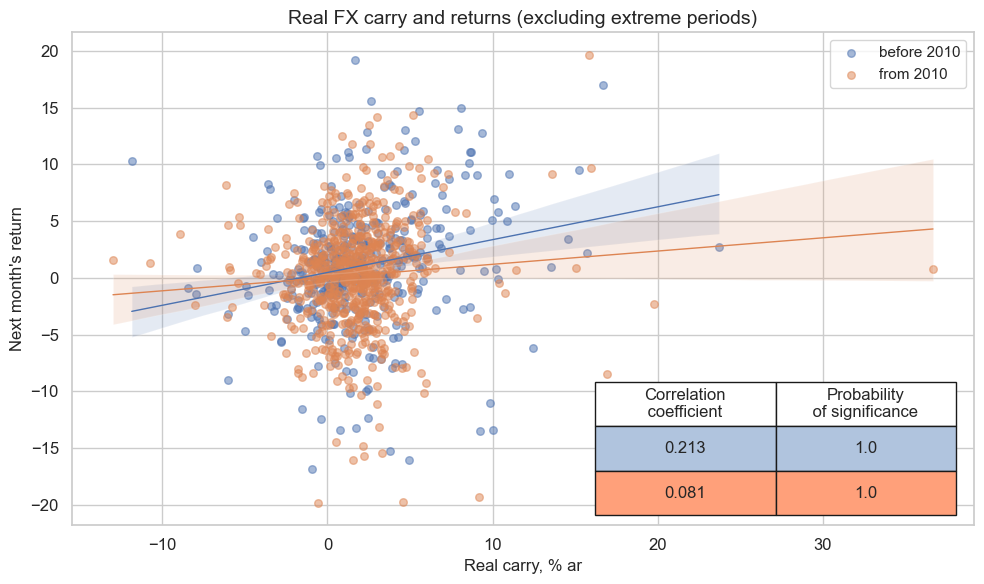

In [47]:
cr = msp.CategoryRelations(
    dfx,
    xcats=["FXCRR_NSA", "FXXR_NSA"],
    cids=list(set(cids_em) - set(["ILS", "CLP"])),
    freq="Q",
    years=None,
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=fxblack,
    xcat_trims=[40, 20],
)
cr.reg_scatter(
    title="Real FX carry and returns (excluding extreme periods)",
    reg_order=1,
    labels=False,
    xlab="Real carry, % ar",
    ylab="Next month's return",
    coef_box="lower right",
    prob_est="map",
    separator=2010,
    size=(10, 6),
)

If the `separator` argument is set to "cids", the relationship is shown separately for all cross-sections of the panel. This allows to examine whether the relationship is consistent across markets.

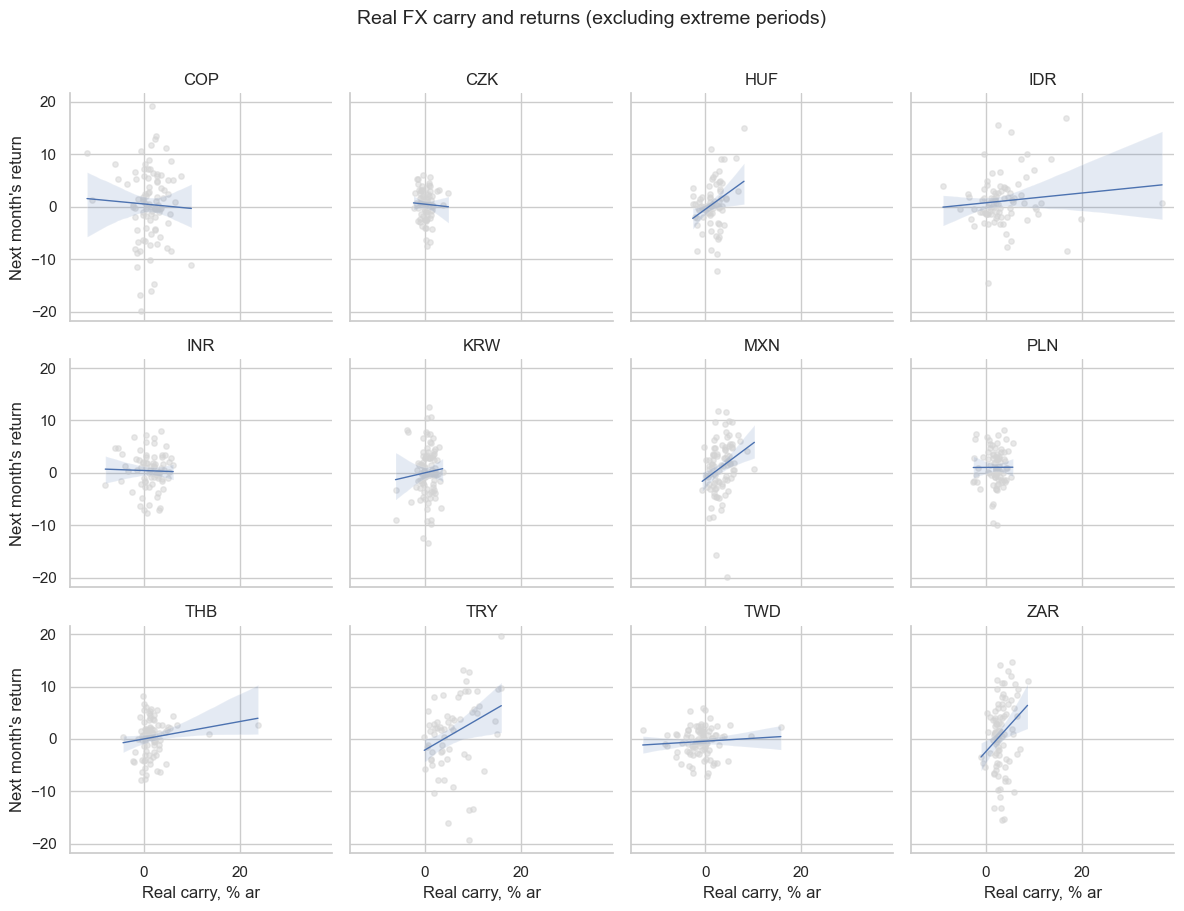

In [48]:
cr.reg_scatter(
    title="Real FX carry and returns (excluding extreme periods)",
    reg_order=1,
    labels=False,
    xlab="Real carry, % ar",
    ylab="Next month's return",
    separator="cids",
    title_adj=1.01,
)

The basic statistics of a standard pooled linear regression analysis, combining all features and targets of the panel without further structure and effects, can be displayed based on a `statsmodels` function by calling the method `.ols_table()`. For a detailed interpretation of the results from the `.ols_table()` output, please view [this article](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a) , which provides a general overview of interpreting linear regression results using the `statsmodels` summary table. 

In [49]:
cr = msp.CategoryRelations(
    dfx,
    xcats=["CPIC_SJA_P6M6ML6AR", "DU05YXR_VT10"],
    cids=cids_dm,
    xcat1_chg="diff",
    n_periods=1,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
)
cr.ols_table()

                            OLS Regression Results                            
Dep. Variable:           DU05YXR_VT10   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.186
Date:                Sun, 30 Mar 2025   Prob (F-statistic):              0.139
Time:                        17:42:05   Log-Likelihood:                -7412.0
No. Observations:                2717   AIC:                         1.483e+04
Df Residuals:                    2715   BIC:                         1.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2637      0

## Visualize relations across sections or categories with `correl_matrix`

The `correl_matrix()` function visualizes two types of Pearson correlations: 
* correlations within a single category across different cross-sections, or 
* correlations across different categories. 

A key argument is `freq`, which downsamples the standard JPMaQS frequency of business daily data to weekly ('W'), monthly ('M'), or quarterly ('Q'), aggregate by mean.

Additionally, the user can set the `cluster` argument to `True` to order the correlated series by proximity based on hierarchical clustering. This can help visualize groups of related variables, making it easier to identify patterns and relationships within the correlation matrix.

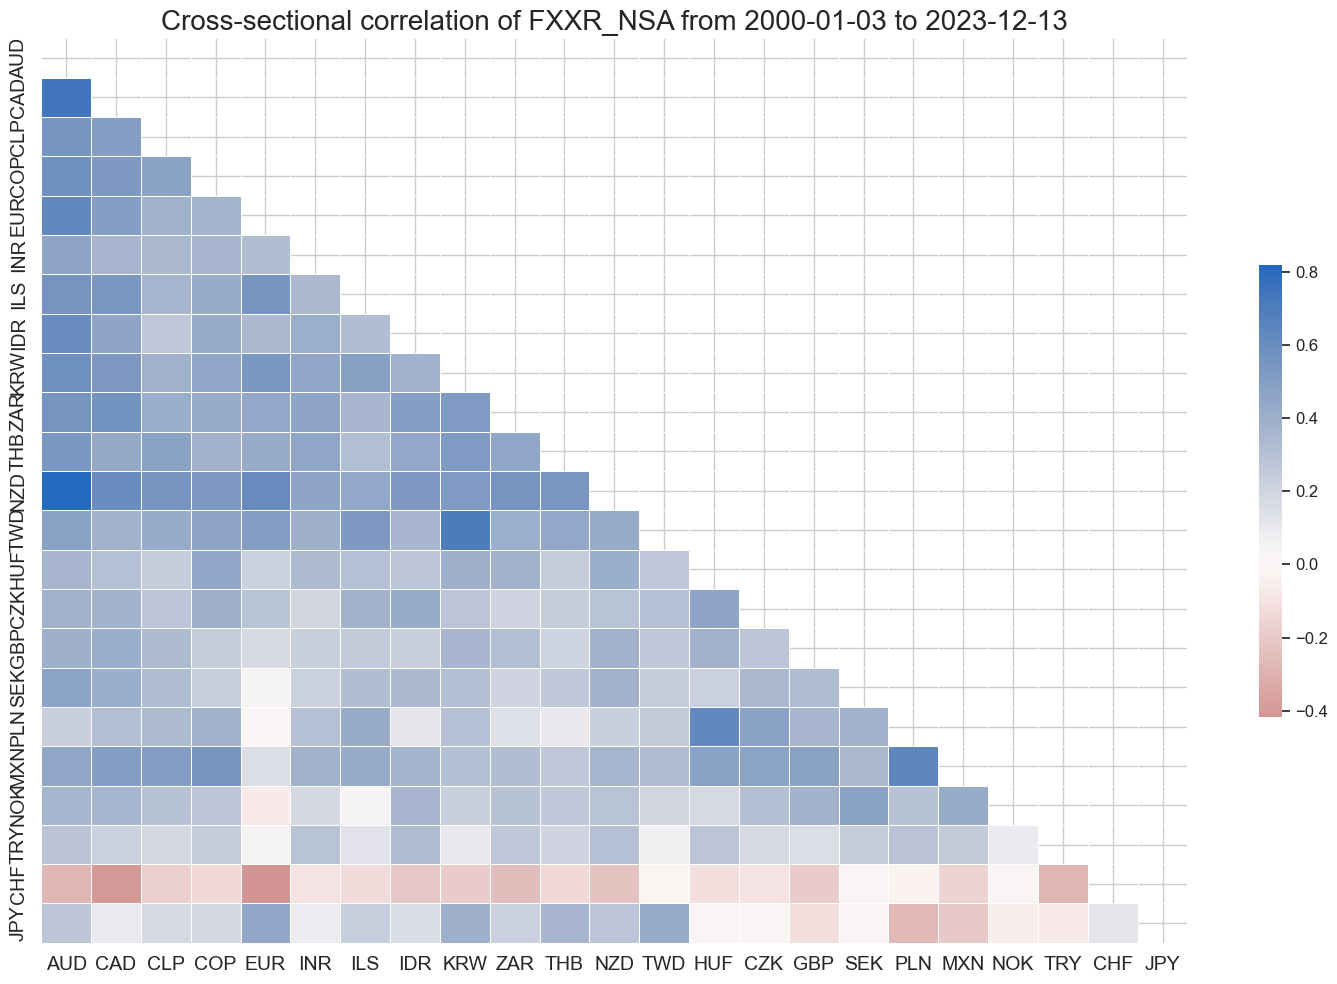

In [50]:
cids = cids_dm + cids_em
msp.correl_matrix(
    dfx, xcats="FXXR_NSA", freq="Q", cids=cids, size=(15, 10), cluster=True
)

One can pass a list of categories to the `xcats` argument of the `correl_matrix() `function to display correlations across categories. The resulting output will be a matrix of correlation coefficients between the categories. The freq and cluster arguments can also be used in this case to downsample the frequency of the data and to cluster the categories based on their proximity, respectively.

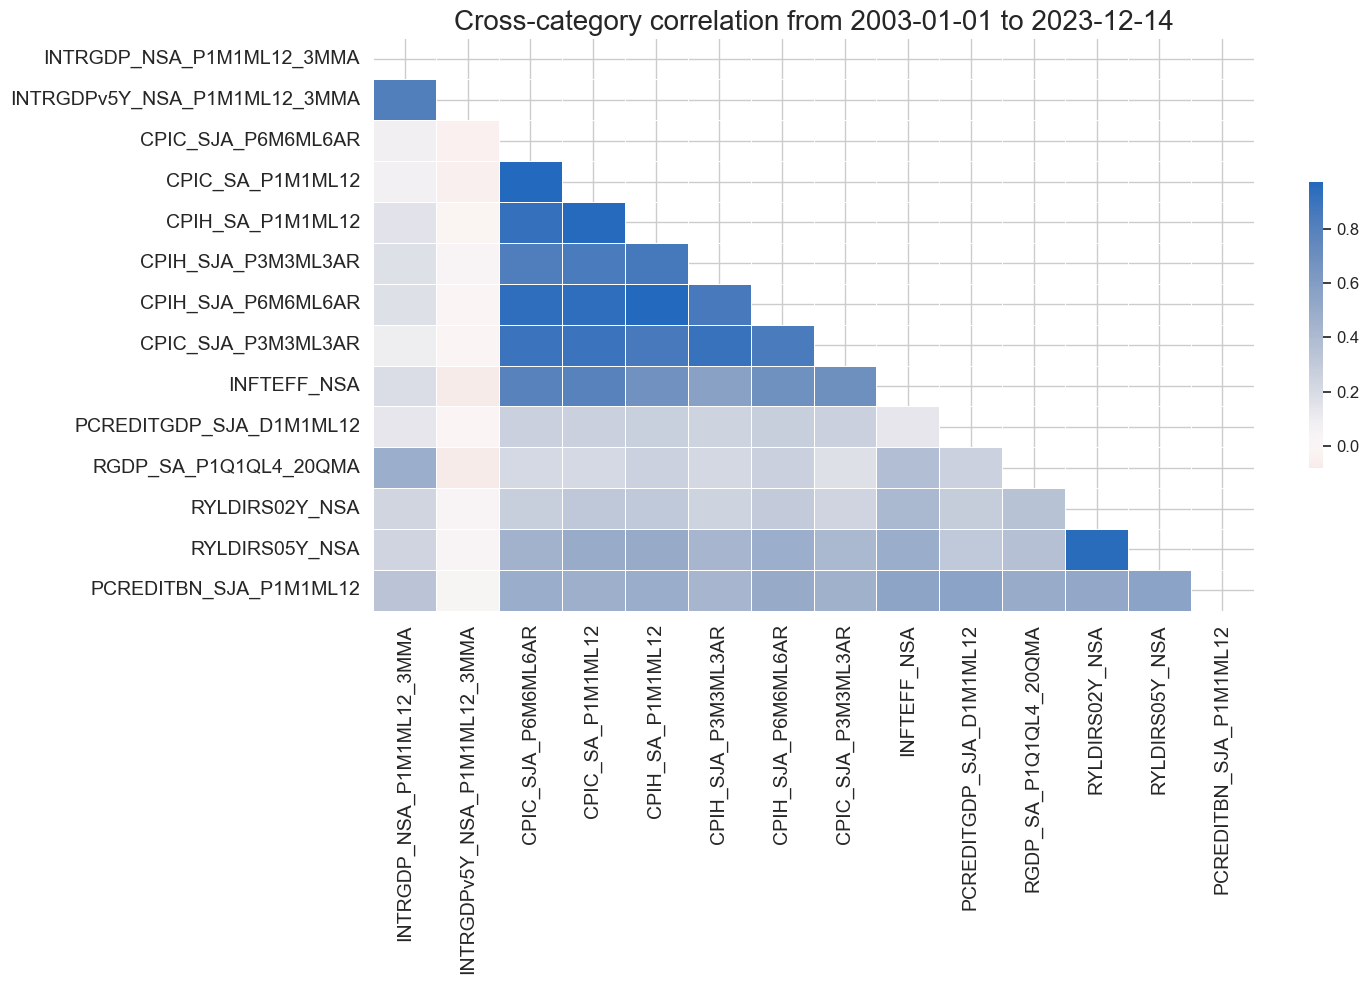

In [51]:
xcats_sel = ecos
msp.correl_matrix(
    dfx,
    xcats=xcats_sel,
    cids=cids,
    freq="M",
    start="2003-01-01",
    size=(15, 10),
    cluster=True,
)

The `msp.correl_matrix()` function is designed to compute correlations between any two categories. In the context outlined below, we specifically focus on examining correlations between inflation trends and subsequent asset returns. To enhance the depth of our analysis, we introduce a flexibility in exploring various lags for explanatory variables. This flexibility is facilitated through the use of a dictionary where desired lags can be specified. In this instance, we are interested in investigating lags at monthly frequencies, with specific values set at 1, 3, and 6 months.

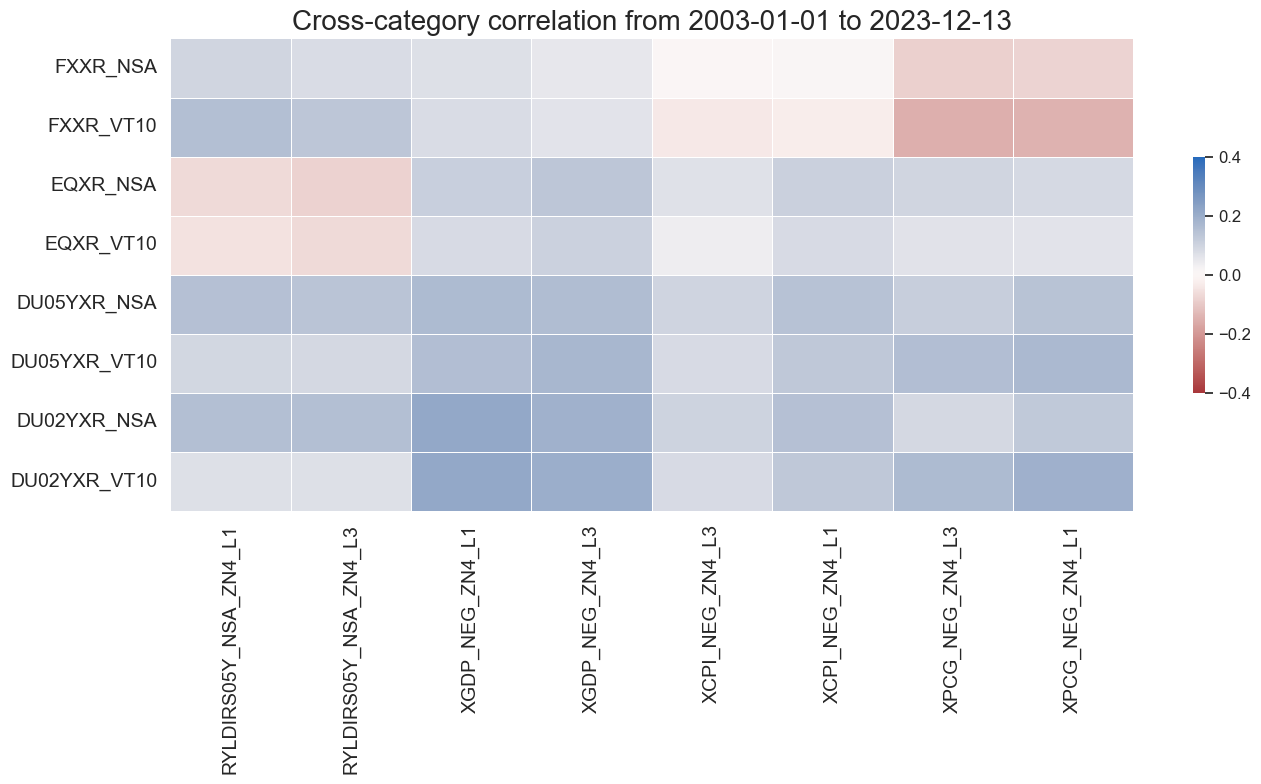

In [52]:
macroz = [m + "_ZN4" for m in macros]
feats = macroz

rets=["DU02YXR_VT10",
    "DU02YXR_NSA",
    "DU05YXR_VT10",
    "DU05YXR_NSA",
     "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10"]

lag_dict = {"XGDP_NEG_ZN4": [1, 3], 
    "XCPI_NEG_ZN4": [1, 3], # excess inflation
    "XPCG_NEG_ZN4": [1, 3],  # excess real interest rate
    "RYLDIRS05Y_NSA_ZN4": [1, 3]}


msp.correl_matrix(
    dfx,
    xcats=feats,
    xcats_secondary=rets, 
    cids="EUR",
    freq="M",
    start="2003-01-01",
    lags=lag_dict,
    max_color=0.4,
    cluster=True, 
)

# Learning

The `macrosynergy.learning` subpackage contains functions and classes to assist the creation of statistical machine learning signals using panels of macro quantamental data.
The functionality is built around integrating the macrosynergy package and associated JPMaQS data with the popular `scikit-learn` library, which provides a simple interface for fitting common statistical machine learning models, as well as feature selection methods, cross-validation classes, and performance metrics.
 
Most standard `scikit-learn` classes and functions do not respect the panel format of quantamental dataframes, i.e., the double-indexing by both cross section and time period. The below customized wrappers allow to apply the panel format.

Please also see the introductory notebooks where `macrosynergy.learning` is extensively employed:

- [Optimizing macro trading signals – A practical introduction](https://research.macrosynergy.com/optimal-signals/).
- [Regression-based macro trading signals](https://research.macrosynergy.com/regression-signals/)

The initial step in transforming JPMaQS data into a format suitable for machine learning is conversion of a quantamental dataframe into a "wide format" dataframe, where columns represent indicators/factors and each row can be completely identified by a cross-section (`cid`) and a timestamp (`real_date`). In a dataframe, this can be represented by enforcing a multi-index. The classes `SignalOptimizer` and `BetaEstimator`, which both employ sequential learning frameworks, perform this conversion in their constructors using the `categories_df` function from `macrosynergy.management`. This function fascilitates dataset downsampling (to produce lower-frequency signals), feature-lagging (a common practice in machine learning to facilitate predictive analysis) and the dropping of rows with null values (to concentrate analysis on samples with full information).

For this section, we construct a monthly dataset where the features are lagged by a single month to fascilate the creation of monthly signals. 

- Features (`X`): To form the monthly feature set, we select the last recorded value of daily series for each month. This approach ensures that the end-of-period snapshot, which is crucial in financial analysis, is captured, providing a clear representation of each month's final state. Potential (daily) features (z-scores) are collected in the list `macroz`. In this list we earlier collected z-scores of the following variables: 

    -   "XGDP_NEG" - negative of the intuitive growth trend, 
    -   "XCPI_NEG" - negative of excess inflation measure 
    -   "XPCG_NEG" - negative of excess private credit growth, 
    -   "RYLDIRS05Y_NSA" - real IRS yield: 5-year maturity, expectations-based


- Targets (`y`): The target variable is created by aggregating the daily returns over each month to derive a total monthly return. This method offers a direct target for predictive models by emphasizing the cumulative outcome for the month, rather than the daily fluctuations. In this notebook, the target dataframe includes (monthly) returns on fixed receiver position, % of risk capital on position scaled to 10% (annualized) volatility target: 5-year maturity `DU05YXR_VT10`

In [53]:
# Specify features and target category
xcatx = macroz + ["DU05YXR_VT10"]

# Downsample from daily to monthly frequency (features as last and target as sum)
dfw = msm.categories_df(
    df=dfx,
    xcats=xcatx,
    cids=cids_dux,
    freq="M",
    lag=1,
    blacklist=fxblack,
    xcat_aggs=["last", "sum"],
)

# Drop rows with missing values and assign features and target
dfw.dropna(inplace=True)
X = dfw.iloc[:, :-1]
y = dfw.iloc[:, -1]

X

XGDP_NEG_ZN4  XCPI_NEG_ZN4  XPCG_NEG_ZN4  RYLDIRS05Y_NSA_ZN4
cid real_date                                                               
AUD 2001-07-31      1.641867     -1.798581     -0.652388            1.014798
    2001-08-31      1.456932     -2.302273     -0.552456            1.001587
    2001-09-28      1.203363     -2.309478     -0.332318            0.837669
    2001-10-31      1.293226     -2.333290     -0.303837            0.778935
    2001-11-30      1.104662     -0.834081     -0.462791            0.688909
...                      ...           ...           ...                 ...
ZAR 2023-08-31     -0.204233     -0.518056     -0.218567            1.933981
    2023-09-29      0.053905     -0.135242     -0.161383            1.878251
    2023-10-31     -0.197123     -0.064367      0.214650            2.217267
    2023-11-30     -0.019005     -0.234827      0.132334            2.082126
    2023-12-29      0.126673     -0.408072      0.296763            1.712215

[4957 rows x 4 columns]

## Cross-validation splitters

Cross-validation is a dataset resampling method to, given a performance metric, estimate the expected out-of-sample metric value. It evaluates a model's predictive ability through multiple divisions of the data into training and validation sets. Each division is known as a "fold". The `macrosynergy` package supports the splitting of panel data into folds through five classes:

- `ExpandingIncrementPanelSplit()` creates paired training-validation sets, where the training set expands over time at fixed intervals, followed by test sets of predetermined time spans. This method allows for a progressive inclusion of more data into the training set over time. The user specifies the number of periods that a training set expands by and the number of test periods forward of each training set, amongst other options.  
- `ExpandingFrequencyPanelSplit()` works similarly to `ExpandingIncrementPanelSplit()`, but instead of specifying time periods to increment training/validation sets, frequency strings are specified.  
- `ExpandingKFoldPanelSplit()` also creates expanding folds and involves a fixed number of splits. Training panels in this configuration are always temporally adjacent and chronologically precede the test set, ensuring that each test phase is preceded by a comprehensive training phase.
- `RollingKFoldPanelSplit()` arranges splits where training panels of a fixed maximum duration can directly precede or follow the test set, allowing the use of both past and future data in training. While this arrangement does not mimic the sequential flow of information typical in time series analysis, it effectively leverages the cyclic nature of economic data. Moreover, it effectively evaluates models over different backtest paths. 
- `RecencyKFoldPanelSplit()` accepts both `n_splits` and `n_periods` as parameters. This is another expanding K-fold cross-validator, but with cross-validation concentrated on the most recent samples. For instance, if `n_splits` is set to 5 and `n_periods` is set to 3, on a monthly dataframe, then the last $5 \times 3 = 15$ time periods are split into 5 validation sets that each span a quarter. The training set corresponding to each validation set comprises all time periods in the dataset prior to the concerned validation set.

### `ExpandingIncrementPanelSplit()` 

The `ExpandingIncrementPanelSplit()` class facilitates the generation of expanding windows for cross-validation, essential for modeling scenarios where data is incrementally available over time. This class divides the dataset into training and testing sets, systematically increasing the size of the training set by one observation with each iteration. This approach effectively simulates environments where new information is gradually incorporated at set intervals.

Important parameters here are:

* `train_intervals` specifies the length of the training interval in time periods. This parameter controls how much the training set expands with each new split. 
* `min_cids`  sets the minimum number of cross-sections required for the initial training set, with the default being four. This is crucial in scenarios where panel data is unbalanced, ensuring there are enough cross-sections to begin the training process.
* `min_periods` sets the smallest number of time periods required for the initial training set, with the default being 500 native frequency units. This is particularly important in an unbalanced panel context and should be used in conjunction with `min_cids`.
* `test_size` determines the length of the test set for each training interval. By default, this is set to 21 periods, which follows the training phase.
* `max_periods` defines the maximum duration that any training set can reach during the expanding process. If this cap is reached, the earliest data periods are excluded to maintain this constraint. By setting this value, rolling training is effectively performed.

In [54]:
split_xi = msl.ExpandingIncrementPanelSplit(train_intervals=12, min_periods=12, test_size=24, min_cids=2)

#### `visualise_splits()`

The method `visualise_splits` can be applied to a splitter and is a convenient method for visualizing the splits produced by each splitter based on the full data sets of features and targets. 

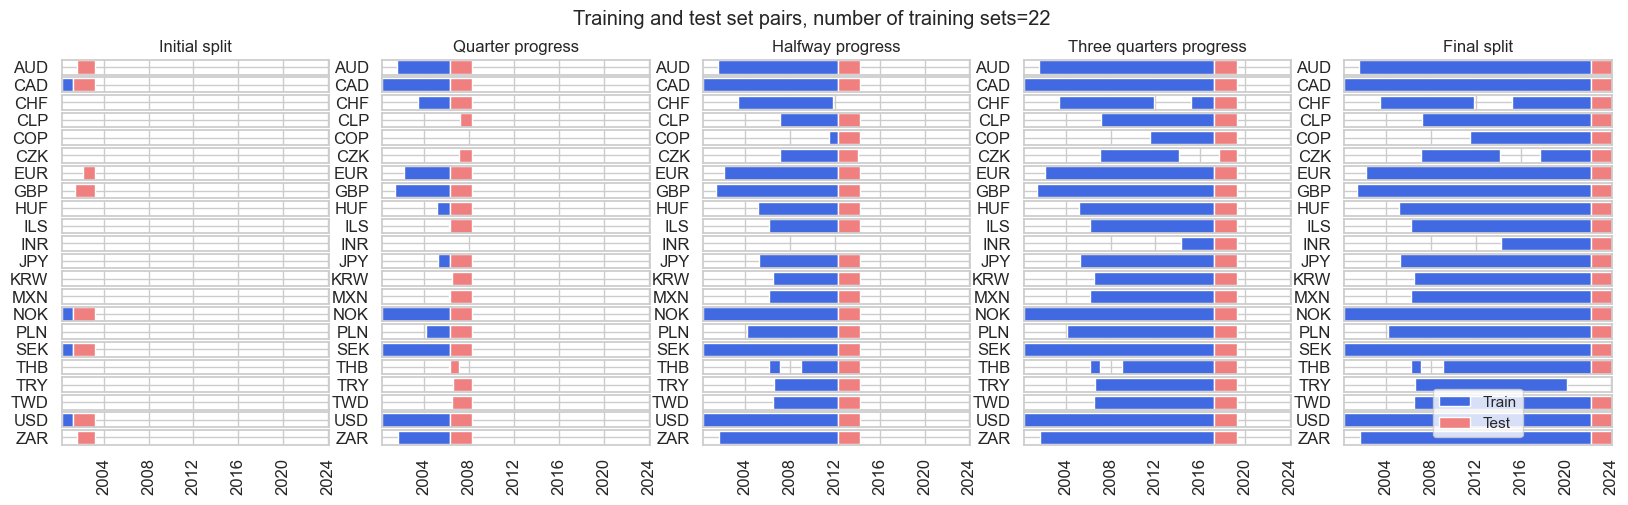

In [55]:
split_xi.visualise_splits(X,y)

### `ExpandingFrequencyPanelSplit()` 

As with `ExpandingIncrementPanelSplit()`, the `ExpandingFrequencyPanelSplit()` class generates expanding windows for cross-validation. However, the user specifies the frequencies at which the training sets expand and at which the validation sets span. 

The important parameters here are:
* `expansion_freq` specifies the frequency at which training sets expand. 
* `test_freq` specifies the frequency forward of each training set that each validation set spans.
* `min_cids`  sets the minimum number of cross-sections required for the initial training set, with the default being four. This is crucial in scenarios where panel data is unbalanced, ensuring there are enough cross-sections to begin the training process.
* `min_periods` sets the smallest number of time periods required for the initial training set, with the default being 500 native frequency units. This is particularly important in an unbalanced panel context and should be used in conjunction with `min_cids`.
* `max_periods` defines the maximum span that any training set can cover during the expanding process. If this cap is reached, the earliest data periods are excluded to maintain this constraint. By setting this value, rolling training is effectively performed.

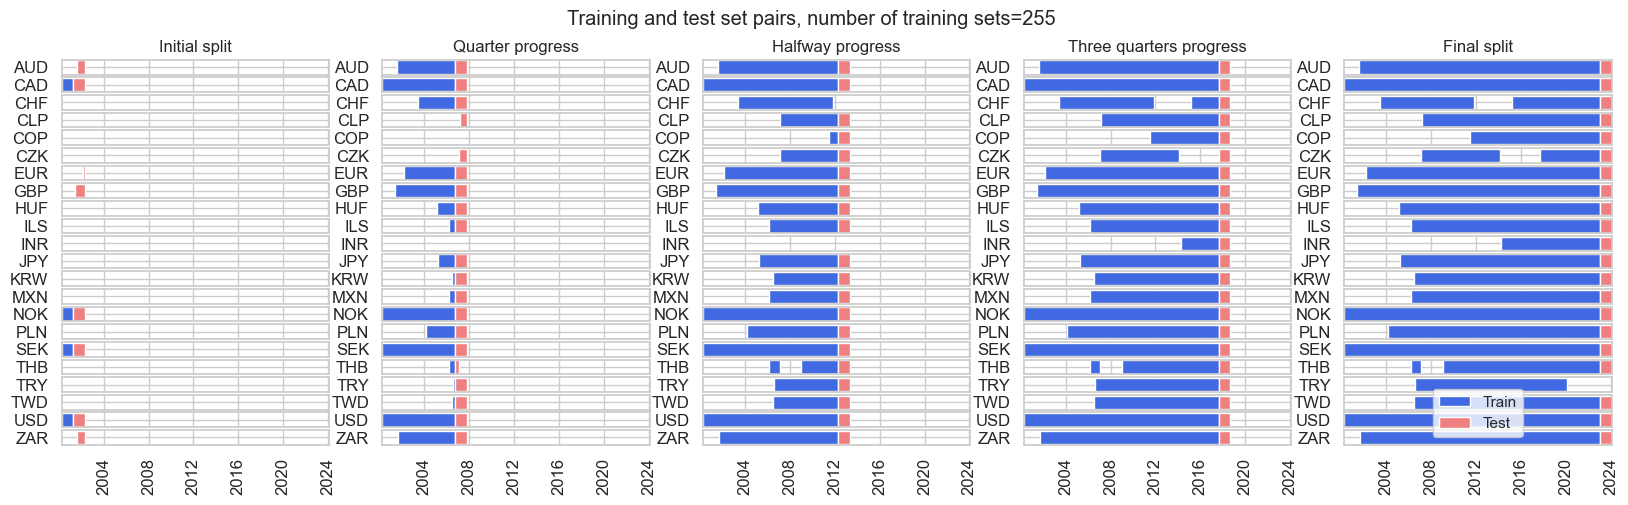

In [56]:
split_xf = msl.ExpandingFrequencyPanelSplit(
    expansion_freq="M",
    test_freq="Y",
    min_cids=2,
    min_periods=12,
)
split_xf.visualise_splits(X, y)

### `ExpandingKFoldPanelSplit()` 

The `ExpandingKFoldPanelSplit()` class produces sequential learning scenarios, where information sets grow at fixed intervals.

The key parameter here is `n_splits`, which determines the number of desired splits (must be at least 2). As above, `visualise_splits()` method is used to visualise if the split has been performed as intended. This replicates `scikit-learn`'s `TimeSeriesSplit` class for panel-format data.

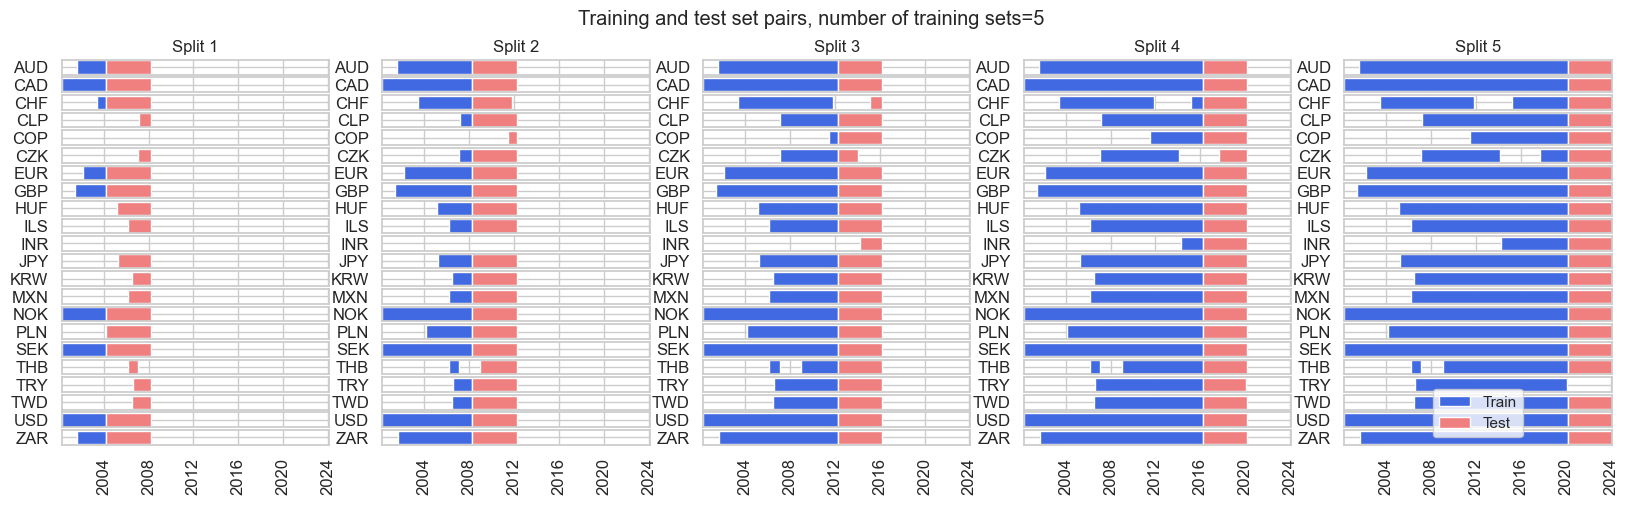

In [57]:
split_xkf = msl.ExpandingKFoldPanelSplit(n_splits=5)
split_xkf.visualise_splits(X, y)

### `RollingKFoldPanelSplit()`

The `RollingKFoldPanelSplit` class produces paired training and test splits, created for a data panel. It is similar to scikit-learn's `KFold` class for simple time series. Training and test sets need to be adjacent, but the former needs not strictly precede the latter. This gives the effect of the test set "rolling" forward in time.

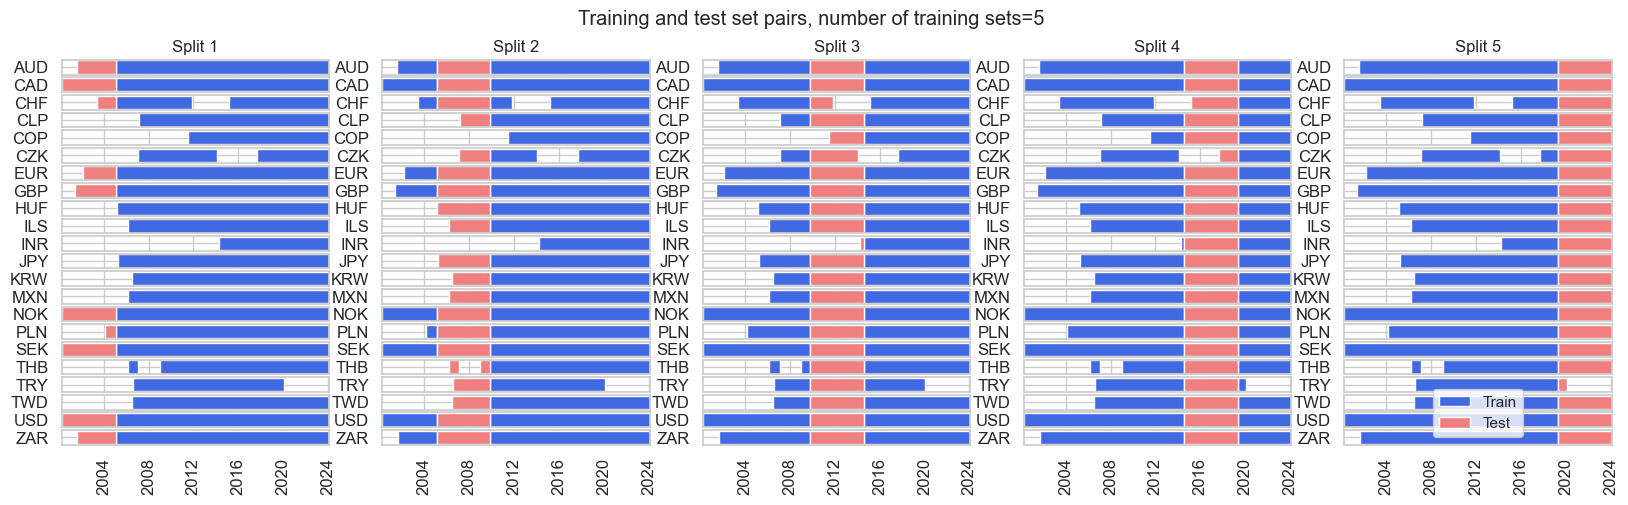

In [58]:
split_rkf = msl.RollingKFoldPanelSplit(n_splits=5)
split_rkf.visualise_splits(X, y)

### `RecencyKFoldPanelSplit()`

The `RecencyKFoldPanelSplit` class produces paired training and test splits, created for a data panel. It is similar to the `ExpandingKFoldPanelSplit`, being an expanding splitter where the number of folds is specified. However, the size of each test set, in terms of the number of periods at native dataset frequency, is also specified. Given parameters `n_splits` and `n_periods`, the last `n_splits` $\times$ `n_periods` time periods in the panel are divided into `n_splits` test sets, each containing `n_periods` time periods.

The respective training set for each test set comprises all dates in the panel prior to the test set.

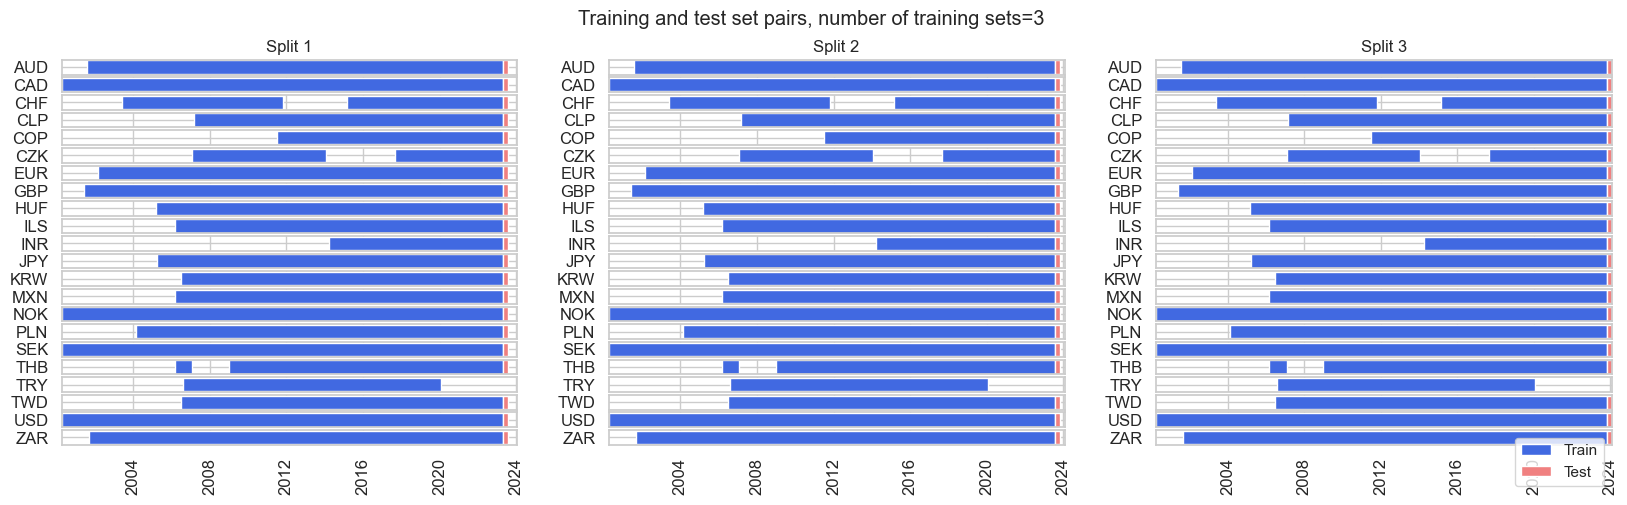

In [59]:
split_rekf = msl.RecencyKFoldPanelSplit(n_splits=3, n_periods = 3)
split_rekf.visualise_splits(X, y)

## Model evaluation

Performance metrics are required in order to evaluate whether a model is fit-for-purpose. In `scikit-learn` lingo, a "metric" is a function of model predictions and "ground truth" labels, whilst a "scorer" accepts three parameters: an already-fitted `scikit-learn` estimator, a feature matrix on which the estimator will make predictions and a vector of "ground truth" labels.

Either a metric or scorer can be used in isolation to assess model fit, or it can be used within cross-validation to estimate the expected out-of-sample metric/score. 

### Metrics

The `macrosynergy.learning` subpackage contains a collection of custom metrics that are compatible with `scikit-learn`. All such metrics are implemented as functions accepting two arguments: `y_true`, the true targets in a supervised learning problem, and `y_pred`, the predicted targets by a trained model. These are:

* `regression_accuracy()`: computes the accuracy between the signs of predictions and targets.
* `regression_balanced_accuracy()`: computes the balanced accuracy between the signs of predictions and targets.
* `panel_significance_probability()`: computes the significance probability of correlation after fitting a linear mixed effects model between predictions and true targets, accounting for cross-sectional correlations present in the panel. See the research piece '[Testing macro trading factors](https://research.macrosynergy.com/testing-macro-trading-factors/)' for more information.
* `sharpe_ratio()`: computes a naive Sharpe ratio based on the model predictions.
* `sortino_ratio()`: computes a naive Sortino ratio based on the model predictions.
* `correlation_coefficient()`: computes a specified correlation coefficient between model predictions and "ground truth" labels. Available correlation coefficients are "pearson", "spearman" and "kendall".

All of the above metrics, with exception of `panel_significance_probability`, can be calculated with respect to cross-sectional or time-period panel axes. For instance, an accuracy score can be calculated based on all samples. Alternatively, one can calculate accuracies for each cross-section and return the sample average, and likewise based on time periods. These two options estimate expected accuracy for a cross-section, or a time period, respectively. This functionality can be achieved by specifying `type='cross_section'` or `type='time_periods'` in the metric definition. 

Generally, there may be a metric available in `scikit-learn` that one desires to easily convert to a panel metric that allows for cross-sectional/time-period evaluation. In that case, we provide the `create_panel_metric()` function that accepts `y_true`, `y_pred`, an existing `scikit-learn` metric and the `type`. This evaluates the metric on a given panel axis. An example is shown in the below code cell. 

In [60]:
# Fit a linear regression model and make predictions
lr = LinearRegression().fit(X, y)
y_pred = lr.predict(X)

# Calculate expected in-sample R2 metric for a given cross-section
msl.create_panel_metric(
    y_true = y,
    y_pred = y_pred,
    sklearn_metric = r2_score,
    type = "cross_section"
)

np.float64(0.012829318039806092)

### Scorers

Only a single scorer is currently provided in `macrosynergy.learning`, called `neg_mean_abs_corr`. Below are the listed parameters for this function, with explanation:

* `estimator` is an already-fitted, custom, linear `scikit-learn` regression model that subclasses `BaseRegressionSystem` within the `macrosynergy.learning` subpackage. This model fits a linear model on each cross-section, subject to data availability. Consequently, `estimator` stores a beta for each cross-section. 
* `X_test` is a multi-indexed panel of benchmark returns. It is named as such because it is generally expected for this to be out-of-sample, although in-sample statistics can also be computed. 
* `y_test` is a multi-indexed panel of returns, paired with `X_test`.  

Given a collection of estimated betas held within `estimator`, hedged returns can be calculated for each cross-section in `X_test`. To evaluate quality of the hedge, the absolute correlation between hedged returns and benchmark returns is calculated for each cross-section. As a summary for overall performance over the panel, the mean of these absolute correlations are returned over all cross-sections. Lastly, this quantity is multiplied by minus one, since scorers are intended to be maximised within `scikit-learn`. 

## Preprocessing

The `macrosynergy.learning.preprocessing` folder comprises various methods to manipulate the input panel of indicators in a statistical machine learning pipeline, preprocessing them in a number of possible manners before passing the transformed indicators into a predictive model. 

Broadly, we categorise the possible preprocessing methods into `selectors`, `scalers` and `transformers`.

### Feature selectors 

A `scikit-learn` pipeline can incorporate a layer of feature selection. We provide some custom selectors in the `macrosynergy.learning` subpackage for use over a panel. 

* `LarsSelector`: selects features through the LARS algorithm. The number of factors to be selected, `n_factors`, as well as the boolean choice of including an intercept in the LARS model, `fit_intercept`, are the only class initialisation parameters.
* `LassoSelector`: selects features through a LASSO regression. The number of factors to be selected, `n_factors`, as well as the boolean choice to enforce a `positive` restriction, is required. 
* `MapSelector`: selects features based on significance from the Macrosynergy panel test. Either the number of factors to be selected, `n_factors`, or a p-value significance threshold, `significance_level`, is required, as well as the boolean choice of a `positive` restriction. For more information on the panel test, see the research piece '[Testing macro trading factors](https://research.macrosynergy.com/testing-macro-trading-factors/)'.

In [61]:
# Keep only factors that a significant at the 5% level based on the MAP test. 
map_test = msl.MapSelector(significance_level=0.05).fit(X, y)
map_test.transform(X)

XPCG_NEG_ZN4
cid real_date               
AUD 2001-07-31     -0.652388
    2001-08-31     -0.552456
    2001-09-28     -0.332318
    2001-10-31     -0.303837
    2001-11-30     -0.462791
...                      ...
ZAR 2023-08-31     -0.218567
    2023-09-29     -0.161383
    2023-10-31      0.214650
    2023-11-30      0.132334
    2023-12-29      0.296763

[4957 rows x 1 columns]

### Feature scalers

Some learning algorithms require the data passed in as inputs to be scaled. If this is not done, it can slow convergence of a learning algorithm (such as stochastic gradient descent) or it can lead to incorrect results (for instance, in a PCA). The following selectors are currently implemented in the package:

* `PanelStandardScaler`: transforms features by subtracting historical mean and dividing by historical standard deviation. 
* `PanelMinMaxScaler`: transforms features by normalizing them between zero and one. 

Both classes admit a `type` parameter, with default `type='panel'` to calculate the mean/std, or min/max over the panel for scaling, or `type='cross_section'` to scale within each cross-section and concatenate each of the scaled cross-sectional features to reconstruct the panel.

In [62]:
# Scale by training mean and standard deviation
msl.PanelStandardScaler().fit_transform(X)

XGDP_NEG_ZN4  XCPI_NEG_ZN4  XPCG_NEG_ZN4  RYLDIRS05Y_NSA_ZN4
cid real_date                                                               
AUD 2001-07-31      1.094359     -1.244544     -0.344048            0.778155
    2001-08-31      0.950786     -1.618693     -0.232842            0.760588
    2001-09-28      0.753928     -1.624044      0.012131            0.542619
    2001-10-31      0.823693     -1.641732      0.043825            0.464518
    2001-11-30      0.677303     -0.528103     -0.133061            0.344806
...                      ...           ...           ...                 ...
ZAR 2023-08-31     -0.338852     -0.293356      0.138715            2.000433
    2023-09-29     -0.138448     -0.008998      0.202351            1.926326
    2023-10-31     -0.333332      0.043649      0.620807            2.377131
    2023-11-30     -0.195051     -0.082970      0.529205            2.197428
    2023-12-29     -0.081955     -0.211659      0.712184            1.705542

[4957 rows x 4 columns]

### Feature transformers

All other preprocessing classes are placed under the general tag of "transformers". We provide two such classes:

* `PanelPCA`: transforms features through principal component analysis and returns a multi-indexed dataframe. It admits the following parameters:
    * `n_components`: when an integer is provided, the first `n_components` principal components are kept. When the value is a float between 0 and 1, the number of components that cumulatively explain at most the proportion `n_components` of total feature variation are kept.  
    * `kaiser_criterion`: if True, this parameter overrides `n_components` and keeps only the components with associated eigenvalues greater than one. 
    * `adjust_signs`: if True, each eigenvector is multiplied by either one or minus one to ensure its projected component is positively correlated with a target vector, if provided. This is done to encourage consistency in eigenvector direction when used in a sequential pipeline.
* `ZnScoreAverager` (**deprecated and to be replaced in a future release**) performs point-in-time zn-scoring (see section on `make_zn_scores`) for each feature and averages the result to form a composite signal.

In [63]:
# Scale dataframe before applying PCA
pipe = Pipeline([
    ("scaler", msl.PanelStandardScaler()),
    ("pca", msl.PanelPCA(n_components=2)),
]).fit(X,y)

pipe.transform(X)

PCA 1     PCA 2
cid real_date                     
AUD 2001-07-31  1.045595 -1.462083
    2001-08-31  1.174145 -1.416631
    2001-09-28  0.936255 -1.202028
    2001-10-31  0.864951 -1.263227
    2001-11-30  0.401310 -0.826625
...                  ...       ...
ZAR 2023-08-31  1.302237 -0.014870
    2023-09-29  1.042822 -0.126402
    2023-10-31  1.063760  0.010921
    2023-11-30  1.047096 -0.128932
    2023-12-29  0.682439 -0.205696

[4957 rows x 2 columns]

Within a `scikit-learn` pipeline, it is often useful to transform features into new ones - for instance scaling and/or averaging. The `macrosynergy.learning` subpackage contains some custom transformers:

* `PanelStandardScaler`: transforms features by subtracting historical mean and dividing by historical standard deviation. 
* `PanelMinMaxScaler`: transforms features by normalizing them between zero and one. 
* `FeatureAverager`: condenses features into a single feature through averaging. 

## Forecasting

The `macrosynergy.learning.forecasting` submodule comprises a collection of `scikit-learn`-compatible predictor classes that convert a collection of preprocessed features into predictions. The following conventional predictor classes are provided in the package:

* `NaiveRegressor`: a naive predictor class that simply returns the average of the input features, for each cross-section and timestamp.
* `LADRegressor`: a linear model that estimates parameters by minimising the mean absolute deviations between predictions and provided targets. 
* `SignWeightedLADRegressor`: a weighted LAD regression model that equalises the importance of negative return with positive return historical samples, removing a possible sign bias learnt by the model. 
* `TimeWeightedLADRegressor`: a weighted LAD regression model that increases the importance of more recent samples, by specifying a `half-life` of exponentially decaying weights with time for each historical sample.
* `SignWeightedLinearRegression`: a weighted least squares linear regression model that equalises the importance of negative return with positive return historical samples, removing a possible sign bias learnt by the model. 
* `TimeWeightedLinearRegression`: a weighted least squares linear regression model that increases the importance of more recent samples, by specifying a `half-life` of exponentially decaying weights with time for each historical sample.

### Modified regressors

Linear model coefficients exhibit greater variability when small amounts of data are available than otherwise. As a consequence, it can be a reasonable idea to adjust linear model coefficients to account for their statistical precision, creating an auxiliary factor model. This is done by estimating standard errors and dividing coefficients by these (with an offset in the event of small standard errors). As a consequence, imprecise coefficients are shrunk, whilst precise coefficients are inflated.

A key point is that the output of the auxiliary factor model is not an appropriate prediction, but it is a valid signal. To distinguish between these two concepts in the classes, we leave the `predict()` method to make predictions using the unadjusted factor model, whilst we introduce a `create_signal()` method to output signals based on the adjusted factor model. 

All such regressors have a `method` parameter that accepts either `method='analytic'` or `method='bootstrap'`, where standard errors are either computed through a standard analytic formula, or via the bootstrap. 

Below is a list of modified regressors in `macrosynergy.learning.forecasting`:

* `ModifiedLinearRegression`: coefficient-adjusted OLS linear regression model.
* `ModifiedSignWeightedLinearRegression`: coefficient-adjusted SWLS linear regression model.
* `ModifiedTimeWeightedLinearRegression`: coefficient-adjusted TWLS linear regression model. 

### Regressor systems

The regressor systems in `macrosynergy.learning.forecasting` fit a regression model on each cross-section of a panel, inheriting from `msl.BaseRegressionSystem`. Below are the currently implemented systems of regressions:

* `LinearRegressionSystem`: fits a linear regression model on each cross-section of a panel. Stores coefficients and intercepts for each cross-section when only a single feature is in the model. 
* `LADRegressionSystem`: fits a LAD regression model on each cross-section of a panel. Stores coefficients and intercepts for each cross-section when only a single feature is in the model. 
* `RidgeRegressionSystem`: fits a Ridge regression model on each cross-section of a panel. Stores coefficients and intercepts for each cross-section when only a single feature is in the model. 
* `CorrelationVolatilitySystem`: estimates betas through fitting moving average correlation and volatility estimators. This is used solely for the purpose of beta estimation. 

## Sequential

The `macrosynergy.learning.sequential` submodule contains classes that simulate the experience of a trader using statistical machine learning to create trading signals over time and point-in-time, producing a valid backtest. 

### Signal optimizer

The `SignalOptimizer` class is used for sequential model selection, fitting, optimization and forecasting based on quantamental panel data. 

Three use cases are discussed in detail in the notebook [Signal optimization basics](https://academy.macrosynergy.com/academy/Data%20science/Signal%20optimization%20basics/_build/html/Signal%20optimization%20basics.php):

- Feature selection chooses from candidate features to combine them into an equally weighted score
- Return prediction estimates the predictive relation of features and combines them in accordance with their coefficient into a single prediction.
- Classification estimates the relation between features and the sign of subsequent returns and combines their effect into a binary variable of positive or negative returns.

Below, we showcase the second case, focusing on the principals of generation of an optimized regression-based signal:

The constructor of `SignalOptimizer` constructs a wide format dataframe that makes supervised learning amenable over a panel. Under the hood, it calls the same `categories_df` function that was used earlier to create the necessary dataframes. Hence all major arguments for `categories_df` can be passed into `SignalOptimizer` to initialize an object.

There is only a single additional argument that can be provided:
- `generate_labels`: a function applied to the target vector that `categories_df` creates. Specification of a function here means that the transformed target vector is used for the supervised labels. One use case is directional classification of returns, where a positive return is transformed to a 1, and a negative return is transformed to a -1. In this case, one would set `generate_labels = lambda x: 1 if x >= 0 else -1`.

In [64]:
so_reg = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cids_dux,
    freq = "M",
    lag = 1,
    blacklist = fxblack,
    xcat_aggs=["last", "sum"],
)

so_reg.X

XGDP_NEG_ZN4  XCPI_NEG_ZN4  XPCG_NEG_ZN4  RYLDIRS05Y_NSA_ZN4
cid real_date                                                               
AUD 2001-07-31      1.641867     -1.798581     -0.652388            1.014798
    2001-08-31      1.456932     -2.302273     -0.552456            1.001587
    2001-09-28      1.203363     -2.309478     -0.332318            0.837669
    2001-10-31      1.293226     -2.333290     -0.303837            0.778935
    2001-11-30      1.104662     -0.834081     -0.462791            0.688909
...                      ...           ...           ...                 ...
ZAR 2023-08-31     -0.204233     -0.518056     -0.218567            1.933981
    2023-09-29      0.053905     -0.135242     -0.161383            1.878251
    2023-10-31     -0.197123     -0.064367      0.214650            2.217267
    2023-11-30     -0.019005     -0.234827      0.132334            2.082126
    2023-12-29      0.126673     -0.408072      0.296763            1.712215

[4957 rows x 4 columns]

#### `calculate_predictions()`

The `calculate_predictions()` method calculates and stores predictions for sequentially optimized models, hyperparameters and parameters. Model and hyperparameter selection is performed based on the principles of cross-validation. Information regarding model and hyperparameter selection, feature importances, model coefficients, feature selection and transformed feature correlations are stored within the class instance, for explainability. 

Important parameters here are: 

- `name` is a label identifying the specific signal optimization process,
- `models` is dictionary of scikit-learn predictors or pipelines that contains choices for the type of model to be deployed,
- `hyperparameters` is a nested dictionary defining the hyperparameters to consider for each model type,
- `scorers` is a dictionary of `scikit-learn`-compatible scorer functions used to evaluate a model in the model selection stage,
- `inner_splitters` is a dictionary of cross-validation splitters provided to the cross-validation module. When multiple inner splitters are provided, all splits provided by the splitters are concatenated. For instance, two 5-fold CVs are combined to form a 10-fold CV, 
- `search_type` can be provided to specify a type of hyperparameter search to undertake. Current available choices are `grid` to perform a grid search and `prior` to perform a randomized search where priors can be placed.
- `normalize_fold_results` is a boolean flag denoting whether or not to standardize cross-validation fold scores for a given metric and CV fold. This is useful to make cross-validation results comparable across folds, which can correspond to different market regimes and stages of the business cycle. 
- `cv_summary` can be provided to specify how to aggregate cross-validation scores across folds, for different models. Default is `cv_summary = 'mean'`, but other options available are `'median'`, `'mean-std'` and `'mean/std'`. Alternative, a callable can be passed into `cv_summary`, directly specifying the type of aggregation. 
- `min_cids`, `min_periods`, `max_periods` and `test_size` have equivalent meaning as in `ExpandingIncrementPanelSplit()`
- `split_functions` is an optional dictionary that can be provided used to increment the number of cross-validation folds for a given splitter, as a function of the number of time periods (at native dataset frequency) passed in the pipeline. Consequently, keys must match those provided in `inner_splitters`. For instance, to increase the number of folds by one every year on a monthly dataset, one would set `split_functions = {"splitter1": lambda n: n // 12}`. Importantly, this specifies the number of splits to add onto the initial number of provided splits, as a function of time, as opposed to the number of splits itself.
- `store_correlations` is a boolean that can be provided to store a matrix of correlations at each retraining date, between features being passed into a final predictor and those entered into the original pipeline. This is necessary because some transformations (e.g. PCA) can be nontrivial. 

In order to showcase the different options that `SignalOptimizer` provides, we construct a pipeline that involves feature scaling, feature selection and predictor training.  

In the below example, we train a Ridge regression model sequentially over the realized trading history. At each retraining date (every three months), the data is scaled, a single feature is removed from the training set and a Ridge regression is selected out of 50 candidate `alpha` hyperparameters. This is done by equally considering the $R^{2}$ and balanced accuracy metrics in a cross-validation that combines splits generated by our `RollingKFoldPanelSplit` and `ExpandingKFoldPanelSplit` splitters. The expanding splitter is initialized with three splits and the rolling initialized with five. For the expanding splitter, 3 folds are created for the first 3 years of the backtest, after which five folds are generated. Consequently, an 8-fold cross-validation is performed in the first three years, after which a 10-fold CV is performed for the remainder of the training history. 

In [65]:
mods_reg = {
    "ridge": Pipeline([
        ('scaler', msl.PanelStandardScaler()),
        ('selector', msl.LarsSelector(n_factors = 3)),
        ('model', Ridge()),
    ]),
}

grids_reg = {
    "ridge": {
        "model__alpha": list(np.logspace(-4, 4, 25))
    },
}

scorers_reg = {
    "R2": make_scorer(r2_score, greater_is_better=True),
    "BAC": make_scorer(msl.regression_balanced_accuracy, greater_is_better=True),
}

splitters_reg = {
    "Expanding": msl.ExpandingKFoldPanelSplit(n_splits = 3),
    "Rolling": msl.RollingKFoldPanelSplit(n_splits = 5),
}

so_reg.calculate_predictions(
    name = "MACRO_OPTREG",
    models = mods_reg,
    hyperparameters = grids_reg,
    scorers = scorers_reg,
    inner_splitters = splitters_reg,
    search_type = "grid",
    normalize_fold_results = True,
    cv_summary = "median",
    test_size = 3,
    min_cids=4,
    min_periods=36,
    split_functions = {"Expanding": lambda n: 0 if n < 12 * 3 else 2, "Rolling": None}
)

  0%|          | 0/84 [00:00<?, ?it/s]

#### `models_heatmap()` 

The `models_heatmap` method of the `SignalOptimizer` class visualizes optimal models used for signal calculation over time. If many models have been considered, their number can be limited by the `cap` argument.

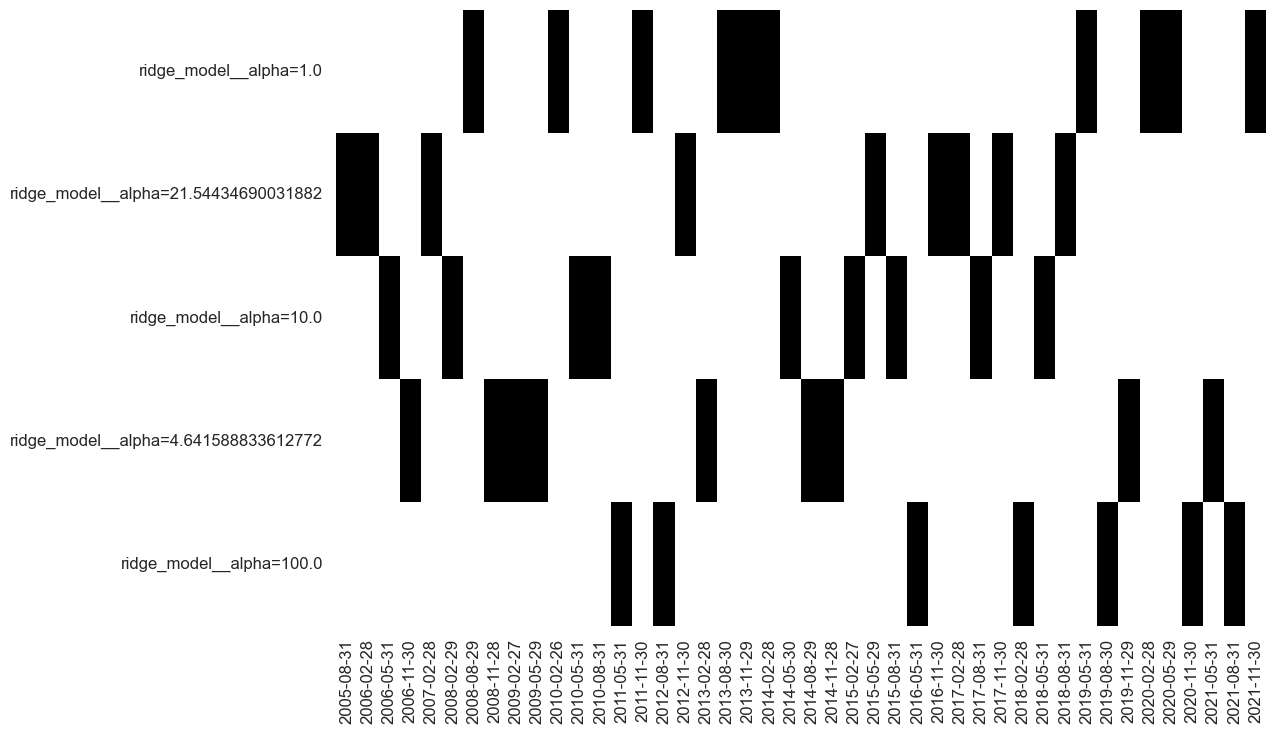

In [66]:
so_reg.models_heatmap("MACRO_OPTREG")

#### `feature_selection_heatmap()`

The `feature_selection_heatmap` method of the `SignalOptimizer` class visualizes the features that were selected over time by the last selector in a `scikit-learn` pipeline if it is of the appropriate time, such as the `LassoSelector`.

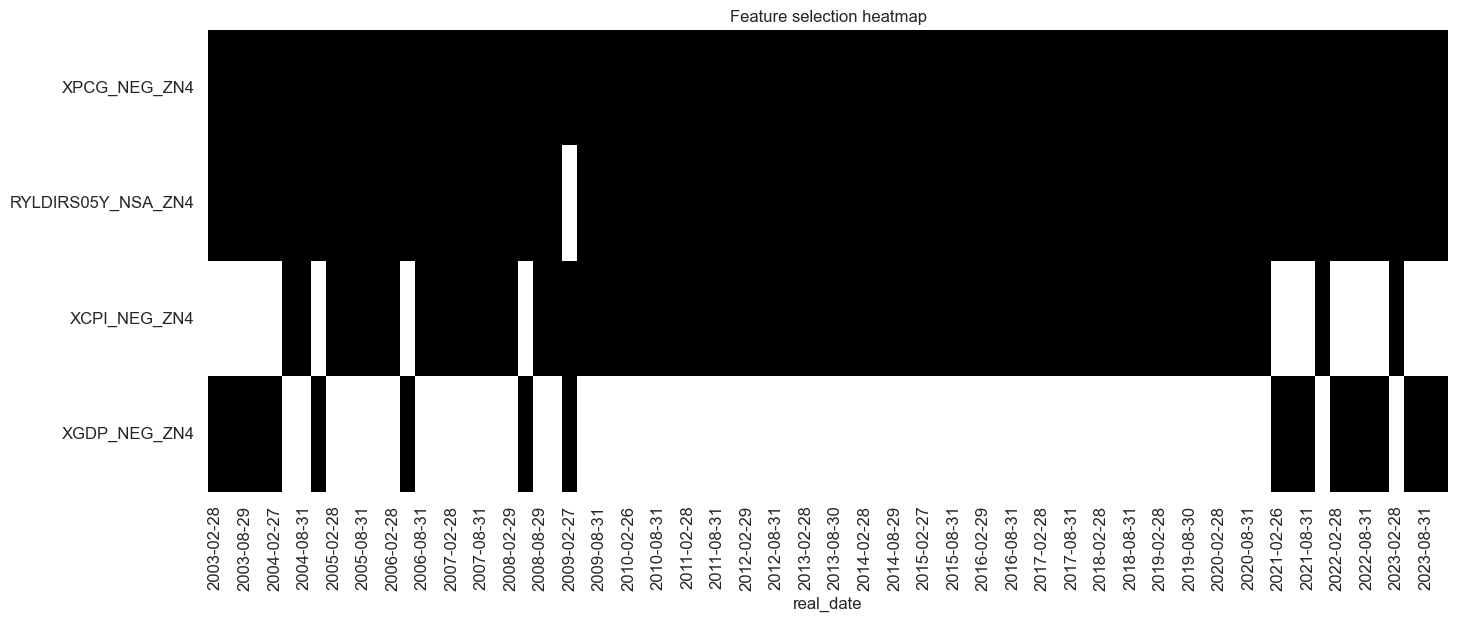

In [67]:
so_reg.feature_selection_heatmap(
    name="MACRO_OPTREG", title="Feature selection heatmap", figsize=(16, 6)
)

#### `coefs_timeplot()`

The `coefs_timeplot` method creates a time plot of linear model regression coefficients for each feature. For these statistics to be recorded, the underlying `scikit-learn` predictor class (in this case, `LinearRegression`) must contain `coef_` and `intercept_` attributes. 

Gaps in the lines appear either when a model without the required attributes (e.g. a KNN or Random Forest) is selected or a feature selector (in this case, `LassoSelector`) doesn't select these features.

In [68]:
#so_reg.coefs_timeplot(name="MACRO_OPTREG", figsize=(16, 6))

#### `coefs_stackedbarplot()`

The `coefs_stackedbarplot()` method is an alternative to `coefs_timeplot()` and displays a stacked bar plot of average annual model coefficients over time.  

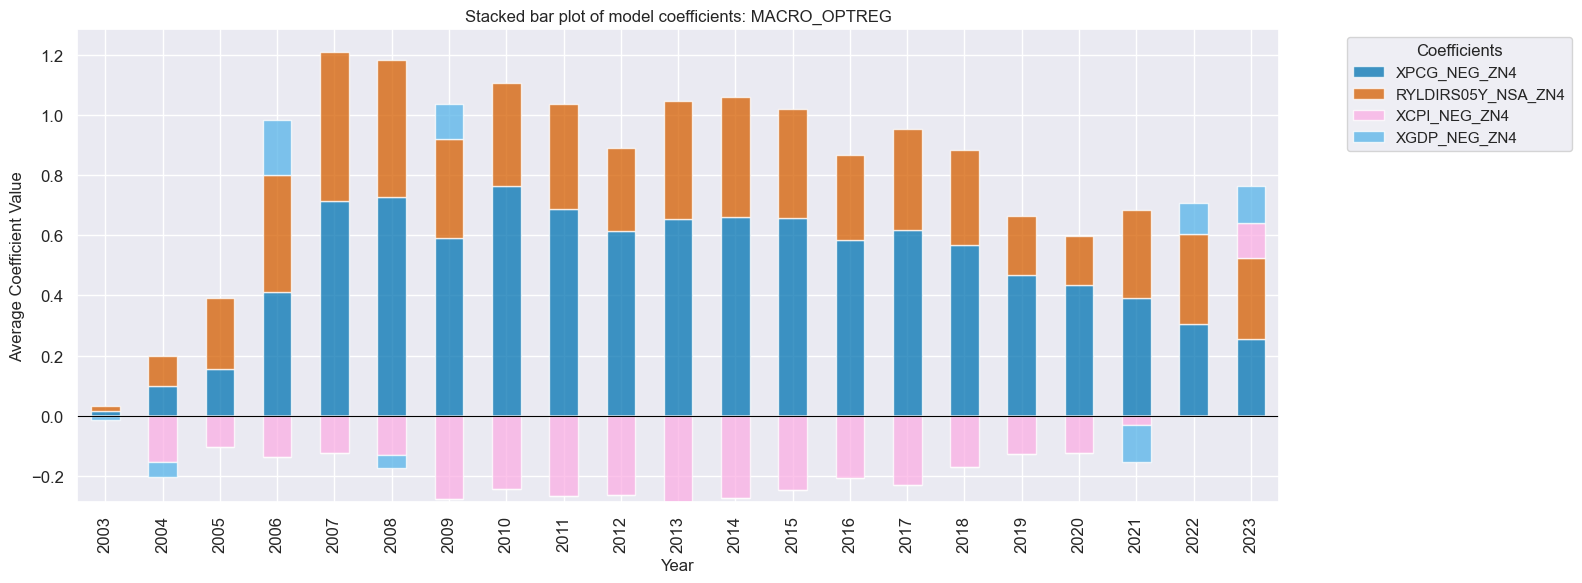

In [69]:
so_reg.coefs_stackedbarplot(name="MACRO_OPTREG", figsize=(16, 6))

#### `intercepts_timeplot()`

Similarly to model coefficients, changing model intercepts can be visualised over time through a timeplot using the `intercepts_timeplot()` method.

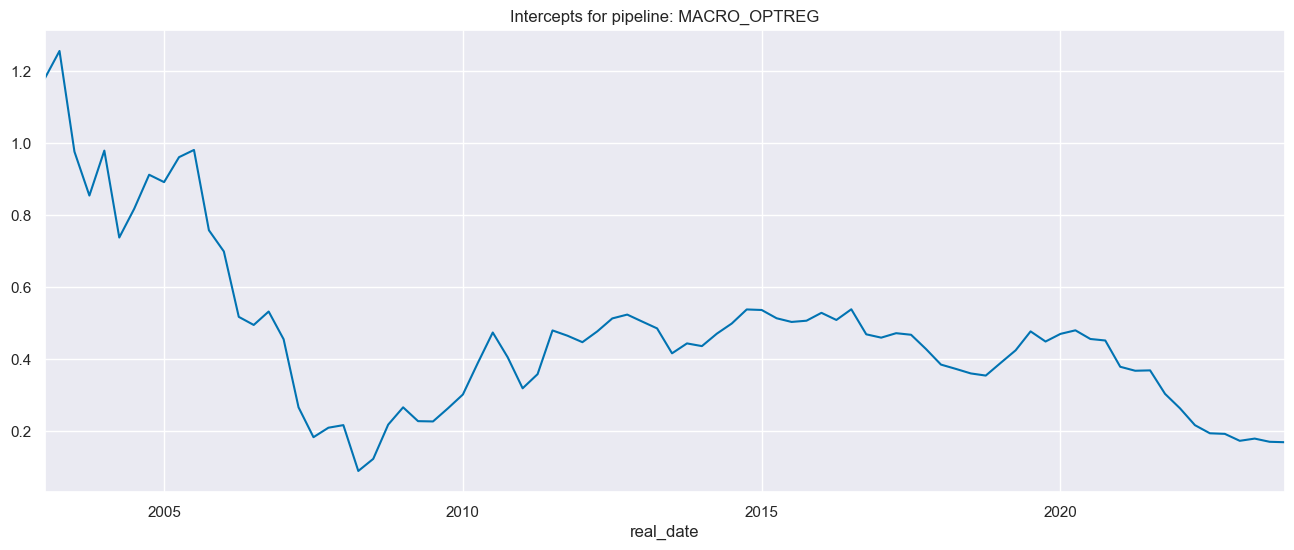

In [70]:
so_reg.intercepts_timeplot(name="MACRO_OPTREG", figsize=(16, 6))

#### `nsplits_timeplot()`

The `nsplits_timeplot()` displays number of cross-validation splits that are applied over time. This is useful if `split_functions` was specified when running a pipeline. 

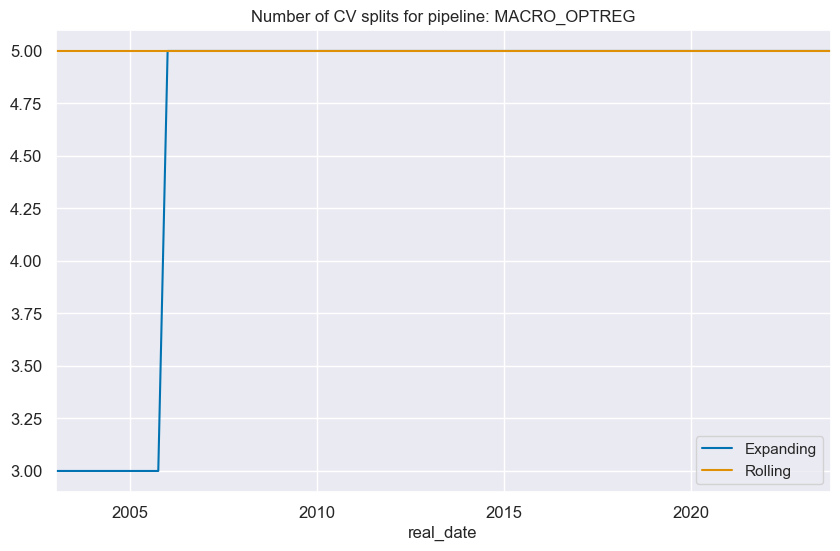

In [71]:
so_reg.nsplits_timeplot(name="MACRO_OPTREG")

In [72]:
dfx = msm.update_df(dfx, so_reg.get_optimized_signals("MACRO_OPTREG"))

#### `correlations_heatmap()`

When `store_correlations` is set to `True` in a pipeline entered within `calculate_predictions`, a correlation matrix between all features entering a pipeline and all features entering the final estimator in a pipeline is calculated and stored at each rebalancing date. This allows the user to get an idea of what features are being learnt when implicit feature transformations occur within the pipeline. One example would be the projection of input data to linear discriminants, with the projected data passed into a final model. Another example would be the use of PCA. 

### Beta estimator

The `BetaEstimator` class is used to calculate sequential betas for each cross-section of a financial market return panel, with respect to a benchmark ticker. Out-of-sample hedged returns are calculated between model refreshing dates. The same model selection process that `SignalOptimizer` uses is used to select between candidate models from which coefficients are extracted. 

The constructor of `BetaEstimator` constructs a wide format dataframe where the benchmark ticker, the sole predictor of concurrent market returns, is replicated across all return cross-sections in the panel. In the below example, we compute betas for each cross-section of our FX forward returns with respect to S&P 500 futures. 

In [73]:
be = msl.BetaEstimator(
    df = dfx,
    xcats = ["FXXR_NSA"],
    benchmark_return = "USD_EQXR_NSA",
    cids = cids,
)

be.X

EQXR_NSA
cid     real_date           
AUDvUSD 2000-01-03 -1.172349
        2000-01-04 -3.749659
        2000-01-05  0.120414
        2000-01-06 -0.672091
        2000-01-07  4.024217
...                      ...
ZARvUSD 2023-12-07  0.735294
        2023-12-08  0.392200
        2023-12-11  0.401519
        2023-12-12  0.426935
        2023-12-13  1.345316

[143067 rows x 1 columns]

#### `estimate_beta()`

The `estimate_beta()` method is used to calculate betas and estimate out-of-sample hedged returns at a given retraining frequency. Model and hyperparameter selection is performed based on cross-validation, using the same learning pipeline as `SignalOptimizer`. Information regarding model and hyperparameter selection are stored in the class instance.

Many parameters for `estimate_beta()` are also used for the `calculate_predictions()` method within `SignalOptimizer`. The only parameters that differ are:

* `beta_xcat`: The category name for stored estimated betas. 
* `hedged_return_xcat`: The category name for stored out-of-sample hedged returns.

These are provided instead of the `name` parameter in `calculate_predictions()`. Moreover, the `store_correlations` parameter in that method is not a valid parameter for `estimate_beta()`. Lastly, the `models` dictionary provided in `estimate_beta` expects models to inherit from the `BaseRegressionSystem` class in `macrosynergy.learning`, to ensure that different models are fit on different cross-sections, resulting in diverse betas amongst cross-sections.

In [74]:
mods_be = {
    "LR": msl.RidgeRegressionSystem(
        fit_intercept = True,
        alpha = 1,
        positive = False,
        roll = "full",
        data_freq = "M",
    )
}

grids_be = {
    "LR": {
        "alpha": [1, 10, 100, 1000, 10000]
    }
}

scorers_be = {
    "neg_mean_abs_corr": msl.neg_mean_abs_corr
}

splitters_be = {
    "Expanding": msl.ExpandingKFoldPanelSplit(n_splits = 10),
}

be.estimate_beta(
    beta_xcat="BETA_NSA",
    hedged_return_xcat="HEDGED_RETURN_NSA",
    models = mods_be,
    hyperparameters = grids_be,
    scorers = scorers_be,
    inner_splitters = splitters_be,
    search_type = "grid",
    normalize_fold_results=True,
    min_cids = 4,
    min_periods = 60,
    est_freq = "Y",
)

  0%|          | 0/24 [00:00<?, ?it/s]

#### `models_heatmap()`

The `models_heatmap` method of the `BetaEstimator` class visualizes optimal models used for beat estimation over time. If many models have been considered, their number can be limited by the `cap` argument.

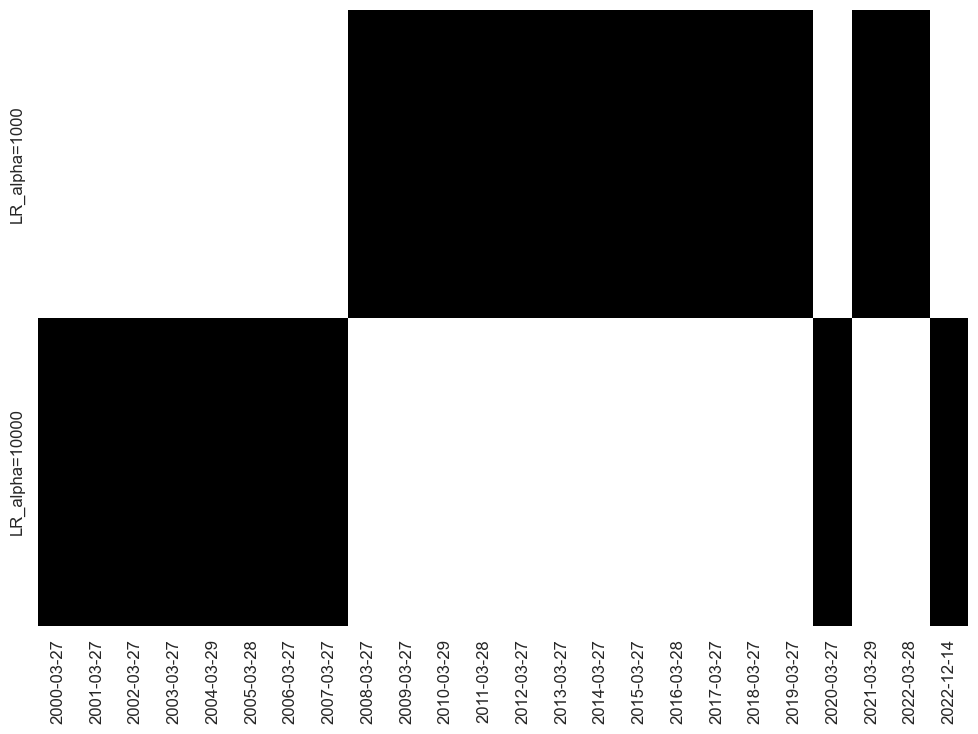

In [75]:
be.models_heatmap("BETA_NSA")

#### `get_betas()`

The `get_betas()` method can be used to extract the calculated panel of betas.

In [76]:
be.get_betas("BETA_NSA")

real_date  cid      xcat     value
0      2000-03-24  AUD  BETA_NSA  0.001513
1      2000-03-27  AUD  BETA_NSA  0.001513
2      2000-03-28  AUD  BETA_NSA  0.001513
3      2000-03-29  AUD  BETA_NSA  0.001513
4      2000-03-30  AUD  BETA_NSA  0.001513
...           ...  ...       ...       ...
141559 2023-12-07  ZAR  BETA_NSA  0.148055
141560 2023-12-08  ZAR  BETA_NSA  0.148055
141561 2023-12-11  ZAR  BETA_NSA  0.148055
141562 2023-12-12  ZAR  BETA_NSA  0.148055
141563 2023-12-13  ZAR  BETA_NSA  0.148055

[141564 rows x 4 columns]

#### `get_hedged_returns()`

The `get_hedged_returns()` method can be used to extract the calculated panel of hedged returns.

In [77]:
be.get_hedged_returns("HEDGED_RETURN_NSA")

real_date  cid               xcat     value
0      2000-03-27  AUD  HEDGED_RETURN_NSA  0.974328
1      2000-03-28  AUD  HEDGED_RETURN_NSA  0.116838
2      2000-03-29  AUD  HEDGED_RETURN_NSA -0.502007
3      2000-03-30  AUD  HEDGED_RETURN_NSA  0.217239
4      2000-03-31  AUD  HEDGED_RETURN_NSA -0.815216
...           ...  ...                ...       ...
143376 2023-12-07  ZAR  HEDGED_RETURN_NSA  0.004454
143377 2023-12-08  ZAR  HEDGED_RETURN_NSA -0.642188
143378 2023-12-11  ZAR  HEDGED_RETURN_NSA -1.027354
143379 2023-12-12  ZAR  HEDGED_RETURN_NSA  0.245262
143380 2023-12-13  ZAR  HEDGED_RETURN_NSA -0.198436

[143381 rows x 4 columns]

#### `evaluate_hedged_returns()`

The `evaluate_hedged_returns()` method can be used to determine the average correlation between the calculated hedged returns and the inputted panel of contract returns. This gives a measure of the quality of hedge. Important parameters are:

* `hedged_return_xcat`: The name of the hedged return category calculated in the `BetaEstimator` instance.
* `correlation_types`: The type of correlation to calculate. This can be a string or array of strings with the only acceptable parameters being "pearson", "kendall" and "spearman".
* `blacklist`: Blacklisted periods that should be excluded from correlation calculation.
* `freqs`: String or list of strings of frequencies at which correlations are to be calculated.

In the below example, we can see that hedging has produced lower absolute correlations with the benchmark on average than the unadjusted returns, meaning that hedge was successful.

In [78]:
be.evaluate_hedged_returns(
    hedged_return_xcat="HEDGED_RETURN_NSA",
    correlation_types=["pearson", "kendall", "spearman"],
    blacklist = fxblack,
    freqs = ["M", "Q"],
)

pearson   kendall  spearman
benchmark return return category   frequency                              
USD_EQXR_NSA     HEDGED_RETURN_NSA M          0.216348  0.118425  0.173614
                                   Q          0.228891  0.129717  0.188563
                 FXXR_NSA          M          0.360946  0.227835  0.328630
                                   Q          0.385097  0.240037  0.342177

# Signaling

## SignalReturnRelations

The `SignalReturnRelations` class from the `macrosynergy.signal` module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns. 

Here are some key aspects and usage details of the SignalReturnRelations class:

- `sig` - the list of signals or the main signal category is specified using the sig argument. Each element of the list is being analyzed in relation to subsequent returns.
- `sig_neg` - takes a list of "True" and "False" values in relation to the list of signals. The default is False
- `ret` specifies the panel of subsequent returns that will be analyzed in relation to the specified signal category.
- `freq` denotes the frequency at which the series are sampled. The default is 'M' for monthly. The return series will always be summed over the sample period. The signal series will be aggregated according to the value of `agg_sig`
 - `agg_sig` specifies the aggregation method applied to the signal values in down-sampling. The default is "last". This can also be a list of various aggregation methods.

Unlike the `CategoryRelations` class, here, the focus is on a range of measures of association between signals and returns based on categorization (positive and negative returns) and parametric and nonparametric correlation.

This class applies frequency conversion, corresponding to a trading or rebalancing frequency. It also considers whether the signal is expected to predict returns positively or negatively. This is important for the interpretation of the output. One should also note that there is no regression analysis involved. This means that features should be entered with a meaningful zero value since the sign of the feature is critical for accuracy statistics.

In [79]:
dfx

cid              xcat  real_date     value
0        AUD  CPIC_SA_P1M1ML12 2000-01-03  1.244168
1        AUD  CPIC_SA_P1M1ML12 2000-01-04  1.244168
2        AUD  CPIC_SA_P1M1ML12 2000-01-05  1.244168
3        AUD  CPIC_SA_P1M1ML12 2000-01-06  1.244168
4        AUD  CPIC_SA_P1M1ML12 2000-01-07  1.244168
...      ...               ...        ...       ...
5678156  ZAR            XXRYLD 2023-12-08  3.205551
5678157  ZAR            XXRYLD 2023-12-11  3.295370
5678158  ZAR            XXRYLD 2023-12-12  2.879749
5678159  ZAR            XXRYLD 2023-12-13  3.347586
5678160  ZAR            XXRYLD 2023-12-14       NaN

[5678161 rows x 4 columns]

In [80]:
# Instantiate signal-return relations for the list of signals, multiple returns and frequencies

srr = mss.SignalReturnRelations(
    dfx,
    sigs=["MACRO_AVGZ", "MACRO_OPTREG", "XGDP_NEG_ZN4", "XCPI_NEG_ZN4", "XPCG_NEG_ZN4", "RYLDIRS05Y_NSA_ZN4"],
    cosp=True,
    rets=["DU05YXR_VT10", "EQXR_VT10", "FXXR_VT10"],
    freqs=["M"],
    blacklist=fxblack,
    slip=1
)


### Summary tables

The `.summary_table()` of the `SignalReturnRelations` class gives a short high-level snapshot of the strength and stability of the __main signal__ relation (the first signal in the list of signals `sigs`, with the first sign in the list of signs `sig_neg` and the first frequency in the list of frequencies `freqs`). Unless `sig_neg` had been set to `True` at instantiation, the relation is assumed to be positive.

The columns of the summary table generally have the following interpretations:

* **accuracy** is the ratio of correct predictions of the sign of returns to all predictions. It measures the overall accuracy of the signal's predictions, regardless of the class imbalance between positive and negative returns.
* **bal_accuracy** is the balanced accuracy, which takes into account the class imbalance of the dataset. It is the average of the ratios of correctly detected positive returns and correctly detected negative returns. The best value is 1 and the worst value is 0. This measure avoids inflated performance estimates on imbalanced datasets and is calculated as the average of sensitivity (true positive rate) and specificity (true negative rate). The formula with references is described [here](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)
* **pos_sigr** is the ratio of positive signals to all predictions. It indicates the long bias of the signal, or the percentage of time the signal is predicting a positive return. The value is between 0 (no positive signals) and 1 (all signals are positive).
* **pos_retr** is the ratio of positive returns to all observed returns. It indicates the positive bias of the returns, or the percentage of time the returns are positive. The value is between 0 (no positive returns) and 1 (all returns are positive).
* **pos_prec** is the positive precision, which measures the ratio of correct positive return predictions to all positive predictions. It indicates how well the positive predictions of the signal have fared. The best value is 1 and the worst value is 0. A high positive precision can be easily achieved if the ratio of positive returns is high, so it is important to consider this measure in conjunction with other measures such as bal_accuracy. See more info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* **neg_prec** is the negative precision, which measures the ratio of correct negative return predictions to all negative predictions. It indicates how well the negative predictions of the signal have fared. Generally, good positive precision is hard to accomplish if the ratio of negative returns has been high. The best value is 1 and the worst value is 0. See more info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* **pearson** is the Pearson correlation coefficient between signal and subsequent return. Like other correlation coefficients, Pearson varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship.
* **pearson_pval** is the probability that the (positive) correlation has been accidental, assuming that returns are independently distributed. Strictly speaking, this value returns a 2-tailed p-value for the null hypothesis that the correlation is 0. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are reasonable for large datasets. This statistic would be invalid for forward-moving averages.
* **kendall** is the Kendall rank correlation coefficient between signal and subsequent return. It is a non-parametric hypothesis test for statistical dependence. For those, who want to refresh their statistical knowledge, please read [here](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)
* **kendall_pval** is the probability that the (positive) correlation has been accidental, assuming that returns are independently distributed. As before, the test is a two-sided p-value for the null hypothesis that the correlation is 0. P-value below chosen threshold (usually 0.01 or 0.05) will allow us to reject the null hypothesis. This statistic would be invalid for forward-moving averages and for autocorrelated data.

The rows have the following meaning:

* **Panel** refers to the whole panel of cross-sections and sample period, excluding unavailable and blacklisted periods.
* **Mean years** is the mean of the statistic across all years.
* **Mean cids** is the mean of the statistic across all sections.
* **Positive ratio** represents the ratio of years, if following "Mean years" (or cross-sections - if following "Mean cids") for which the corresponding statistic was above its neutral level. The neutral level is defined as 0.5 for classification ratios (such as accuracy and balanced accuracy) and positive correlation probabilities, and 0 for correlation coefficients (such as Pearson and Kendall). For example, if the Positive ratio for accuracy is 0.7, it means that out of all the years (or cross-sections) analyzed, the correct sign of returns was predicted for 70% of them. If the Positive ratio for Pearson is 0.6, it indicates a strong positive correlation between the signal and returns.

In [81]:
srr.summary_table()

accuracy  bal_accuracy  pos_sigr  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54117       0.53584   0.55964   
Mean years                           0.53982       0.51577   0.56566   
Positive ratio                       0.87500       0.66667   0.58333   
Mean cids                            0.54078       0.53430   0.55354   
Positive ratio                       0.79167       0.79167   0.70833   

                                    pos_retr  pos_prec  neg_prec  pearson  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54894   0.58051   0.49118  0.11838   
Mean years                           0.55950   0.57856   0.45298  0.06187   
Positive ratio                       0.75000   0.79167   0.37500  0.83333   
Mean cids                            0.54746   0.57692   0.49168  0.11688   
Positive ratio                       0.87500   0.95833   0.50000  1.00000   

                                    pearson_pval  kendall  kendall_pval  \
M: MACRO_AVGZ/last => DU05YXR_VT10       0.00000  0.06557       0.00000   
Mean years                               0.34590  0.03738       0.34208   
Positive ratio                           0.66667  0.83333       0.58333   
Mean cids                                0.24035  0.06765       0.27746   
Positive ratio                           0.79167  0.91667       0.75000   

                                        auc  
M: MACRO_AVGZ/last => DU05YXR_VT10  0.53567  
Mean years                          0.51641  
Positive ratio                      0.66667  
Mean cids                           0.53326  
Positive ratio                      0.79167

Alternatively, for a one-line table, we can use `.single_relation_table()`. The first column lists the frequency ('D', 'W', 'M', 'Q', 'A') followed by the signal's name with `_NEG` meaning negative relationship and the name of the return.

In [82]:
srr.single_relation_table()

accuracy  bal_accuracy  pos_sigr  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54117       0.53584   0.55964   

                                    pos_retr  pos_prec  neg_prec  pearson  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54894   0.58051   0.49118  0.11838   

                                    pearson_pval  kendall  kendall_pval  \
M: MACRO_AVGZ/last => DU05YXR_VT10           0.0  0.06557           0.0   

                                        auc  
M: MACRO_AVGZ/last => DU05YXR_VT10  0.53567

The `cross_section_table()` method summarizes accuracy and correlation-related measures for the panel, the mean, and the individual cross-sections. It also gives a "positive ratio", i.e., the ratio of countries with evidence of positive relations, either in terms of above 50% accuracy, positive correlation, or - more restrictively - high positive correlation probabilities. As for the  `.summary_table()`, the `cross_section_table()` and `yearly_table()` analyzes the strength and stability of the __main signal__ relation (the first signal in the list of signals `sigs`, with the first sign in the list of signs `sig_neg` and the first frequency in the list of frequencies `freqs`). Unless `sig_neg` had been set to `True` at instantiation, the relation is assumed to be positive.

In [83]:
srr.cross_section_table()

accuracy  bal_accuracy  pos_sigr  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54117       0.53584   0.55964   
Mean                                 0.54078       0.53430   0.55354   
PosRatio                             0.79167       0.79167   0.70833   
AUD                                  0.53704       0.52816   0.56296   
CAD                                  0.50699       0.50482   0.53497   
CHF                                  0.52846       0.51408   0.66260   
CLP                                  0.51471       0.51876   0.43627   
COP                                  0.51974       0.52105   0.37500   
CZK                                  0.48899       0.49940   0.40529   
EUR                                  0.60148       0.59619   0.53875   
GBP                                  0.53846       0.52656   0.56294   
HUF                                  0.58148       0.58600   0.62593   
IDR                                  0.61458       0.57875   0.64583   
ILS                                  0.56279       0.53600   0.64186   
INR                                  0.49057       0.49228   0.54717   
JPY                                  0.48601       0.45272   0.65734   
KRW                                  0.58962       0.58428   0.62264   
MXN                                  0.56019       0.56166   0.47222   
NOK                                  0.48951       0.49146   0.46853   
NZD                                  0.55245       0.54406   0.71329   
PLN                                  0.57778       0.57350   0.57037   
SEK                                  0.58741       0.58402   0.52448   
THB                                  0.54688       0.54097   0.67188   
TRY                                  0.51875       0.51833   0.37500   
TWD                                  0.49528       0.49475   0.50472   
USD                                  0.55245       0.55418   0.46503   
ZAR                                  0.53704       0.52116   0.70000   

                                    pos_retr  pos_prec  neg_prec  pearson  \
M: MACRO_AVGZ/last => DU05YXR_VT10   0.54894   0.58051   0.49118  0.11838   
Mean                                 0.54746   0.57692   0.49168  0.11688   
PosRatio                             0.87500   0.95833   0.50000  1.00000   
AUD                                  0.57407   0.59868   0.45763  0.14594   
CAD                                  0.53147   0.53595   0.47368  0.04712   
CHF                                  0.54878   0.55828   0.46988  0.14791   
CLP                                  0.52941   0.55056   0.48696  0.07913   
COP                                  0.50000   0.52632   0.51579  0.03257   
CZK                                  0.55507   0.55435   0.44444  0.06826   
EUR                                  0.57565   0.66438   0.52800  0.21900   
GBP                                  0.59790   0.62112   0.43200  0.21831   
HUF                                  0.50370   0.56805   0.60396  0.14884   
IDR                                  0.64583   0.70161   0.45588  0.28118   
ILS                                  0.60465   0.63043   0.44156  0.02567   
INR                                  0.48113   0.47414   0.51042  0.09910   
JPY                                  0.59091   0.55851   0.34694  0.04647   
KRW                                  0.54245   0.60606   0.56250  0.15608   
MXN                                  0.52315   0.58824   0.53509  0.02787   
NOK                                  0.53147   0.52239   0.46053  0.12090   
NZD                                  0.53846   0.56373   0.52439  0.20586   
PLN                                  0.54074   0.60390   0.54310  0.23058   
SEK                                  0.57343   0.65333   0.51471  0.19205   
THB                                  0.53125   0.55814   0.52381  0.02509   
TRY                                  0.49375   0.51667   0.52000  0.02525   
TWD                                  0.55660   0.55140   0.43810  0.08079   
USD              

The `yearly_table()` method is useful for analyzing how the performance of a trading signal varies over time by providing a breakdown of performance metrics for each year. This can help identify whether the signal has been consistently strong over time or if specific market conditions have driven its performance. 

In [84]:
tbl_srr_year = srr.yearly_table()

In [85]:
tbl_srr_year.round(3)

accuracy  bal_accuracy  pos_sigr  \
M: MACRO_AVGZ/last => DU05YXR_VT10     0.541         0.536     0.560   
Mean                                   0.540         0.516     0.566   
PosRatio                               0.875         0.667     0.583   
2000                                   0.550         0.564     0.475   
2001                                   0.466         0.398     0.729   
2002                                   0.565         0.479     0.780   
2003                                   0.530         0.479     0.786   
2004                                   0.560         0.515     0.679   
2005                                   0.518         0.521     0.464   
2006                                   0.509         0.497     0.293   
2007                                   0.540         0.536     0.341   
2008                                   0.506         0.548     0.316   
2009                                   0.489         0.506     0.877   
2010                                   0.598         0.551     0.746   
2011                                   0.548         0.527     0.591   
2012                                   0.514         0.494     0.594   
2013                                   0.504         0.513     0.703   
2014                                   0.591         0.540     0.614   
2015                                   0.553         0.564     0.764   
2016                                   0.529         0.524     0.627   
2017                                   0.552         0.558     0.431   
2018                                   0.479         0.484     0.448   
2019                                   0.552         0.523     0.649   
2020                                   0.565         0.463     0.837   
2021                                   0.514         0.498     0.446   
2022                                   0.681         0.515     0.080   
2023                                   0.543         0.582     0.308   

                                    pos_retr  pos_prec  neg_prec  pearson  \
M: MACRO_AVGZ/last => DU05YXR_VT10     0.549     0.581     0.491    0.118   
Mean                                   0.560     0.579     0.453    0.062   
PosRatio                               0.750     0.792     0.375    0.833   
2000                                   0.775     0.842     0.286    0.095   
2001                                   0.602     0.546     0.250    0.122   
2002                                   0.643     0.634     0.324    0.090   
2003                                   0.577     0.568     0.389   -0.052   
2004                                   0.631     0.640     0.389   -0.008   
2005                                   0.542     0.564     0.478    0.061   
2006                                   0.474     0.471     0.524    0.008   
2007                                   0.476     0.523     0.548    0.050   
2008                                   0.597     0.663     0.433    0.167   
2009                                   0.482     0.483     0.529    0.089   
2010                                   0.620     0.646     0.457    0.129   
2011                                   0.623     0.645     0.409   -0.077   
2012                                   0.609     0.604     0.384    0.010   
2013                                   0.482     0.490     0.537    0.101   
2014                                   0.735     0.765     0.314    0.074   
2015                                   0.513     0.543     0.585    0.122   
2016                                   0.525     0.543     0.505    0.102   
2017                                   0.537     0.603     0.512    0.159   
2018                                   0.545     0.527     0.440    0.018   
2019                                   0.604     0.620     0.426    0.026   
2020                                   0.627     0.615     0.311   -0.035   
2021                                   0.351     0.350     0.647    0.075   
2022             

`multiple_relations_table()` is a method that compares multiple signal-return relations in one table. It is useful to compare the performance of different signals against the same return series (more than one possible financial return) and multiple possible frequencies. The method returns a table with standard columns used for  `single_relation_table()` and other tables, but the rows display different signals from the list of signals specified upon SignalReturnsRelations () `sigs`. The row names indicate the frequency ('D,' 'W,' 'M,' 'Q,' 'A') followed by the signal's and return's names. 

In [86]:
tbl_srr_multi=srr.multiple_relations_table()

In [87]:
tbl_srr_multi.round(3)

accuracy  bal_accuracy  \
Return       Signal             Frequency Aggregation                           
DU05YXR_VT10 MACRO_AVGZ         M         last            0.540         0.537   
             MACRO_OPTREG       M         last            0.547         0.537   
             RYLDIRS05Y_NSA_ZN4 M         last            0.536         0.525   
             XCPI_NEG_ZN4       M         last            0.519         0.517   
             XGDP_NEG_ZN4       M         last            0.526         0.523   
             XPCG_NEG_ZN4       M         last            0.514         0.529   
EQXR_VT10    MACRO_AVGZ         M         last            0.528         0.518   
             MACRO_OPTREG       M         last            0.567         0.515   
             RYLDIRS05Y_NSA_ZN4 M         last            0.513         0.478   
             XCPI_NEG_ZN4       M         last            0.546         0.537   
             XGDP_NEG_ZN4       M         last            0.510         0.502   
             XPCG_NEG_ZN4       M         last            0.467         0.495   
FXXR_VT10    MACRO_AVGZ         M         last            0.510         0.509   
             MACRO_OPTREG       M         last            0.530         0.527   
             RYLDIRS05Y_NSA_ZN4 M         last            0.523         0.517   
             XCPI_NEG_ZN4       M         last            0.503         0.501   
             XGDP_NEG_ZN4       M         last            0.512         0.510   
             XPCG_NEG_ZN4       M         last            0.501         0.507   

                                                       pos_sigr  pos_retr  \
Return       Signal             Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ         M         last            0.540     0.537   
             MACRO_OPTREG       M         last            0.782     0.538   
             RYLDIRS05Y_NSA_ZN4 M         last            0.693     0.538   
             XCPI_NEG_ZN4       M         last            0.527     0.538   
             XGDP_NEG_ZN4       M         last            0.543     0.538   
             XPCG_NEG_ZN4       M         last            0.348     0.538   
EQXR_VT10    MACRO_AVGZ         M         last            0.552     0.601   
             MACRO_OPTREG       M         last            0.779     0.601   
             RYLDIRS05Y_NSA_ZN4 M         last            0.664     0.601   
             XCPI_NEG_ZN4       M         last            0.546     0.601   
             XGDP_NEG_ZN4       M         last            0.540     0.601   
             XPCG_NEG_ZN4       M         last            0.361     0.601   
FXXR_VT10    MACRO_AVGZ         M         last            0.546     0.521   
             MACRO_OPTREG       M         last            0.786     0.521   
             RYLDIRS05Y_NSA_ZN4 M         last            0.700     0.521   
             XCPI_NEG_ZN4       M         last            0.528     0.521   
             XGDP_NEG_ZN4       M         last            0.549     0.521   
             XPCG_NEG_ZN4       M         last            0.350     0.521   

                                                       pos_prec  neg_prec  \
Return       Signal             Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ         M         last            0.571     0.502   
             MACRO_OPTREG       M         last            0.554     0.520   
             RYLDIRS05Y_NSA_ZN4 M         last            0.553     0.497   
             XCPI_NEG_ZN4       M         last            0.554     0.480   
             XGDP_NEG_ZN4       M         last            0.559     0.487   
             XPCG_NEG_ZN4       M         last            0.575     0.482   
EQXR_VT10    MACRO_AVGZ         M         last            0.617     0.418   
             MACRO_OPTREG       M         last            0.608     0.422   
             RYLDIRS05Y_NSA_ZN4 M         last            0.586     0.369   
             XCPI_NEG_ZN4       M         last

The single_statistic_table() method generates a table and heatmap featuring a singular statistic for each signal-return correlation. Users can select their preferred statistic from the available options, including "accuracy," "bal_accuracy," "pos_sigr," "pos_retr," "pos_prec," "neg_prec," "kendall," "kendall_pval," "pearson," and "pearson_pval." The heatmap, where darker (blue) shades indicate higher (positive) values, allows users to visually compare the statistics across different signals for all frequencies (as indicated after the `\` following the return's name).

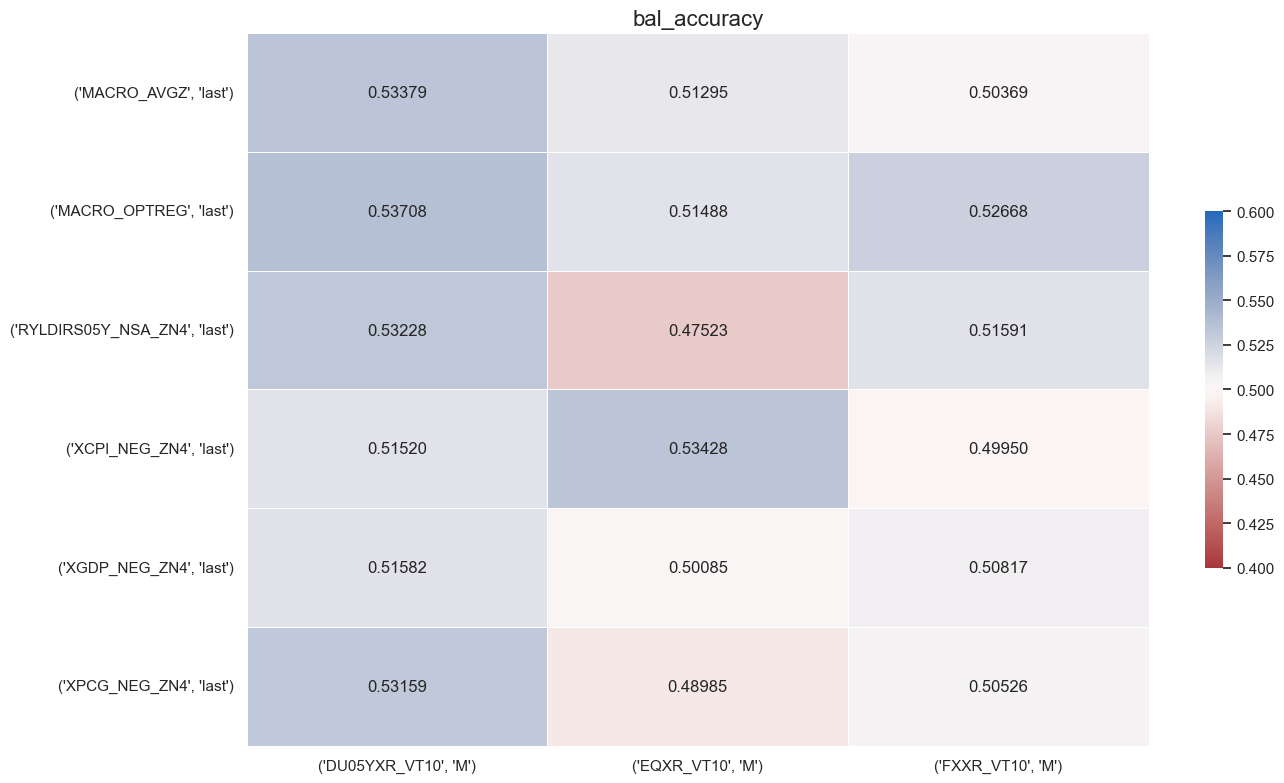

Return                         DU05YXR_VT10 EQXR_VT10 FXXR_VT10
Frequency                                 M         M         M
Signal             Aggregation                                 
MACRO_AVGZ         last            0.533786  0.512946  0.503687
MACRO_OPTREG       last            0.537083  0.514884  0.526681
RYLDIRS05Y_NSA_ZN4 last            0.532283  0.475230  0.515910
XCPI_NEG_ZN4       last            0.515197  0.534277  0.499497
XGDP_NEG_ZN4       last            0.515819  0.500849  0.508170
XPCG_NEG_ZN4       last            0.531591  0.489853  0.505260

In [88]:
srr.single_statistic_table(stat="bal_accuracy", show_heatmap=True, min_color= 0.4, max_color = 0.6)

### Correlation_bars

The method `.correlation_bars()` visualizes positive correlation probabilities based on parametric (Pearson) and non-parametric (Kendall) correlation statistics and compares signals between each other, across countries, or years.

The `type` argument in the `.correlation_bars()` method determines how the correlation probabilities are grouped and visualized:

* If `type='signals'`, the method will plot the correlation probabilities for each signal, comparing them against each other.
* If `type='cross_section'`, the method will plot the correlation probabilities for each cross-section (e.g. county), comparing them against each other.
* If `type='years'`, the method will plot the correlation probabilities for each year, comparing them against each other.

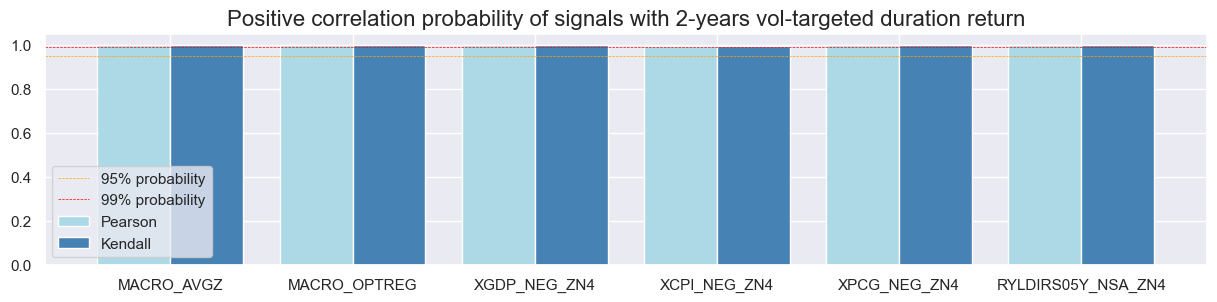

In [89]:
srr.correlation_bars(type="signals", size=(15, 3), title="Positive correlation probability of signals with 2-years vol-targeted duration return")

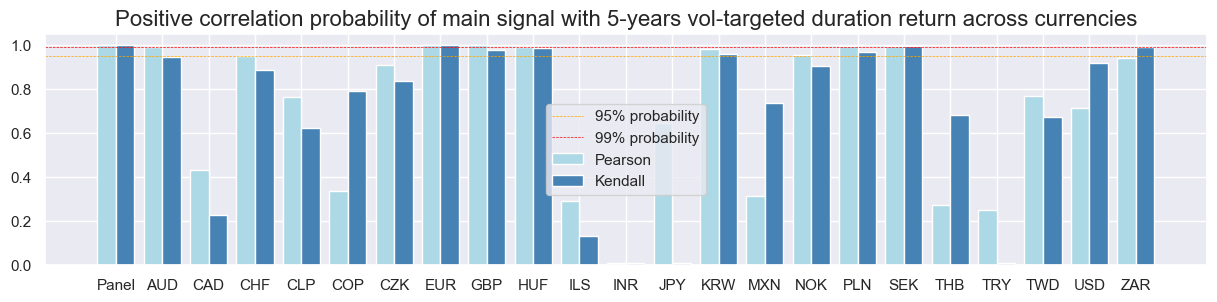

In [90]:
srr.correlation_bars(type="cross_section", title="Positive correlation probability of main signal with 5-years vol-targeted duration return across currencies", size=(15, 3))

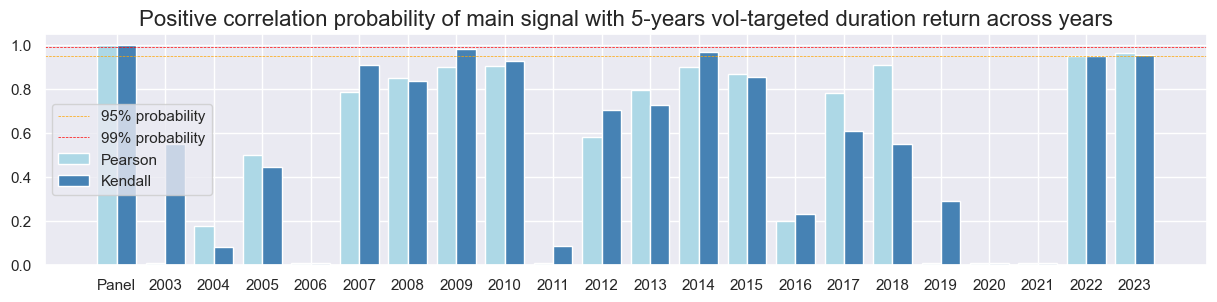

In [91]:
srr.correlation_bars(type="years", size=(15, 3), title="Positive correlation probability of main signal with 5-years vol-targeted duration return across years")

### Accuracy_bars

The `accuracy_bars` method operates analogously to the `correlation_bars` method. Only it shows accuracy and balanced accuracy of the predicted relationship. 

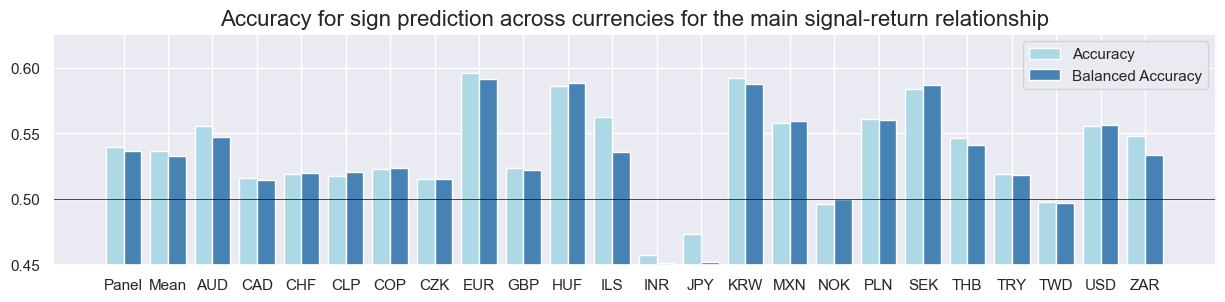

In [92]:
srr.accuracy_bars(type="cross_section", title="Accuracy for sign prediction across currencies for the main signal-return relationship", size=(15, 3))

Using `SignalReturnRelations()` function, we can compare side by side predictive power of the two composite signals : 
- the average macro unoptimized signal `MACRO_AVGZ`, 
- sequentially optimized forecasts `MACRO_OPTREG`,
for 5-year duration returns:

In [93]:
## Compare optimized signals with simple average z-scores

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=["DU05YXR_VT10"],
    sigs=["MACRO_AVGZ", "MACRO_OPTREG"],
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start="2004-01-01",
    blacklist=fxblack,
    slip=1,
)

tbl_srr = srr.signals_table()

In [94]:
tbl_srr.round(3)

accuracy  bal_accuracy  \
Return       Signal       Frequency Aggregation                           
DU05YXR_VT10 MACRO_AVGZ   M         last            0.539         0.537   
             MACRO_OPTREG M         last            0.547         0.537   

                                                 pos_sigr  pos_retr  pos_prec  \
Return       Signal       Frequency Aggregation                                 
DU05YXR_VT10 MACRO_AVGZ   M         last            0.534     0.538     0.572   
             MACRO_OPTREG M         last            0.778     0.538     0.554   

                                                 neg_prec  pearson  \
Return       Signal       Frequency Aggregation                      
DU05YXR_VT10 MACRO_AVGZ   M         last            0.502    0.100   
             MACRO_OPTREG M         last            0.520    0.066   

                                                 pearson_pval  kendall  \
Return       Signal       Frequency Aggregation                          
DU05YXR_VT10 MACRO_AVGZ   M         last                  0.0    0.062   
             MACRO_OPTREG M         last                  0.0    0.044   

                                                 kendall_pval    auc  
Return       Signal       Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ   M         last                  0.0  0.537  
             MACRO_OPTREG M         last                  0.0  0.526

# Backtesting

## NaivePnL

### Instantiation

`NaivePnl()` class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label `naive` because its methods do not consider transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations. 

The class allows a single target return category to be assigned to the `ret` argument, defined as the return on a position corresponding to one unit in the signal. A set of signal categories can be assigned as a list of categories to the `sigs` argument. If the user wishes to evaluate the PnL using benchmark returns, these can be passed as a list of full tickers to the `bms` argument. The instantiation of the class determines the target and the scope of all subsequent analyses, i.e., the period and the set of eligible countries. All other choices can be made subsequently.

In [95]:

sigs = ["MACRO_AVGZ", "MACRO_OPTREG", "XGDP_NEG_ZN4", "XCPI_NEG_ZN4", "XPCG_NEG_ZN4", "RYLDIRS05Y_NSA_ZN4"]
    

naive_pnl = msn.NaivePnL(
    dfx,
    ret="DU05YXR_VT10",
    sigs=sigs,
    cids=cids,
    start="2004-01-01",
    blacklist=fxblack,
    bms=["USD_DU05YXR_NSA"],
)

### make_pnl

The `make_pnl()` method calculates a daily PnL for a specific signal category and adds it to the main dataframe of the class instance. Indeed a single signaling category can result in a wide array of actual signals depending on the choices of its final form.

In particular, the signal transformation option (`sig_op`) manages the distribution of the traded signal and gives the following options:
* `zn_score_pan` transforms raw signals into z-scores around zero value based on the whole panel. The neutral level & standard deviation will use the cross-section of panels. zn-score here means standardized score with zero being the neutral level and standardization through division by mean absolute value. See `make_zn_scores()` function explained in this notebook
* `zn_score_cs` transforms raw signals into z-scores around zero value based on cross-section alone
* `binary` transforms the category values into simple long/shorts (1/-1) signals.


Other important choices include:
* the signal direction parameter `sig_neg` can be set to `True` if the negative value of the transformed signal should be used for PnL calculation,
* rebalancing frequency (`rebal_freq`) for positions according to signal must be one of 'daily' (default), 'weekly' or 'monthly',
* rebalancing slippage (`rebal_slip`) in days, where the default is 1, which means that it takes one day to rebalance the position and that the new position produces PnL from the second day after the signal has been recorded,
* threshold value (`thresh`) beyond which scores are winsorized, i.e. contained at that threshold. This is often realistic, as risk management and the potential of signal value distortions typically preclude outsized and concentrated positions within a strategy. 

The method also allows ex-post scaling of PnL to an annualized volatility by assigning an annualized standard deviation of the aggregate PnL to the `vol_scale` argument. This is for comparative visualization only and very different from apriori volatility targeting.

Method calls add specified PnLs to the class instance for subsequent analysis.

In [96]:
for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        thresh=2,
        pnl_name=sig + "_NEGPZN",
    )

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="binary",
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        thresh=2,
        pnl_name=sig + "_NEGBN",
    )

### make_long_pnl

Based on the provided information, the `pnl.make_long_pnl` function adds a daily long-only PnL with an equal position signal across markets and time. This can serve as a baseline for comparison against the signal-adjusted returns. The `vol_scale` parameter is an ex-post scaling factor that adjusts the PnL to the annualized volatility given. This is likely used for comparative visualization to assess the trading strategy's performance relative to its risk level.

In [97]:
naive_pnl.make_long_pnl(vol_scale=10, label="Long_Only")

### plot_pnls

Available naive PnLs can be listed with the `pnl_names` attribute:

The `plot_pnls()` method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL. The method can plot:

* A single PnL category for a single cross-section, where the user can assign a single cross-section or "ALL" to the `pnl_cids` argument and a single PnL category to the `pnl_cat`s argument.
* Multiple cross-sections per PnL type, where the user can assign a list of cross-sections to the `pnl_cids` argument and a single PnL category to the `pnl_cats` argument.

* Multiple PnL types per cross-section, where the user can assign a list of PnL categories to the `pnl_cats` argument and a single cross-section or "ALL" to the `pnl_cids` argument.

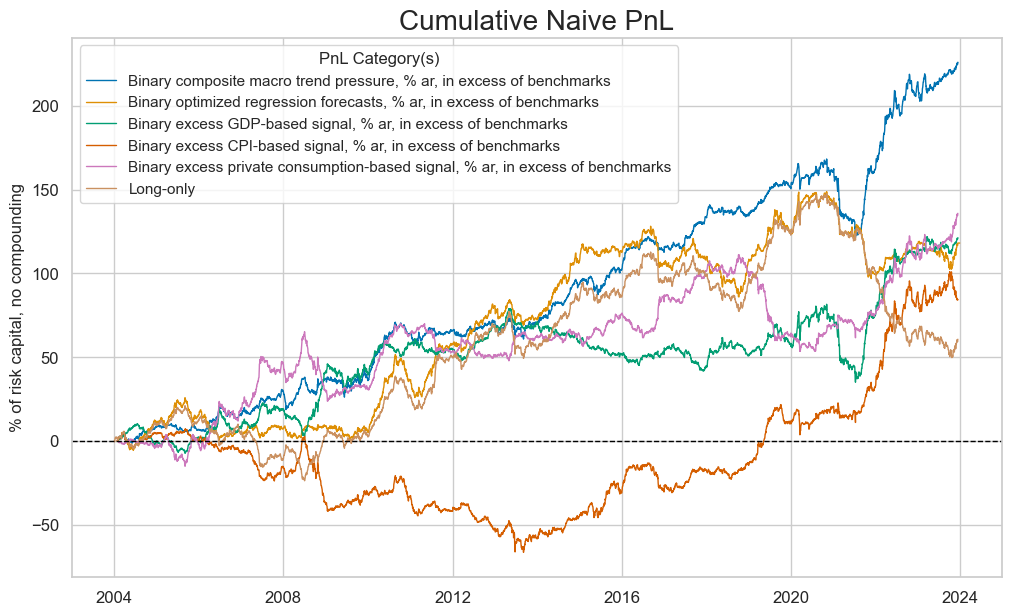

In [98]:
dict_labels = {"MACRO_AVGZ_NEGBN":  "Binary composite macro trend pressure, % ar, in excess of benchmarks", 
               "MACRO_OPTREG_NEGBN": "Binary optimized regression forecasts, % ar, in excess of benchmarks",
                "Long_Only": "Long-only",
                "XGDP_NEG_ZN4_NEGBN": "Binary excess GDP-based signal, % ar, in excess of benchmarks", 
                "XCPI_NEG_ZN4_NEGBN": "Binary excess CPI-based signal, % ar, in excess of benchmarks", 
                "XPCG_NEG_ZN4_NEGBN": "Binary excess private consumption-based signal, % ar, in excess of benchmarks"
               }


naive_pnl.plot_pnls(
    pnl_cats=[
        "MACRO_AVGZ_NEGBN",
        "MACRO_OPTREG_NEGBN",
        "XGDP_NEG_ZN4_NEGBN",
        "XCPI_NEG_ZN4_NEGBN", 
        "XPCG_NEG_ZN4_NEGBN",
        "Long_Only",
    ],
    xcat_labels=dict_labels,
    pnl_cids=["ALL"],
    start="2004-01-01",
    end="2023-12-31",
)

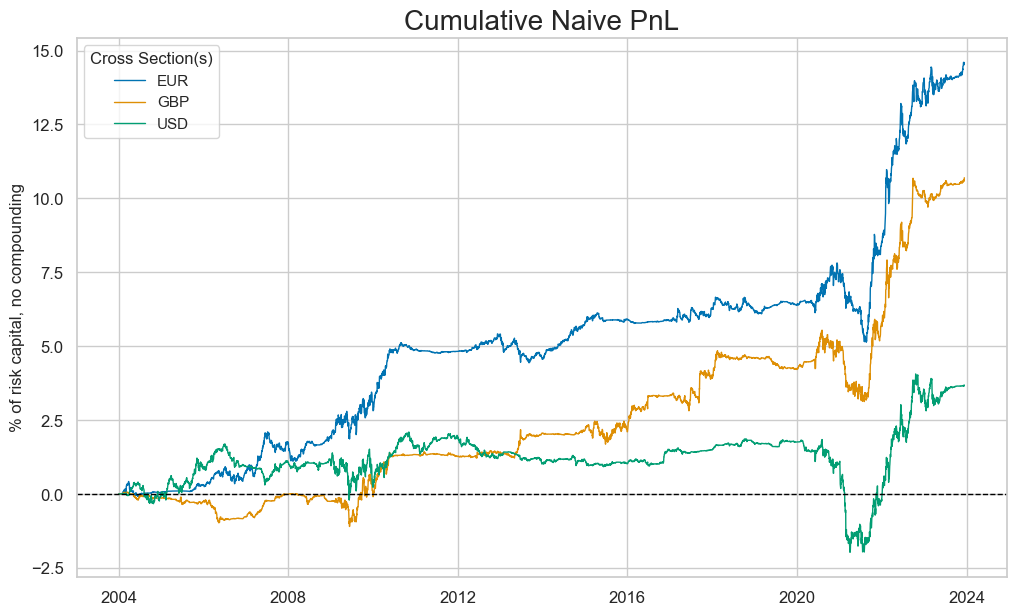

In [99]:
cids_sel = ["EUR", "GBP", "USD"]

naive_pnl.plot_pnls(
    pnl_cats=["MACRO_AVGZ_NEGPZN"],
    pnl_cids=cids_sel,
    start="2004-01-01",
   # end="2021-01-01",
)

### evaluate_pnls

The method `evaluate_pnls()` returns a small dataframe of key PnL statistics. For definitions of Sharpe and Sortino ratios, please see [here](https://www.investopedia.com/ask/answers/010815/what-difference-between-sharpe-ratio-and-sortino-ratio.asp#:~:text=The%20Sharpe%20ratio%20indicates%20how,only%20factors%20in%20downside%20risk.) 

The table can only have multiple PnL categories or multiple cross-sections, not both at the same time. The table also shows the daily benchmark correlation of PnLs.

In [100]:

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=["MACRO_AVGZ_NEGBN", "MACRO_OPTREG_NEGBN", ], pnl_cids=["ALL"], start="2004-01-01", end="2023-12-01"
)


In [101]:
display(df_eval.astype("float").round(2))

xcat                      MACRO_AVGZ_NEGBN  MACRO_OPTREG_NEGBN
Return %                             11.31                5.82
St. Dev. %                           10.00               10.01
Sharpe Ratio                          1.13                0.58
Sortino Ratio                         1.65                0.82
Max 21-Day Draw %                   -22.52              -18.56
Max 6-Month Draw %                  -36.00              -29.45
Peak to Trough Draw %               -46.83              -51.86
Top 5% Monthly PnL Share              0.56                0.98
USD_DU05YXR_NSA correl               -0.04                0.34
Traded Months                       239.00              239.00

### signal_heatmap

The `signal_heatmap()` method creates a heatmap of signals for a specific PnL across time and sections. The time axis refers to period averages, and the default frequency is monthly (specified with freq='m'), but quarterly is also an option (freq='q').

The heatmap displays each signal as a colored square, with the color representing the signal value. The user can specify the particular strategy by specifying "pnl_name". By default, the method plots all available cross-sections. 
The heatmap provides an intuitive representation of the signal values, allowing the user to identify the patterns and trends across time and sections.

The `signal_heatmap()` method includes a color bar legend that shows the signal values and their corresponding color. If a threshold value is provided in the `make_pnl()` function, the `signal_heatmap()` method limits the largest contribution to the specified threshold value. This truncation ensures that any signals with extreme values greater than the threshold will not dominate the visualization, which is important from a risk management perspective.

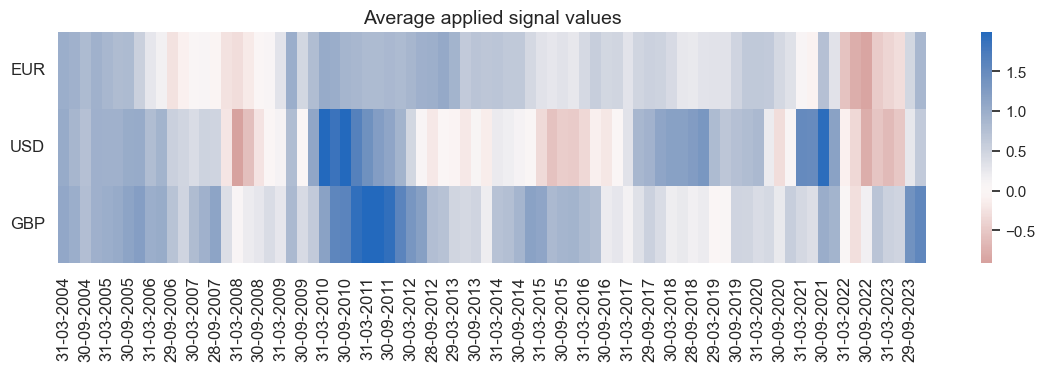

In [102]:
naive_pnl.signal_heatmap(
    pnl_name="MACRO_OPTREG_NEGPZN",
    pnl_cids=["EUR", "USD", "GBP"],
    freq="q",
    start="2004-01-01",
)

### agg_signal_bars

The method `agg_signal_bars()` indicates the strength and direction of the aggregate signal. If `metric='direction'` is chosen, it just adds up the signal across all sections. Long and short signals cancel each other out. If `metric='strength'` is selected, the aggregate absolute signal is displayed, and there is no offset. The method allows for visually understanding the overall direction of the aggregate signal and gaining insight into the proportional exposure to the respective signal by measuring the absolute value, the size of the signal. The question is: "Is the PnL value generated by large returns or a large signal?"

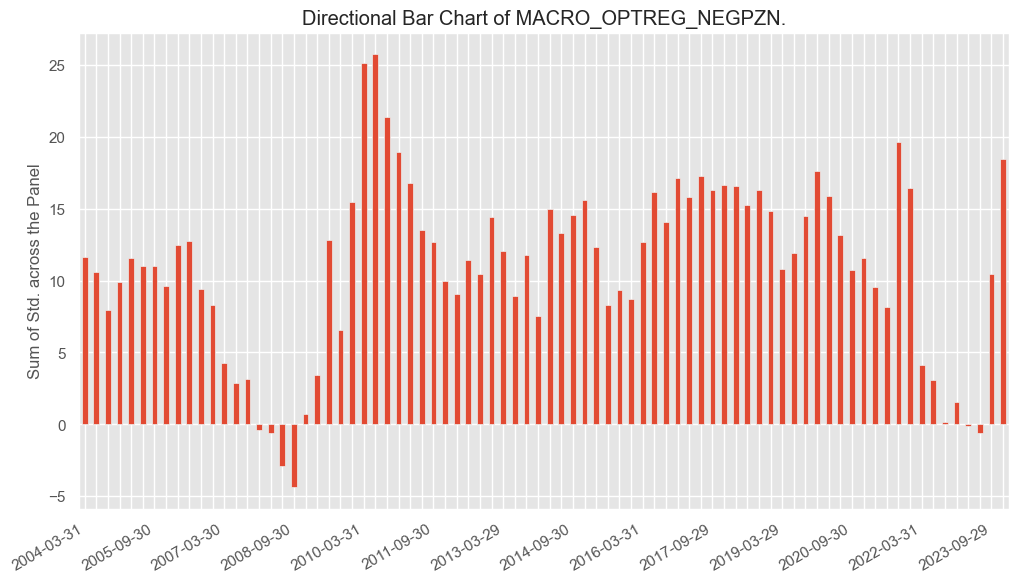

In [103]:
naive_pnl.agg_signal_bars(
    pnl_name="MACRO_OPTREG_NEGPZN",
    freq="q",
    metric="direction",
)

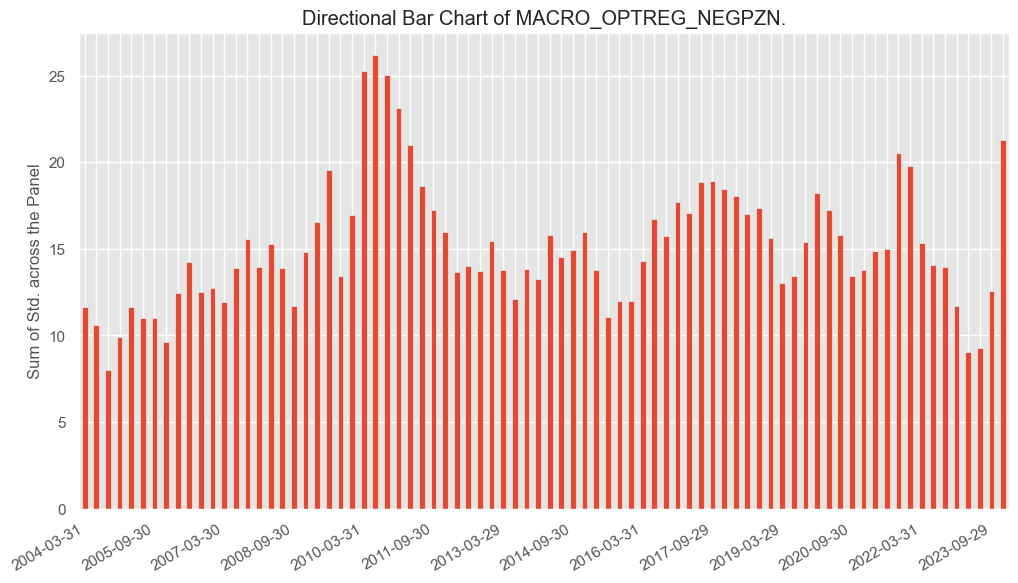

In [104]:
naive_pnl.agg_signal_bars(
    pnl_name="MACRO_OPTREG_NEGPZN",
    freq="q",
    metric="strength",
)